# 7-1 用AI及Apple Mobility預測Covid－19病毒擴散速度（附完整程式）




# 六.程式說明：

Coronavirus is a family of viruses that are named after their spiky crown. 
The novel coronavirus, also known as SARS-CoV-2, is a contagious respiratory virus that first reported in Wuhan, China. On 2/11/2020, the World Health Organization designated the name COVID-19 for the disease caused by the novel coronavirus. This notebook aims at exploring COVID-19 through data analysis and projections.

1. Coronavirus Case Data is provided by Johns Hopkins University

2. Mobility data is provided by Apple

# Study Guideline：

1. Learn more from the WHO

2. Learn more from the CDC

3. Map Visualizations from JHU CCSE Dashboard

4. Check out my predction model on US states here


Feel free to provide me with feedbacks.

Last update: 10/9/2020 12:20 PM ET

New Updates: Daily report data update for 10/9. time series data update for 10/8, mobility data update for 9/7.

Prediction models are trained from a later starting date (3/13/2020). Therefore, earlier dates might not be accurate.

# 1.程式庫及設定引用：

In [50]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
import os

from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error

import datetime
import operator 
plt.style.use('fivethirtyeight')
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# 2. 資料庫擷取及查驗：

匯整資料重點:日期時差的調整
    
1. COVID-19 Global Database - Johns Hopkins Coronavirus Resource Center:讀取二天前資料

2. US CDC:讀取二天前資料

3. Apple Maps Application - mobility tracking:讀取二天前資料

In [51]:
#1. COVID-19 Global Database - Johns Hopkins Coronavirus Resource Center:讀取二天前資料

twodayago=datetime.timedelta(days=2)      #減少二天找到檔案
final_date=datetime.date.today()-twodayago
Date_to_grasp=str(final_date.strftime('%m-%d-%Y'))
Letest_Data_from_CSSE_Name=Date_to_grasp+'.csv'
Letest_Data_from_CSSE_Route='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/'
Latest_Data_from_CSSE_url=Letest_Data_from_CSSE_Route+Letest_Data_from_CSSE_Name
Latest_Data_Save_to_Local='Covid19-Prediction/'+Letest_Data_from_CSSE_Name


print("資料擷取，AI運算中.....")
tStart = time.time()#計時開始
display(Latest_Data_from_CSSE_url)

latest_data = pd.read_csv(Latest_Data_from_CSSE_url)
latest_data.to_csv(Latest_Data_Save_to_Local)

import os
print("存檔位置:"+str(os.getcwd())+str("/")+str(Latest_Data_Save_to_Local)) #取得當前路徑

print("完成了:",end='')
tEnd = time.time()#計時結束
print(f'共 {(tEnd - tStart):.2f} 秒') #數字顯示規格設定
latest_data.head(3)

資料擷取，AI運算中.....


'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/06-20-2022.csv'

存檔位置:d:\USER\desktop\NTUE_AI\onClass\0420/Covid19-Prediction/06-20-2022.csv
完成了:共 0.86 秒


FIPS Admin2 Province_State Country_Region          Last_Update  ...  \
0   NaN    NaN            NaN    Afghanistan  2022-06-21 04:20:56  ...   
1   NaN    NaN            NaN        Albania  2022-06-21 04:20:56  ...   
2   NaN    NaN            NaN        Algeria  2022-06-21 04:20:56  ...   

   Recovered  Active  Combined_Key  Incident_Rate  Case_Fatality_Ratio  
0        NaN     NaN   Afghanistan     466.819277             4.244875  
1        NaN     NaN       Albania    9640.836750             1.260435  
2        NaN     NaN       Algeria     606.564820             2.584732  

[3 rows x 14 columns]

In [52]:
#2. US CDC

twodayago=datetime.timedelta(days=2) #減少二天找到檔案
final_date=datetime.date.today()-twodayago
Date_to_grasp=str(final_date.strftime('%m-%d-%Y'))
US_Medical_Name=Date_to_grasp+'.csv'
US_Medical_Route='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/'
US_Medical_url=US_Medical_Route+US_Medical_Name
US_Medical_Save_to_Local='Covid19-Prediction/US_Medical-'+US_Medical_Name

us_medical_data = pd.read_csv(US_Medical_url)
us_medical_data.to_csv(US_Medical_Save_to_Local)
us_medical_data.head(3)

print("資料擷取，AI運算中.....")
tStart = time.time()#計時開始
display(US_Medical_url)

us_medical_data = pd.read_csv(US_Medical_url)
us_medical_data.to_csv(US_Medical_Save_to_Local)

print("存檔位置:"+str(os.getcwd())+str("/")+str(US_Medical_Save_to_Local)) #取得當前路徑

print("完成了:",end='')
tEnd = time.time()#計時結束
print(f'共 {(tEnd - tStart):.2f} 秒') #數字顯示規格設定

us_medical_data.head(3)

資料擷取，AI運算中.....


'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/06-20-2022.csv'

存檔位置:d:\USER\desktop\NTUE_AI\onClass\0420/Covid19-Prediction/US_Medical-06-20-2022.csv
完成了:共 0.25 秒


Province_State Country_Region          Last_Update      Lat     Long_  ...  \
0         Alabama             US  2022-06-21 04:32:25  32.3182  -86.9023  ...   
1          Alaska             US  2022-06-21 04:32:25  61.3707 -152.4044  ...   
2  American Samoa             US  2022-06-21 04:32:25 -14.2710 -170.1320  ...   

   Case_Fatality_Ratio         UID  ISO3   Testing_Rate  Hospitalization_Rate  
0             1.471928  84000001.0   USA  158892.678942                   NaN  
1             0.481759  84000002.0   USA            NaN                   NaN  
2             0.488805        16.0   ASM            NaN                   NaN  

[3 rows x 18 columns]

In [53]:
#3. Apple Maps Application - mobility tracking

#sixdayago=datetime.timedelta(days=7) #減少三天找到檔案
#final_date=datetime.date.today()-sixdayago
#Date_to_grasp=str(final_date)
#Apple_Mobility_Name='applemobilitytrends-'+Date_to_grasp+'.csv'

#Apple_Mobility_Route='https://covid19-static.cdn-apple.com/covid19-mobility-data/2018HotfixDev19/v3/en-us/'
#Apple_Mobility_url=Apple_Mobility_Route+Apple_Mobility_Name
Apple_Mobility_Save_to_Local='Covid19-Prediction/'+'applemobilitytrends.csv'

Apple_Mobility_url='Covid19-Prediction/applemobilitytrends.csv'
print("資料擷取，AI運算中.....")
tStart = time.time()#計時開始
display(Apple_Mobility_url)

Apple_Mobility_data = pd.read_csv(Apple_Mobility_url)
Apple_Mobility_data.to_csv(Apple_Mobility_Save_to_Local)

print("存檔位置:"+str(os.getcwd())+str("/")+str(Apple_Mobility_Save_to_Local)) #取得當前路徑

print("完成了:",end='')
tEnd = time.time()#計時結束
print(f'共 {(tEnd - tStart):.2f} 秒') #數字顯示規格設定

display(Apple_Mobility_data.head(3))


資料擷取，AI運算中.....


'Covid19-Prediction/applemobilitytrends.csv'

存檔位置:d:\USER\desktop\NTUE_AI\onClass\0420/Covid19-Prediction/applemobilitytrends.csv
完成了:共 1.00 秒


Unnamed: 0.4  Unnamed: 0.3  Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  ...  \
0             0             0             0             0           0  ...   
1             1             1             1             1           1  ...   
2             2             2             2             2           2  ...   

  2020-10-03 2020-10-04 2020-10-05 2020-10-06 2020-10-07  
0     148.03     136.67     123.11     117.50     119.25  
1     166.40     130.23     168.27     140.04     154.46  
2      71.69      38.69      55.99      59.95      62.76  

[3 rows x 280 columns]

In [54]:
#4. 匯整資料：

print("資料擷取，AI運算中.....")
tStart = time.time()#單一資料庫計時開始
Total_data=0
Total_Time=0.00


資料擷取，AI運算中.....


In [55]:
#1. 全球確診資料
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
confirmed_df.to_csv('Covid19-Prediction/time_series_covid19_confirmed_global.csv')
tEnd = time.time()#單一資料庫計時開始
Total_data=Total_data+len(confirmed_df)
print(f'1. Global Cofirmed Cases:{len(confirmed_df):.0f} 筆資料,累計時間{(tEnd - tStart):.2f}秒....') 
T1=tEnd - tStart


1. Global Cofirmed Cases:285 筆資料,累計時間1.86秒....


In [56]:
#2. 全球死亡資料
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
deaths_df.to_csv('Covid19-Prediction/time_series_covid19_deaths_global.csv')
tEnd = time.time()#單一資料庫計時開始
Total_data=Total_data+len(deaths_df)
print(f'2. Global Deaths Cases:{len(deaths_df):.0f} 筆資料,累計時間{(tEnd - tStart):.2f}秒....') 
T2=tEnd - tStart

2. Global Deaths Cases:285 筆資料,累計時間3.16秒....


In [57]:
#3. 全球復原資料
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
recoveries_df.to_csv('Covid19-Prediction/time_series_covid19_recovered_global.csv')
tEnd = time.time()#單一資料庫計時開始
Total_data=Total_data+len(recoveries_df)
print(f'3. Global Recovery Cases:{len(recoveries_df):.0f} 筆資料,累計時間{(tEnd - tStart):.2f}秒....') 
T3=tEnd - tStart


3. Global Recovery Cases:270 筆資料,累計時間4.39秒....


In [58]:
#4. WHO的最新匯整資料
latest_data = pd.read_csv(Latest_Data_Save_to_Local)
tEnd = time.time()#單一資料庫計時開始
Total_data=Total_data+len(latest_data)
print(f'4. Global Updated Cases:{len(latest_data):.0f} 筆資料,累計時間{(tEnd - tStart):.2f}秒....') 
T4=tEnd - tStart

4. Global Updated Cases:4011 筆資料,累計時間4.48秒....


In [59]:
#5. US Medical美國醫療能量狀況更新
us_medical_data = pd.read_csv(US_Medical_Save_to_Local)
tEnd = time.time()#單一資料庫計時開始
Total_data=Total_data+len(us_medical_data)
print(f'5. US Medical Data:{len(us_medical_data):.0f} 筆資料,累計時間{(tEnd - tStart):.2f}秒....')   
T5=tEnd - tStart

5. US Medical Data:58 筆資料,累計時間4.54秒....


In [60]:
#6. Apple mobility
apple_mobility = pd.read_csv('Covid19-Prediction/applemobilitytrends.csv')
tEnd = time.time()#單一資料庫計時開始
Total_data=Total_data+len(apple_mobility)
print(f'6. Apple Mobility Data:{len(apple_mobility):.0f} 筆資料,累計時間{(tEnd - tStart):.2f}秒....') 
T6=tEnd - tStart

6. Apple Mobility Data:4691 筆資料,累計時間4.78秒....


In [61]:

print("匯整完成!",end='')
tEnd = time.time()#全部資料庫計時結束
Total_Time=T1+T2+T3+T4+T5+T6
print(f'共：{Total_data:.0f} 筆資料,總共時間{(Total_Time):.2f}秒') 

匯整完成!共：9600 筆資料,總共時間23.21秒


# 3. 資料純化及排序：

進行空值填補，及移動平均插值，並依日期順序進行排序。

In [62]:
#1. 全球確診資料
confirmed_df = pd.read_csv("Covid19-Prediction/time_series_covid19_confirmed_global.csv")

import os
Saved_Name='time_series_covid19_confirmed_global.csv'
print("Covid－19全球確診總數 即時資料:")
print("轉存存檔位置:"+str(os.getcwd())+str("/")+str(Saved_Name)) #取得當前路徑                                                
print("共有多少國家納入「哈佛大學公衞中心」統計："+str(confirmed_df['Country/Region'].nunique()))  #找出相異資料
print("統計資料第一天："+str(confirmed_df.columns[5])) 
print("統計資料最後一天："+str(confirmed_df.columns[len(confirmed_df.columns)-1])) 
print("共統計多少天："+str(len(confirmed_df.columns)-5))  

Covid－19全球確診總數 即時資料:
轉存存檔位置:d:\USER\desktop\NTUE_AI\onClass\0420/time_series_covid19_confirmed_global.csv
共有多少國家納入「哈佛大學公衞中心」統計：199
統計資料第一天：1/22/20
統計資料最後一天：6/21/22
共統計多少天：882


In [63]:
#2. 全球死亡資料
deaths_df = pd.read_csv("Covid19-Prediction/time_series_covid19_recovered_global.csv")

import os
Saved_Name='Covid19-Prediction/time_series_covid19_recovered_global.csv'
print("Covid－19全球死亡總數 即時資料:")
print("轉存存檔位置:"+str(os.getcwd())+str("/")+str(Saved_Name)) #取得當前路徑                                                
print("共有多少國家納入「哈佛大學公衞中心」統計："+str(deaths_df['Country/Region'].nunique()))  
#找出相異資料
print("統計資料第一天："+str(deaths_df.columns[5])) 
print("統計資料最後一天："+str(deaths_df.columns[len(confirmed_df.columns)-1])) 
print("共統計多少天："+str(len(deaths_df.columns)-5))   

Covid－19全球死亡總數 即時資料:
轉存存檔位置:d:\USER\desktop\NTUE_AI\onClass\0420/Covid19-Prediction/time_series_covid19_recovered_global.csv
共有多少國家納入「哈佛大學公衞中心」統計：199
統計資料第一天：1/22/20
統計資料最後一天：6/21/22
共統計多少天：882


In [64]:
#3. 全球復原資料
recoveries_df = pd.read_csv("Covid19-Prediction/time_series_covid19_deaths_global.csv")

import os
Saved_Name='Covid19-Prediction/time_series_covid19_deaths_global.csv'
print("Covid－19全球復原總數 即時資料:")
print("轉存存檔位置:"+str(os.getcwd())+str("/")+str(Saved_Name)) #取得當前路徑                                                
print("共有多少國家納入「哈佛大學公衞中心」統計："+str(recoveries_df['Country/Region'].nunique()))  #找出相異資料
print("統計資料第一天："+str(recoveries_df.columns[5])) 
print("統計資料最後一天："+str(recoveries_df.columns[len(recoveries_df.columns)-1])) 
print("共統計多少天："+str(len(recoveries_df.columns)-5))    

Covid－19全球復原總數 即時資料:
轉存存檔位置:d:\USER\desktop\NTUE_AI\onClass\0420/Covid19-Prediction/time_series_covid19_deaths_global.csv
共有多少國家納入「哈佛大學公衞中心」統計：199
統計資料第一天：1/22/20
統計資料最後一天：6/21/22
共統計多少天：882


In [65]:
#4. 全球「WHO最新更新」按國家排序的資料庫,進行匯整資料
latest_data = pd.read_csv(Latest_Data_Save_to_Local)

import os
Saved_Name=Latest_Data_Save_to_Local
print("Covid－19全球 最新 即時資料:")
print("轉存存檔位置:"+str(os.getcwd())+str("/")+str(Saved_Name)) #取得當前路徑                                                
print("共有多少國家納入「哈佛大學公衞中心」統計："+str(latest_data['Country_Region'].nunique())) #找出相異資料
print("資料日期："+str(latest_data['Last_Update'].max()))    
print("共統計多少天："+str(latest_data['Last_Update'].nunique())) 

Covid－19全球 最新 即時資料:
轉存存檔位置:d:\USER\desktop\NTUE_AI\onClass\0420/Covid19-Prediction/06-20-2022.csv
共有多少國家納入「哈佛大學公衞中心」統計：199
資料日期：2022-06-21 04:20:56
共統計多少天：9


In [66]:
latest_data

Unnamed: 0  FIPS Admin2 Province_State        Country_Region  ...  \
0              0   NaN    NaN            NaN           Afghanistan  ...   
1              1   NaN    NaN            NaN               Albania  ...   
2              2   NaN    NaN            NaN               Algeria  ...   
3              3   NaN    NaN            NaN               Andorra  ...   
4              4   NaN    NaN            NaN                Angola  ...   
...          ...   ...    ...            ...                   ...  ...   
4006        4006   NaN    NaN            NaN    West Bank and Gaza  ...   
4007        4007   NaN    NaN            NaN  Winter Olympics 2022  ...   
4008        4008   NaN    NaN            NaN                 Yemen  ...   
4009        4009   NaN    NaN            NaN                Zambia  ...   
4010        4010   NaN    NaN            NaN              Zimbabwe  ...   

     Recovered  Active          Combined_Key  Incident_Rate  \
0          NaN     NaN           Afghanistan     466.819277   
1          NaN     NaN               Albania    9640.836750   
2          NaN     NaN               Algeria     606.564820   
3          NaN     NaN               Andorra   56233.741021   
4          NaN     NaN                Angola     303.536136   
...        ...     ...                   ...            ...   
4006       NaN     NaN    West Bank and Gaza   12908.239595   
4007       NaN     NaN  Winter Olympics 2022            NaN   
4008       NaN     NaN                 Yemen      39.639954   
4009       NaN     NaN                Zambia    1764.277504   
4010       NaN     NaN              Zimbabwe    1714.541153   

      Case_Fatality_Ratio  
0                4.244875  
1                1.260435  
2                2.584732  
3                0.352137  
4                1.904552  
...                   ...  
4006             0.859525  
4007             0.000000  
4008            18.176436  
4009             1.232334  
4010             2.171635  

[4011 rows x 15 columns]

In [67]:
#5. US Medical美國醫療能量狀況更新
us_medical_data = pd.read_csv(US_Medical_Save_to_Local)

import os
Saved_Name='Covid19-Prediction/US_Medical_Save_to_Local'
print("Covid－19美國55州＋3個美國屬地 最新 即時資料:")
print("轉存存檔位置:"+str(os.getcwd())+str("/")+str(Saved_Name)) #取得當前路徑                                                
print("共有多少國家納入「哈佛大學公衞中心」統計："+str(us_medical_data['Country_Region'].nunique()))#找出相異資料
print("美國共有多少州納入「哈佛大學公衞中心」統計："+str(us_medical_data['Province_State'].nunique()))#找出相異資料
print("共有多少國家納入「哈佛大學公衞中心」統計："+str(latest_data['Country_Region'].nunique())) #找出相異資料
print("資料日期："+str(us_medical_data['Last_Update'].max())) 
print("共統計多少天："+str(us_medical_data['Last_Update'].nunique()))   

Covid－19美國55州＋3個美國屬地 最新 即時資料:
轉存存檔位置:d:\USER\desktop\NTUE_AI\onClass\0420/Covid19-Prediction/US_Medical_Save_to_Local
共有多少國家納入「哈佛大學公衞中心」統計：1
美國共有多少州納入「哈佛大學公衞中心」統計：58
共有多少國家納入「哈佛大學公衞中心」統計：199
資料日期：2022-06-21 04:32:25
共統計多少天：1


In [68]:
#6. Apple mobility
apple_mobility = pd.read_csv("Covid19-Prediction/applemobilitytrends.csv")

import os
Saved_Name='Covid19-Prediction/applemobilitytrends.csv'
print("Covid－19全球 最新 人員移動 即時資料:")
print("轉存存檔位置:"+str(os.getcwd())+str("/")+str(Saved_Name)) #取得當前路徑 
print("共有多少國家＋地區鄉鎮 納入「Apple Ability」統計："+str(apple_mobility['region'].nunique()))#找出相異資料
print("共有多少國家 納入「Apple Ability」統計："+str(apple_mobility['country'].nunique()))#找出相異資料
print("共有多少州/地區 納入「Apple Ability」統計："+str(apple_mobility['sub-region'].nunique()))#找出相異資料
print("共有多少種移動方式："+str(apple_mobility['transportation_type'].nunique()))#找

print("統計資料第一天："+str(apple_mobility.columns[6])) 
print("統計資料最後一天："+str(apple_mobility.columns[len(apple_mobility.columns)-1])) 
print("共統計多少天："+str(len(apple_mobility.columns)-7))  
print("美國共有多少州納入「哈佛大學公衞中心」統計："+str(us_medical_data['Province_State'].nunique()))#找出相異資料

Covid－19全球 最新 人員移動 即時資料:
轉存存檔位置:d:\USER\desktop\NTUE_AI\onClass\0420/Covid19-Prediction/applemobilitytrends.csv
共有多少國家＋地區鄉鎮 納入「Apple Ability」統計：2325
共有多少國家 納入「Apple Ability」統計：47
共有多少州/地區 納入「Apple Ability」統計：162
共有多少種移動方式：3
統計資料第一天：geo_type
統計資料最後一天：2020-10-07
共統計多少天：274
美國共有多少州納入「哈佛大學公衞中心」統計：58


# 看一下Apple Mobility資料全貌：

In [69]:
pd.set_option('display.max_rows', 6)
pd.set_option('display.max_columns', 10)
apple_mobility

Unnamed: 0.5  Unnamed: 0.4  Unnamed: 0.3  Unnamed: 0.2  Unnamed: 0.1  \
0                0             0             0             0             0   
1                1             1             1             1             1   
2                2             2             2             2             2   
...            ...           ...           ...           ...           ...   
4688          4688          4688          4688          4688          4688   
4689          4689          4689          4689          4689          4689   
4690          4690          4690          4690          4690          4690   

      ...  2020-10-03 2020-10-04 2020-10-05 2020-10-06 2020-10-07  
0     ...      148.03     136.67     123.11     117.50     119.25  
1     ...      166.40     130.23     168.27     140.04     154.46  
2     ...       71.69      38.69      55.99      59.95      62.76  
...   ...         ...        ...        ...        ...        ...  
4688  ...      178.95     147.52     143.31     137.39     136.21  
4689  ...      164.80     137.51     120.67     115.82     116.66  
4690  ...      197.85     139.57     140.86     127.90     127.64  

[4691 rows x 281 columns]

# 查看一下台灣的Mobility:資料非常完整，可以做精準的機器學習預測的資料。

In [70]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 11)
Listname = ['Taiwan']
apple_mobility[apple_mobility.country.isin(Listname)]

Unnamed: 0.5  Unnamed: 0.4  Unnamed: 0.3  Unnamed: 0.2  Unnamed: 0.1  \
293            293           293           293           293           293   
294            294           294           294           294           294   
458            458           458           458           458           458   
459            459           459           459           459           459   
845            845           845           845           845           845   
...            ...           ...           ...           ...           ...   
1870          1870          1870          1870          1870          1870   
1871          1871          1871          1871          1871          1871   
1872          1872          1872          1872          1872          1872   
1873          1873          1873          1873          1873          1873   
1879          1879          1879          1879          1879          1879   

      ...  2020-10-03 2020-10-04 2020-10-05 2020-10-06 2020-10-07  
293   ...      203.17     132.41      98.96      98.83     109.93  
294   ...      217.34     133.92     106.26     124.59     127.06  
458   ...      155.85     113.01      99.60     102.22     110.60  
459   ...      162.06     121.16     116.43     121.25     117.36  
845   ...      124.17     103.25      92.95      92.23      97.23  
...   ...         ...        ...        ...        ...        ...  
1870  ...      118.88      84.57      72.13      73.15      69.90  
1871  ...       86.37      77.92      79.37      82.52      86.24  
1872  ...       81.45      61.64      60.35      64.97      69.10  
1873  ...       66.13      60.69      62.01      64.56      65.02  
1879  ...         NaN        NaN        NaN        NaN        NaN  

[26 rows x 281 columns]

# 查看一下中國和韓國的Apple Mobility:有些國家不公佈行動資料。

In [71]:
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 11)
Listname = ['Korea','China']
apple_mobility[apple_mobility.country.isin(Listname)]

Empty DataFrame
Columns: [Unnamed: 0.5, Unnamed: 0.4, Unnamed: 0.3, Unnamed: 0.2, Unnamed: 0.1, Unnamed: 0, geo_type, region, transportation_type, alternative_name, sub-region, country, 2020-01-13, 2020-01-14, 2020-01-15, 2020-01-16, 2020-01-17, 2020-01-18, 2020-01-19, 2020-01-20, 2020-01-21, 2020-01-22, 2020-01-23, 2020-01-24, 2020-01-25, 2020-01-26, 2020-01-27, 2020-01-28, 2020-01-29, 2020-01-30, 2020-01-31, 2020-02-01, 2020-02-02, 2020-02-03, 2020-02-04, 2020-02-05, 2020-02-06, 2020-02-07, 2020-02-08, 2020-02-09, 2020-02-10, 2020-02-11, 2020-02-12, 2020-02-13, 2020-02-14, 2020-02-15, 2020-02-16, 2020-02-17, 2020-02-18, 2020-02-19, 2020-02-20, 2020-02-21, 2020-02-22, 2020-02-23, 2020-02-24, 2020-02-25, 2020-02-26, 2020-02-27, 2020-02-28, 2020-02-29, 2020-03-01, 2020-03-02, 2020-03-03, 2020-03-04, 2020-03-05, 2020-03-06, 2020-03-07, 2020-03-08, 2020-03-09, 2020-03-10, 2020-03-11, 2020-03-12, 2020-03-13, 2020-03-14, 2020-03-15, 2020-03-16, 2020-03-17, 2020-03-18, 2020-03-19, 2020-03-20, 2020-03-21, 2020-03-22, 2020-03-23, 2020-03-24, 2020-03-25, 2020-03-26, 2020-03-27, 2020-03-28, 2020-03-29, 2020-03-30, 2020-03-31, 2020-04-01, 2020-04-02, 2020-04-03, 2020-04-04, 2020-04-05, 2020-04-06, 2020-04-07, 2020-04-08, 2020-04-09, ...]
Index: []

[0 rows x 281 columns]

# 查看一下美國的Mobility:

美國資料非常精細，小到鄉鎮村莊的資料都有；在資料科學的分析上，美國技術領先全球各國，不是沒有原因的。

In [72]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 11)
Listname = ['United States']
apple_mobility[apple_mobility.country.isin(Listname)]

Unnamed: 0.5  Unnamed: 0.4  Unnamed: 0.3  Unnamed: 0.2  Unnamed: 0.1  \
158            158           158           158           158           158   
159            159           159           159           159           159   
160            160           160           160           160           160   
161            161           161           161           161           161   
162            162           162           162           162           162   
...            ...           ...           ...           ...           ...   
4686          4686          4686          4686          4686          4686   
4687          4687          4687          4687          4687          4687   
4688          4688          4688          4688          4688          4688   
4689          4689          4689          4689          4689          4689   
4690          4690          4690          4690          4690          4690   

      ...  2020-10-03 2020-10-04 2020-10-05 2020-10-06 2020-10-07  
158   ...      162.35     112.29     126.03     140.77     138.12  
159   ...       50.74      38.09      50.29      55.59      50.59  
160   ...      135.25      93.68      95.82     110.60     106.18  
161   ...      146.53     111.13     116.33     122.96     133.93  
162   ...       95.26      83.00      97.17      96.47      92.52  
...   ...         ...        ...        ...        ...        ...  
4686  ...      254.64     160.11     171.22     190.72     181.05  
4687  ...      161.79     134.69     138.08     133.88     132.72  
4688  ...      178.95     147.52     143.31     137.39     136.21  
4689  ...      164.80     137.51     120.67     115.82     116.66  
4690  ...      197.85     139.57     140.86     127.90     127.64  

[3102 rows x 281 columns]

In [73]:
#篩選台灣的資料：
apple_mobility[(apple_mobility['country'] =='Taiwan') | (apple_mobility['country'] == 'India')]

Unnamed: 0.5  Unnamed: 0.4  Unnamed: 0.3  Unnamed: 0.2  Unnamed: 0.1  \
208            208           208           208           208           208   
209            209           209           209           209           209   
293            293           293           293           293           293   
294            294           294           294           294           294   
298            298           298           298           298           298   
...            ...           ...           ...           ...           ...   
1870          1870          1870          1870          1870          1870   
1871          1871          1871          1871          1871          1871   
1872          1872          1872          1872          1872          1872   
1873          1873          1873          1873          1873          1873   
1879          1879          1879          1879          1879          1879   

      ...  2020-10-03 2020-10-04 2020-10-05 2020-10-06 2020-10-07  
208   ...       98.32      87.72      77.68      75.13      78.90  
209   ...       92.38      87.79      89.96      84.27      83.24  
293   ...      203.17     132.41      98.96      98.83     109.93  
294   ...      217.34     133.92     106.26     124.59     127.06  
298   ...       96.27      84.93      80.62      79.22      76.23  
...   ...         ...        ...        ...        ...        ...  
1870  ...      118.88      84.57      72.13      73.15      69.90  
1871  ...       86.37      77.92      79.37      82.52      86.24  
1872  ...       81.45      61.64      60.35      64.97      69.10  
1873  ...       66.13      60.69      62.01      64.56      65.02  
1879  ...         NaN        NaN        NaN        NaN        NaN  

[38 rows x 281 columns]

# 4.特徵工程：
在進行人工智慧的運算中，將資料整理成數字，便於決定樹狀決策及權重。這是很重要的工作。

In [74]:
#選取要用到的欄位
cols = confirmed_df.keys()

#找出日期範圍，存入cols
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]

In [75]:
#計算各國死亡率及復原率：mortality_rate，recovery_rate
dates = confirmed.keys()
world_cases = []
total_deaths = [] 
mortality_rate = []
recovery_rate = [] 
total_recovered = [] 
total_active = [] 

for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()
    
    # confirmed, deaths, recovered, and active
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    total_recovered.append(recovered_sum)
    total_active.append(confirmed_sum-death_sum-recovered_sum)
    
    # calculate rates
    mortality_rate.append(death_sum/confirmed_sum)
    recovery_rate.append(recovered_sum/confirmed_sum)

In [76]:
mortality_rate

[1.1730628513141066,
 0.05385996409335727,
 0.0487062404870624,
 0.0413135593220339,
 0.029227557411273485,
 0.026415094339622643,
 0.02219187435984978,
 0.01935483870967742,
 0.020586804992705463,
 0.017603496418599006,
 0.022665457842248413,
 0.023841169629506564,
 0.028355274915112885,
 0.03152813395685624,
 0.03585924097242563,
 0.040876862972073505,
 0.04846458482113874,
 0.0586046511627907,
 0.07048019175352131,
 0.0808475673522235,
 0.09232891445138061,
 0.10452090864461998,
 0.11387955429784223,
 0.10423290937996821,
 0.12047166427546628,
 0.13607993628267323,
 0.15254499003340913,
 0.17178223902392423,
 0.19096533830084492,
 0.21311215385632146,
 0.23854571218641754,
 0.245868360096817,
 0.29121717891308774,
 0.29620205089251805,
 0.3171145579325775,
 0.3470501915137044,
 0.3733903469969527,
 0.4023063533507398,
 0.4362819659663466,
 0.4624872128708267,
 0.48325283078628556,
 0.5045749753825387,
 0.518597774073875,
 0.5368402278712087,
 0.5487819806585873,
 0.5479118852860982,

In [77]:
# 計算每日增加數，及移動平均
# 整合各資料庫的數據：
def daily_increase(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 

def moving_average(data, window_size):
    moving_average = []
    for i in range(len(data)):
        if i + window_size < len(data):
            moving_average.append(np.mean(data[i:i+window_size]))
        else:
            moving_average.append(np.mean(data[i:len(data)]))
    return moving_average

# window size
window = 7

# confirmed cases
world_daily_increase = daily_increase(world_cases)
world_confirmed_avg= moving_average(world_cases, window)
world_daily_increase_avg = moving_average(world_daily_increase, window)

# deaths
world_daily_death = daily_increase(total_deaths)
world_death_avg = moving_average(total_deaths, window)
world_daily_death_avg = moving_average(world_daily_death, window)

# recoveries
world_daily_recovery = daily_increase(total_recovered)
world_recovery_avg = moving_average(total_recovered, window)
world_daily_recovery_avg = moving_average(world_daily_recovery, window)

# active 
world_active_avg = moving_average(total_active, window)

In [78]:
#計算死亡總數及復原總數：
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)
total_recovered = np.array(total_recovered).reshape(-1, 1)
# reshape(-1, 1)  -1表示自己算col

# 5. 預測：採用下列演算法：

(1) SVM(support vector machine):「支援向量機器」
    
(2) Polynomial Regression Predictions：「多項式回歸」

(3) Bayesian Ridge Regression：「貝葉斯線性迴歸」

In [79]:
#計算前的準備:
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]

In [80]:
#將資料改為日期格式:
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [81]:
#分割資料：訓練集，測試集：
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22[50:], 
                world_cases[50:], test_size=0.12, shuffle=False) 

# 三個預測模型

Model for predicting for confirmed cases:
    
1. support vector machine, 
2. bayesian ridge 
3. linear regression 

in confirmed case predictuion example. 

# 三個預測模型之最佳化參數如下：

find the optimal parameters for SVR

c = [0.01, 0.11, 1]

gamma = [0.012, 0.1, 1]

epsilon = [0.014, 0.1, 1]

shrinking = [True, False]

degree = [3, 4, 5]

svm_grid = {'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'shrinking' : shrinking, 'degree': degree}

svm = SVR(kernel='poly')

svm_search = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=30, verbose=1)

svm_search.fit(X_train_confirmed, y_train_confirmed)

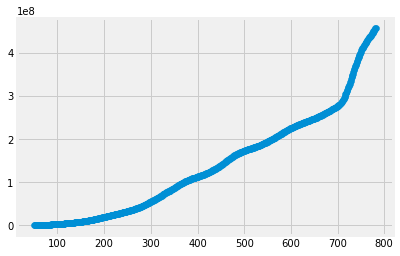

In [84]:
plt.scatter(X_train_confirmed, y_train_confirmed)
plt.plot(X_train_confirmed, y_train_confirmed, '-')

In [85]:
# (1) SVM「支援向量機器」:
# 使用最佳參數，執行演算：svm_confirmed = svm_search.best_estimator

svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=3, C=0.1)
svm_confirmed.fit(X_train_confirmed, y_train_confirmed)
svm_pred = svm_confirmed.predict(future_forcast)

MAE: 38500761.753229134
MSE: 2614570341054326.5


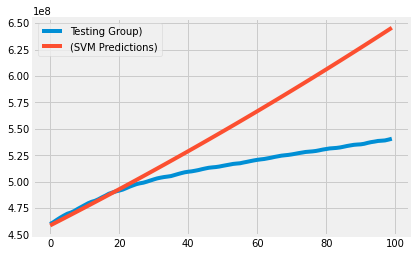

In [86]:
# SVM「支援向量機器」演算，驗證結果：

svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(y_test_confirmed)
plt.plot(svm_test_pred)
plt.legend(['Testing Group)', '(SVM Predictions)'])
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(svm_test_pred, y_test_confirmed))

In [87]:
# (2) polynomial regression「多項式迴歸演算」：
#  轉換資料以便進行多項式回歸演算

poly = PolynomialFeatures(degree=5)
poly_X_train_confirmed = poly.fit_transform(X_train_confirmed)
poly_X_test_confirmed = poly.fit_transform(X_test_confirmed)
poly_future_forcast = poly.fit_transform(future_forcast)

bayesian_poly = PolynomialFeatures(degree=5)
bayesian_poly_X_train_confirmed = bayesian_poly.fit_transform(X_train_confirmed)
bayesian_poly_X_test_confirmed = bayesian_poly.fit_transform(X_test_confirmed)
bayesian_poly_future_forcast = bayesian_poly.fit_transform(future_forcast)

In [88]:
#多項式迴歸演算」完成，驗證結果：
# polynomial regression
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(poly_X_test_confirmed)
linear_pred = linear_model.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))

MAE: 221245507.86959264
MSE: 7.220800546666982e+16


In [89]:
#「多項式迴歸演算」相關性係數如下：
print(linear_model.coef_)

[[-4.26659408e+07  1.10981807e+06 -9.49561732e+03  3.79274993e+01
  -5.99831905e-02  3.33518256e-05]]


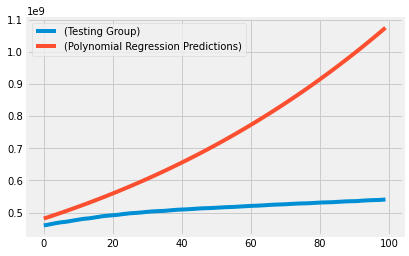

In [90]:
#「多項式迴歸演算」與測試組比較，程式及續圖結果如下：

plt.plot(y_test_confirmed)
plt.plot(test_linear_pred)
plt.legend(['(Testing Group)', '(Polynomial Regression Predictions)'])

In [91]:
#(3) Bayesian Ridge Regression「貝葉斯線性迴歸」：
# 先用標準的參數來算。結果如下：
# bayesian ridge polynomial regression

tol = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
normalize = [True, False]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2, 
                 'normalize' : normalize}

bayesian = BayesianRidge(fit_intercept=False)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(bayesian_poly_X_train_confirmed, y_train_confirmed)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


RandomizedSearchCV(cv=3, estimator=BayesianRidge(fit_intercept=False),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                                     0.0001, 0.001],
                                        'lambda_2': [1e-07, 1e-06, 1e-05,
                                                     0.0001, 0.001],
                                        'normalize': [True, False],
                                        'tol': [1e-06, 1e-05, 0.0001, 0.001,
                                                0.01]},
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [92]:
#「貝葉斯線性迴歸」最佳參數如下:

bayesian_search.best_params_

{'tol': 1e-06,
 'normalize': True,
 'lambda_2': 0.001,
 'lambda_1': 1e-07,
 'alpha_2': 0.001,
 'alpha_1': 1e-07}

In [93]:
# 用最佳參數，再次運算結果如下：

bayesian_confirmed = bayesian_search.best_estimator_
test_bayesian_pred = bayesian_confirmed.predict(bayesian_poly_X_test_confirmed)
bayesian_pred = bayesian_confirmed.predict(bayesian_poly_future_forcast)
print('MAE:', mean_absolute_error(test_bayesian_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_bayesian_pred, y_test_confirmed))

MAE: 103889122.80441101
MSE: 1.7945773625878566e+16


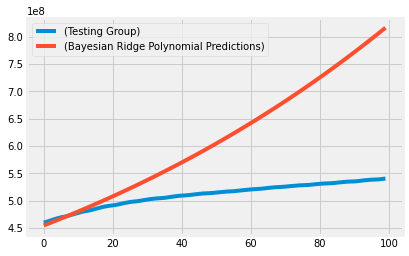

In [94]:
#「貝葉斯線性迴歸」與測試組比較，程式及續圖結果如下：

plt.plot(y_test_confirmed)
plt.plot(test_bayesian_pred)
plt.legend(['(Testing Group)', '(Bayesian Ridge Polynomial Predictions)'])

# (4) 參數最佳化：

迴歸運算後，用調整後的參數，分別畫出確診人數預測圖，死亡人數預測圖，及復原人數預測圖，治療中人數預測圖。

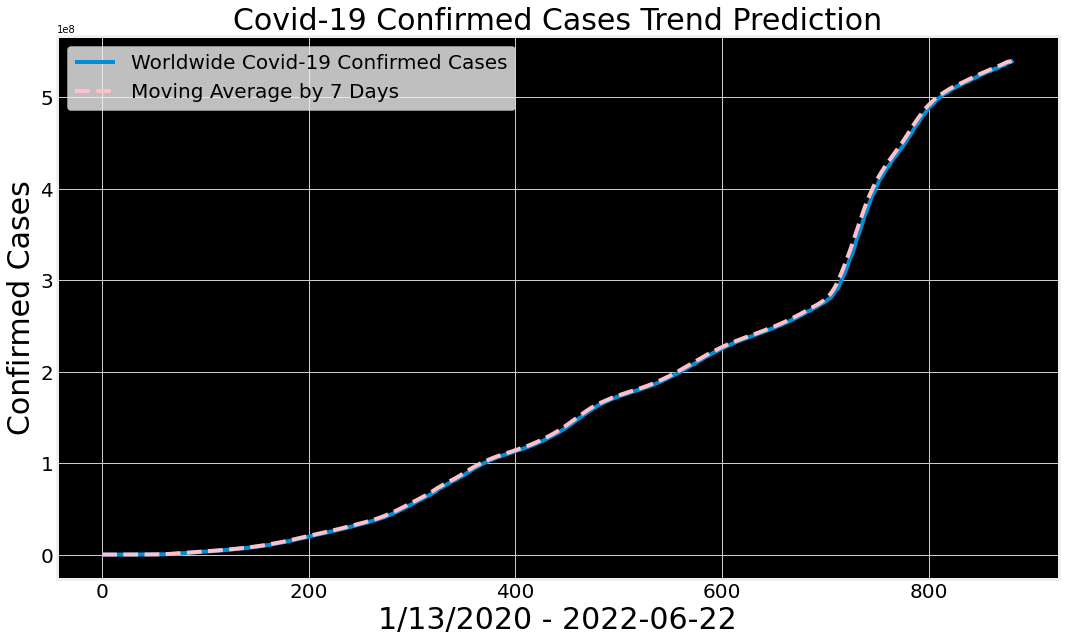

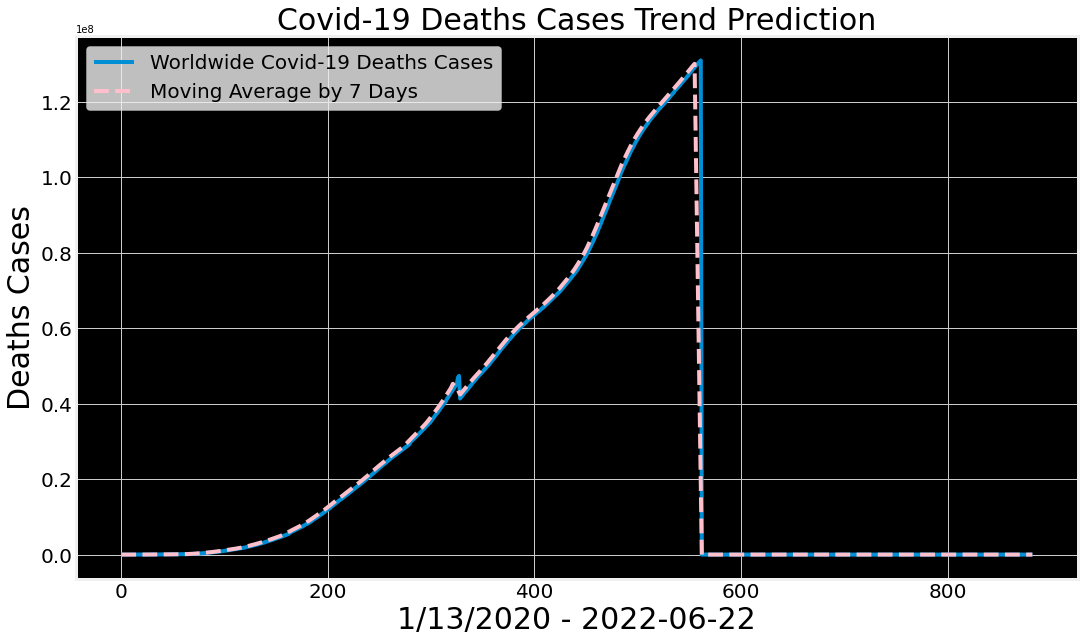

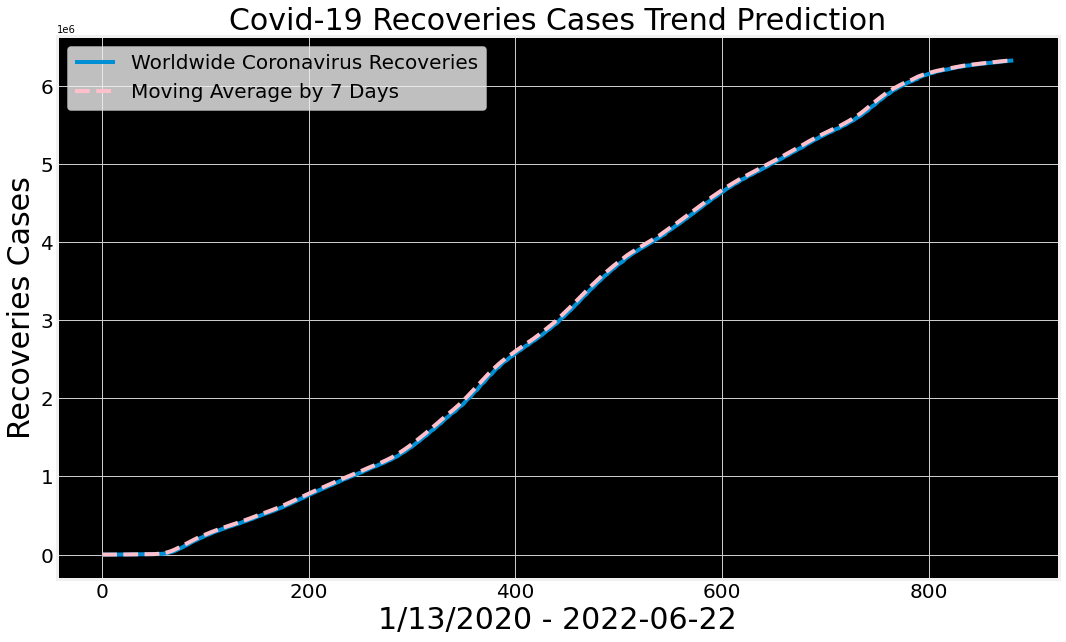

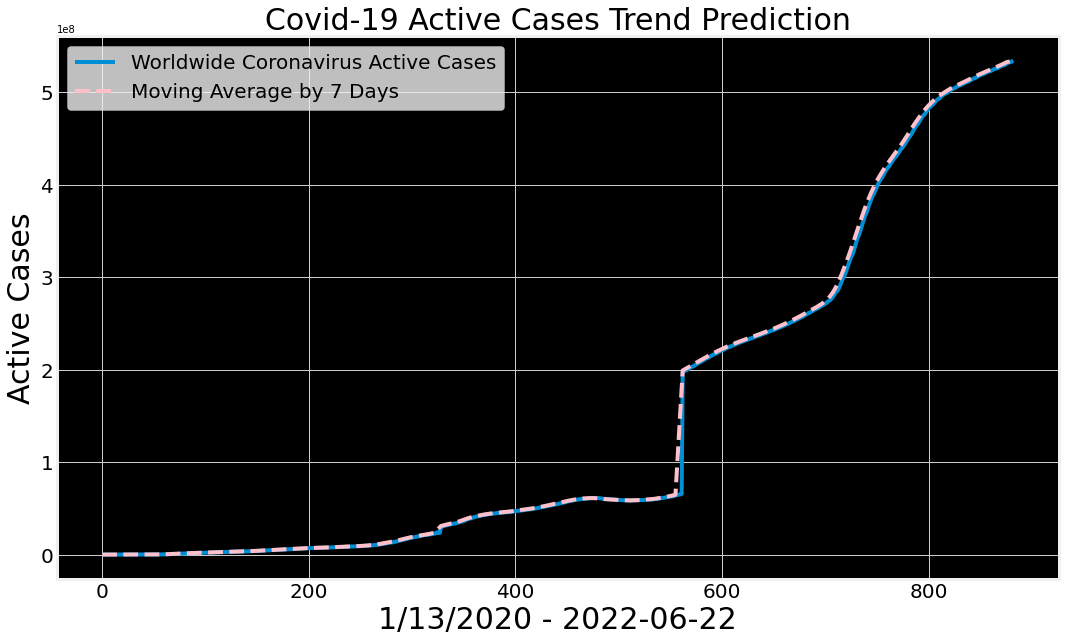

In [95]:
adjusted_dates = adjusted_dates.reshape(1, -1)[0]
xlabel_name="1/13/2020 - "+str(datetime.date.today())

# Setting the figure size
plt.figure(figsize=(16, 10))
# Setting the background color
ax = plt.axes()
ax.set_facecolor("black")
plt.plot(adjusted_dates, world_cases)
plt.plot(adjusted_dates, world_confirmed_avg, linestyle='dashed', color='pink')
plt.title('Covid-19 Confirmed Cases Trend Prediction', size=30)
plt.xlabel(xlabel_name, size=30)
plt.ylabel('Confirmed Cases', size=30)
plt.legend(['Worldwide Covid-19 Confirmed Cases', 'Moving Average by {} Days'.format(window)], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 10))
# Setting the background color
ax = plt.axes()
ax.set_facecolor("black")
plt.plot(adjusted_dates, total_deaths)
plt.plot(adjusted_dates, world_death_avg, linestyle='dashed', color='pink')
plt.title('Covid-19 Deaths Cases Trend Prediction', size=30)
plt.xlabel(xlabel_name, size=30)
plt.ylabel('Deaths Cases', size=30)
plt.legend(['Worldwide Covid-19 Deaths Cases', 'Moving Average by {} Days'.format(window)], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 10))
# Setting the background color
ax = plt.axes()
ax.set_facecolor("black")
plt.plot(adjusted_dates, total_recovered)
plt.plot(adjusted_dates, world_recovery_avg, linestyle='dashed', color='pink')
plt.title('Covid-19 Recoveries Cases Trend Prediction', size=30)
plt.xlabel(xlabel_name, size=30)
plt.ylabel('Recoveries Cases', size=30)
plt.legend(['Worldwide Coronavirus Recoveries', 'Moving Average by {} Days'.format(window)], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 10))
# Setting the background color
ax = plt.axes()
ax.set_facecolor("black")
plt.plot(adjusted_dates, total_active)
plt.plot(adjusted_dates, world_active_avg, linestyle='dashed', color='pink')
plt.title('Covid-19 Active Cases Trend Prediction', size=30)
plt.xlabel(xlabel_name, size=30)
plt.ylabel('Active Cases', size=30)
plt.legend(['Worldwide Coronavirus Active Cases', 'Moving Average by {} Days'.format(window)], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

# (5) 增加數的移動平均計算：
#1. 參數最佳化後預測數據：確診增加數。程式及續圖結果如下：
#2. 參數最佳化後預測數據：死亡增加數。程式及續圖結果如下：
#3. 參數最佳化後預測數據：復原增加數。程式及續圖結果如下：

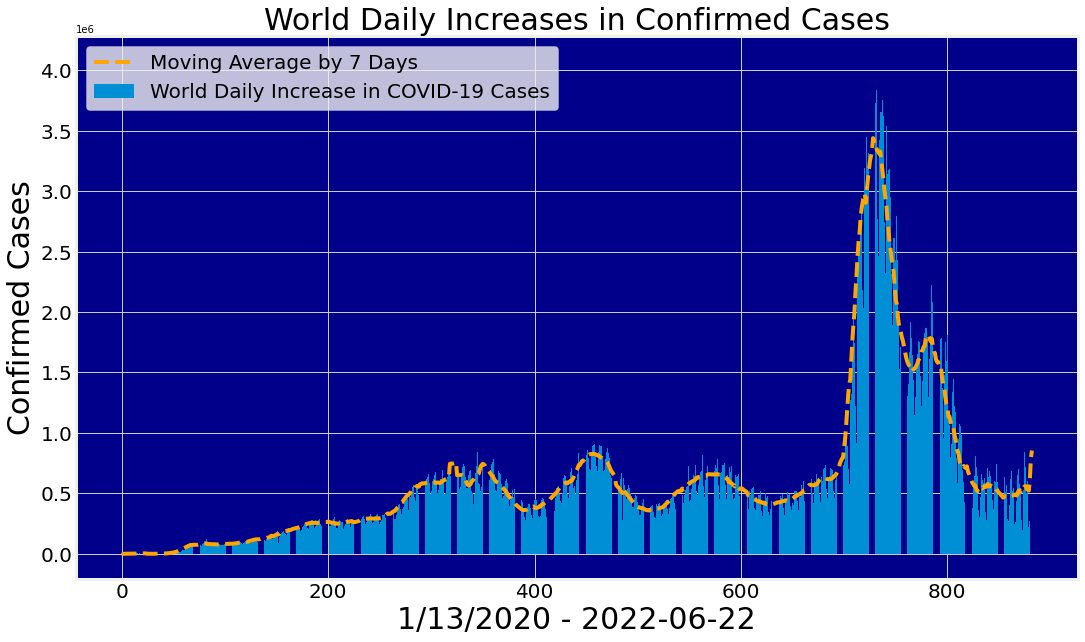

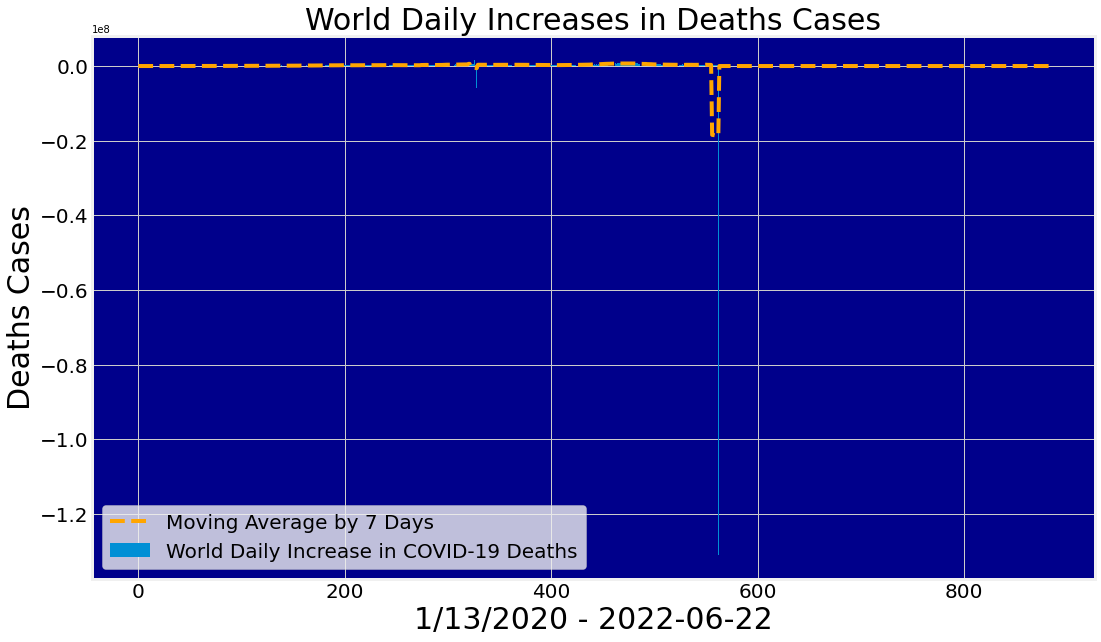

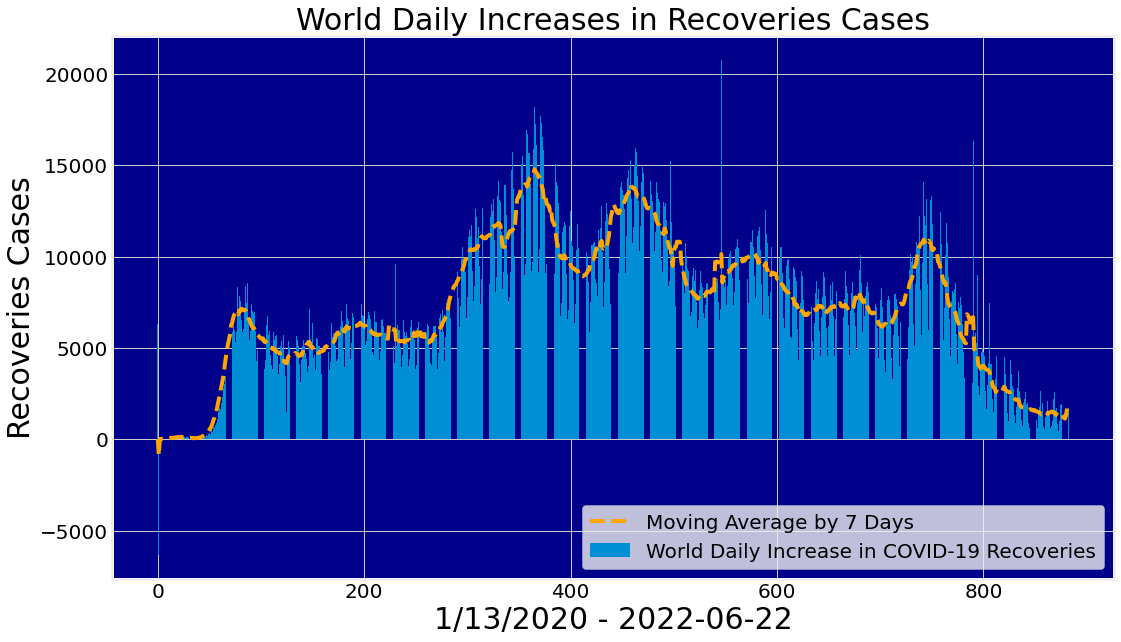

In [96]:
xlabel_name="1/13/2020 - "+str(datetime.date.today())

plt.figure(figsize=(16, 10))
# Setting the background color
ax = plt.axes()
ax.set_facecolor("darkblue")
plt.bar(adjusted_dates, world_daily_increase)
plt.plot(adjusted_dates, world_daily_increase_avg, color='orange', linestyle='dashed')
plt.title('World Daily Increases in Confirmed Cases', size=30)

plt.xlabel(xlabel_name, size=30)
plt.ylabel('Confirmed Cases', size=30)
plt.legend(['Moving Average by {} Days'.format(window), 'World Daily Increase in COVID-19 Cases'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 10))
# Setting the background color
ax = plt.axes()
ax.set_facecolor("darkblue")
plt.bar(adjusted_dates, world_daily_death)
plt.plot(adjusted_dates, world_daily_death_avg, color='orange', linestyle='dashed')
plt.title('World Daily Increases in Deaths Cases', size=30)
plt.xlabel(xlabel_name, size=30)
plt.ylabel('Deaths Cases', size=30)
plt.legend(['Moving Average by {} Days'.format(window), 'World Daily Increase in COVID-19 Deaths'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 10))
# Setting the background color
ax = plt.axes()
ax.set_facecolor("darkblue")
plt.bar(adjusted_dates, world_daily_recovery)
plt.plot(adjusted_dates, world_daily_recovery_avg, color='orange', linestyle='dashed')
plt.title('World Daily Increases in Recoveries Cases', size=30)
plt.xlabel(xlabel_name, size=30)
plt.ylabel('Recoveries Cases', size=30)
plt.legend(['Moving Average by {} Days'.format(window), 'World Daily Increase in COVID-19 Recoveries'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

# (6)模型驗證：

In [97]:
#LOG分析結果如下：
#1. LOG轉換後預測：確診人數。程式及續圖結果如下：
#2. LOG轉換後預測：死亡人數。程式及續圖結果如下：

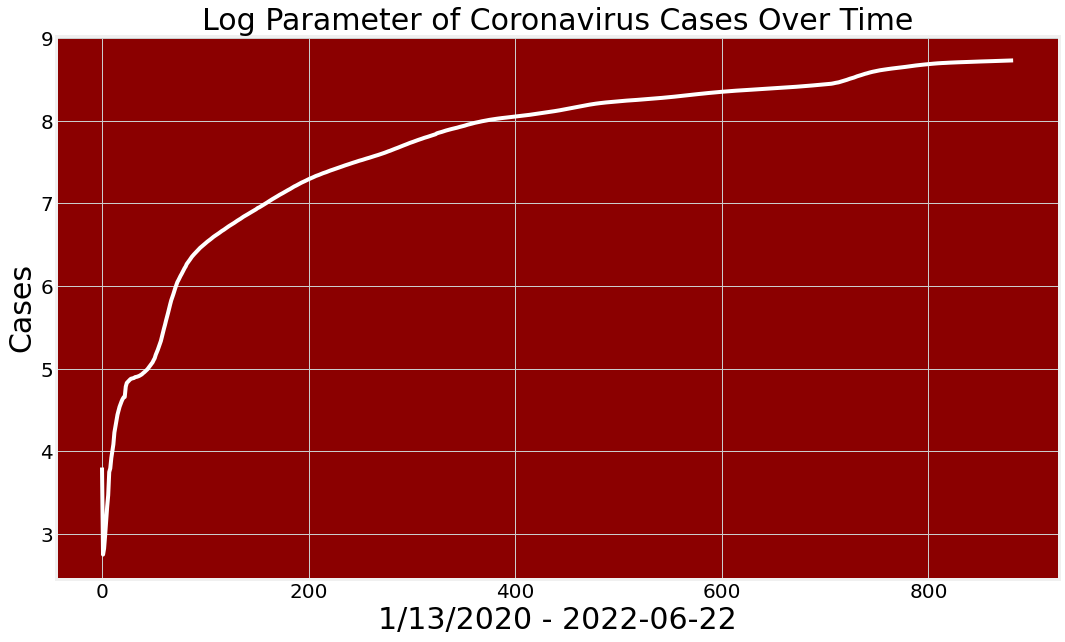

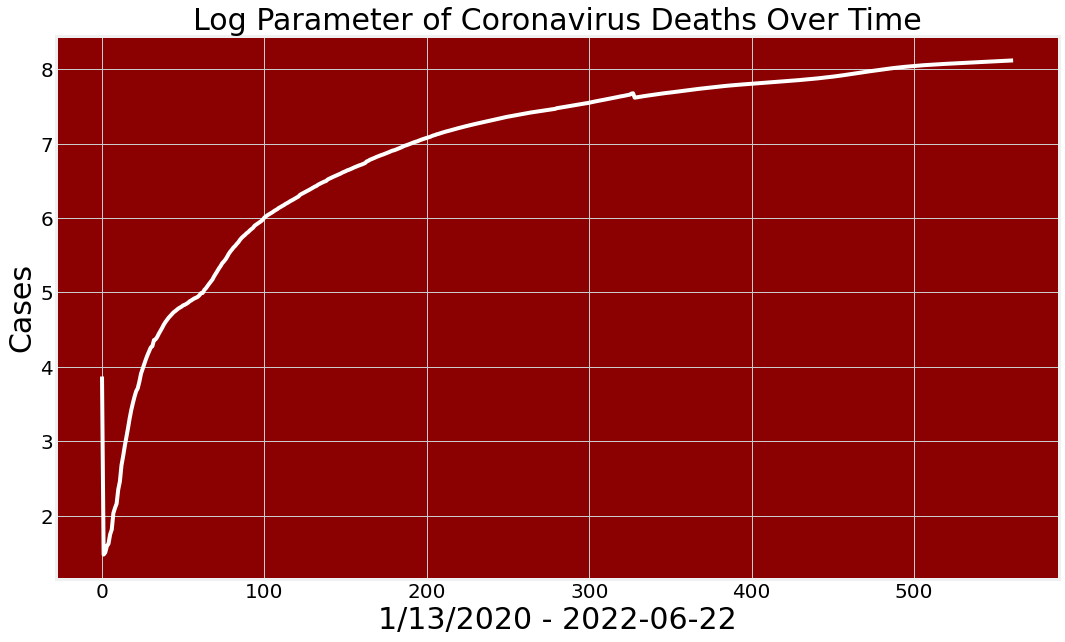

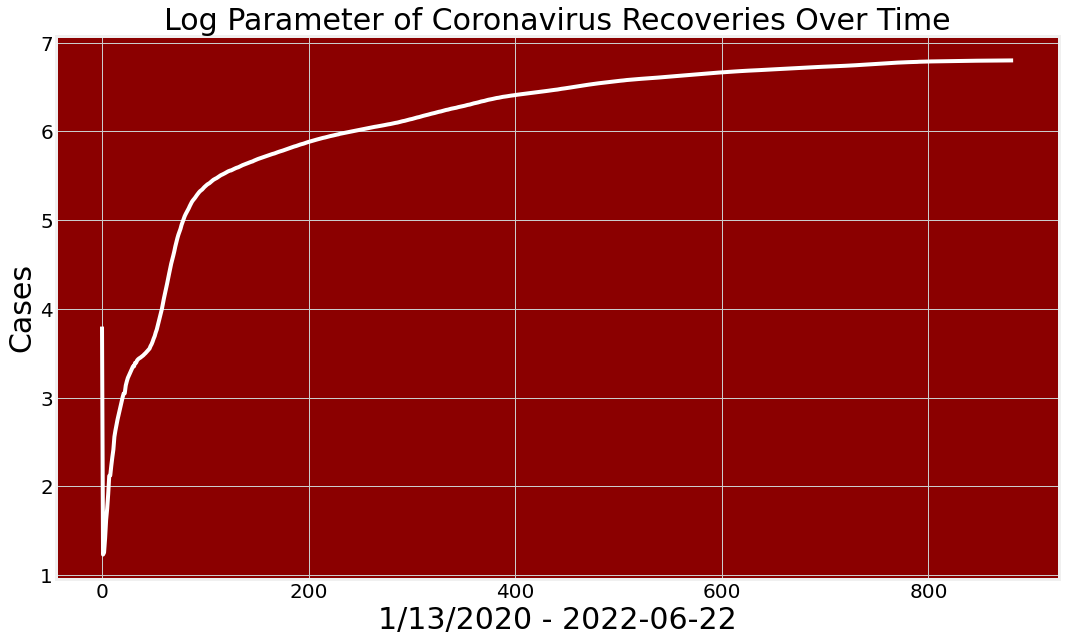

In [98]:
xlabel_name="1/13/2020 - "+str(datetime.date.today())

plt.figure(figsize=(16, 10))
# Setting the background color
ax = plt.axes()
ax.set_facecolor("darkred")

plt.plot(adjusted_dates, np.log10(world_cases),color='white')
plt.title('Log Parameter of Coronavirus Cases Over Time', size=30)
plt.xlabel(xlabel_name, size=30)
plt.ylabel('Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 10))
# Setting the background color
ax = plt.axes()
ax.set_facecolor("darkred")

plt.plot(adjusted_dates, np.log10(total_deaths),color='white')
plt.title('Log Parameter of Coronavirus Deaths Over Time', size=30)
plt.xlabel(xlabel_name, size=30)
plt.ylabel('Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 10))
# Setting the background color
ax = plt.axes()
ax.set_facecolor("darkred")

plt.plot(adjusted_dates, np.log10(total_recovered),color='white')
plt.title('Log Parameter of Coronavirus Recoveries Over Time', size=30)
plt.xlabel(xlabel_name, size=30)
plt.ylabel('Cases',size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [99]:
#經過上面的演算，重新把我們關心的幾個國家，重新根據最新WHO資料，預測一下未來確診數，死亡數，復原數等。程式如下：
#1. 設定確診人數圖，及死亡人數圖的各項參數。
#2. 設定死亡人數圖，及平均移動圖的各項參數。
#3. 設定繪圖子函數(country_visualization)：用迴圈將數據資料擷取出來。

In [100]:
def country_plot(x, y1, y2, y3, y4, country):
    xlabel_name="Total Stats days from 1/22/2020 - "+str(datetime.date.today())
    # window is set as 14 in in the beginning of the notebook 
    confirmed_avg = moving_average(y1, window)
    confirmed_increase_avg = moving_average(y2, window)
    death_increase_avg = moving_average(y3, window)
    recovery_increase_avg = moving_average(y4, window)
    
    plt.figure(figsize=(16, 10))
    # Setting the background color
    ax = plt.axes()
    ax.set_facecolor("pink")
    plt.plot(x, y1)
    plt.plot(x, confirmed_avg, color='red', linestyle='dashed')
    plt.legend(['{} Confirmed Cases'.format(country), 'Moving Average {} Days'.format(window)], prop={'size': 20})
    plt.title('{} Confirmed Cases'.format(country), size=30)
    plt.xlabel(xlabel_name, size=20)
    plt.ylabel('Cases', size=20)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

    plt.figure(figsize=(16, 10))
    # Setting the background color
    ax = plt.axes()
    ax.set_facecolor("orange")
    plt.bar(x, y2)
    plt.plot(x, confirmed_increase_avg, color='red', linestyle='dashed')
    plt.legend(['Moving Average {} Days'.format(window), '{} Daily Increase in Confirmed Cases'.format(country)], prop={'size': 20})
    plt.title('{} Daily Increases in Confirmed Cases'.format(country), size=30)
    plt.xlabel(xlabel_name, size=20)
    plt.ylabel('Cases', size=20)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

    plt.figure(figsize=(16, 10))
    # Setting the background color
    ax = plt.axes()
    ax.set_facecolor("yellow")
    plt.bar(x, y3)
    plt.plot(x, death_increase_avg, color='red', linestyle='dashed')
    plt.legend(['Moving Average {} Days'.format(window), '{} Daily Increase in Confirmed Deaths'.format(country)], prop={'size': 20})
    plt.title('{} Daily Increases in Deaths'.format(country), size=30)
    plt.xlabel(xlabel_name, size=20)
    plt.ylabel('Cases', size=20)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

    plt.figure(figsize=(16, 10))
    # Setting the background color
    ax = plt.axes()
    ax.set_facecolor("white")
    plt.bar(x, y4)
    plt.plot(x, recovery_increase_avg, color='red', linestyle='dashed')
    plt.legend(['Moving Average {} Days'.format(window), '{} Daily Increase in Confirmed Recoveries'.format(country)], prop={'size': 20})
    plt.title('{} Daily Increases in Recoveries'.format(country), size=30)
    plt.xlabel(xlabel_name, size=20)
    plt.ylabel('Cases', size=20)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()
      
# 子函數：按國家名繪圖        
def get_country_info(country_name):
    country_cases = []
    country_deaths = []
    country_recoveries = []  
    
    for i in dates:
        country_cases.append(confirmed_df[confirmed_df['Country/Region']==country_name][i].sum())
        country_deaths.append(deaths_df[deaths_df['Country/Region']==country_name][i].sum())
        country_recoveries.append(recoveries_df[recoveries_df['Country/Region']==country_name][i].sum())
    return (country_cases, country_deaths, country_recoveries)
    
    
def country_visualizations(country_name):
    country_info = get_country_info(country_name)
    country_cases = country_info[0]
    country_deaths = country_info[1]
    country_recoveries = country_info[2]
    
    country_daily_increase = daily_increase(country_cases)
    country_daily_death = daily_increase(country_deaths)
    country_daily_recovery = daily_increase(country_recoveries)
    
    country_plot(adjusted_dates, country_cases, country_daily_increase, country_daily_death, country_daily_recovery, country_name)
    

In [101]:
#Country Specific Graphs

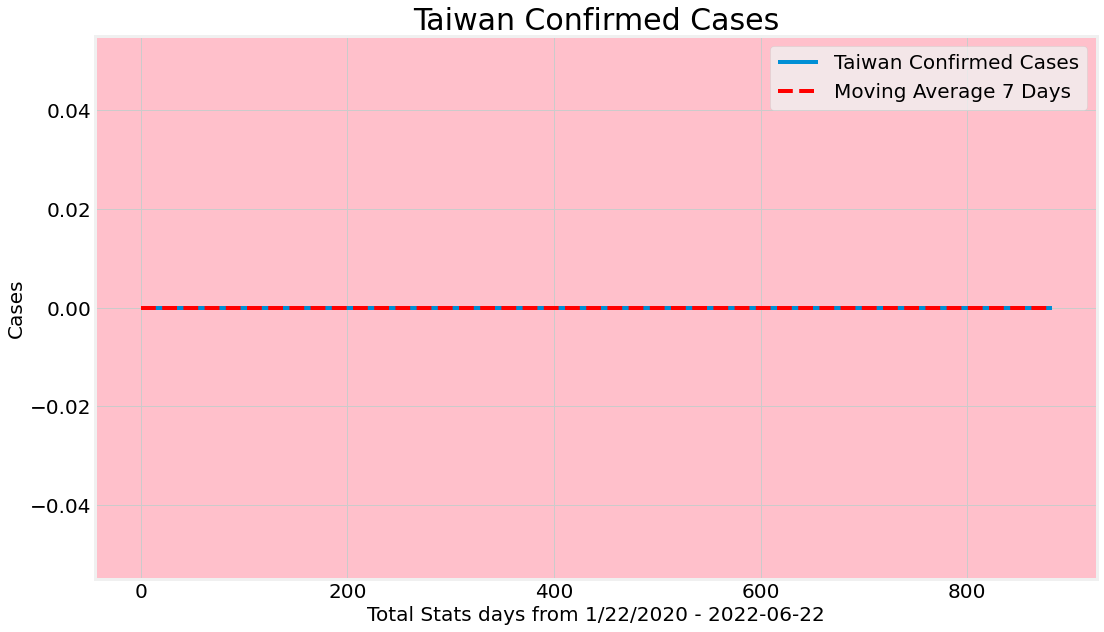

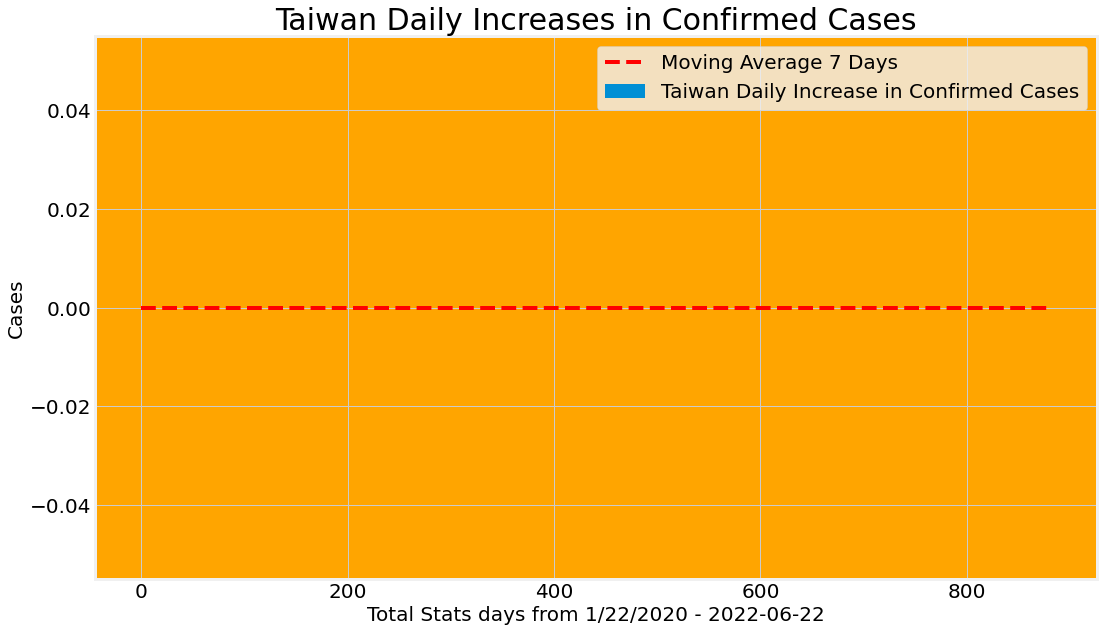

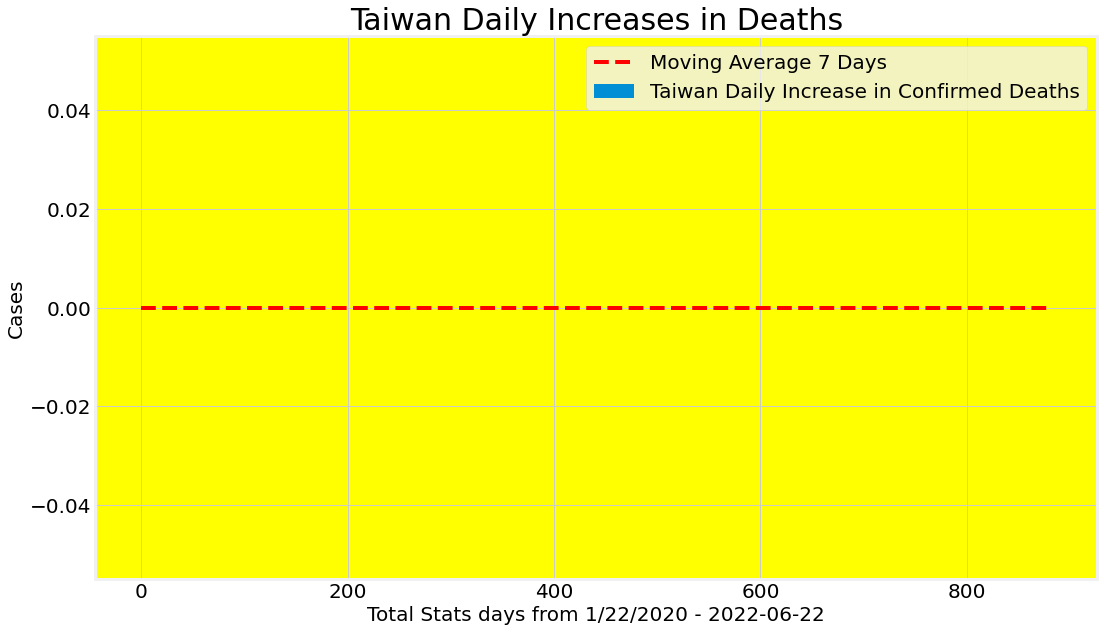

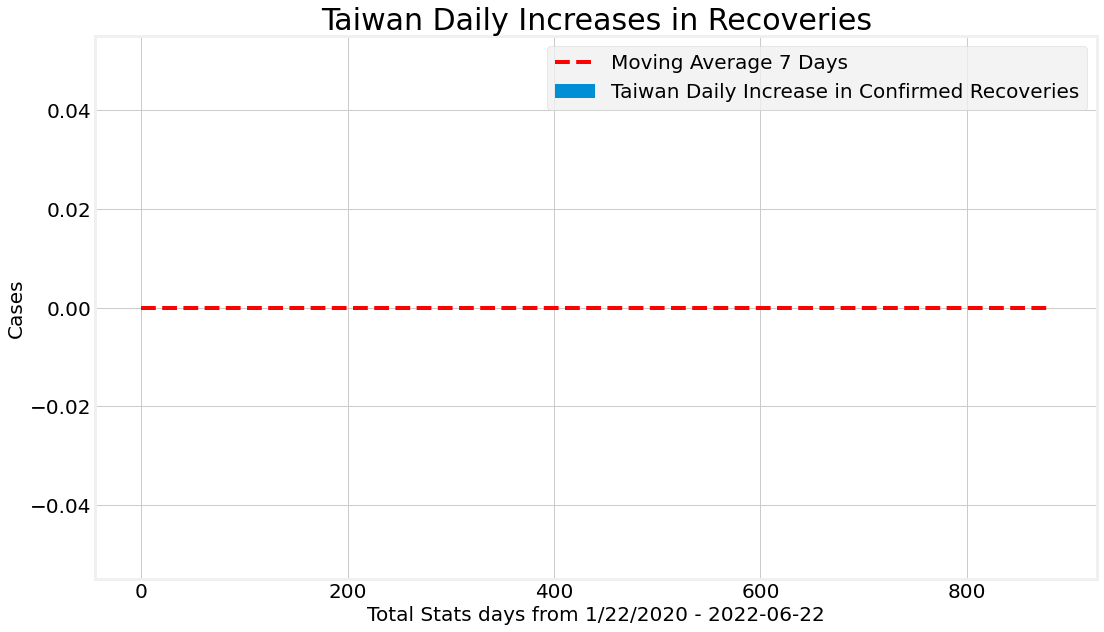

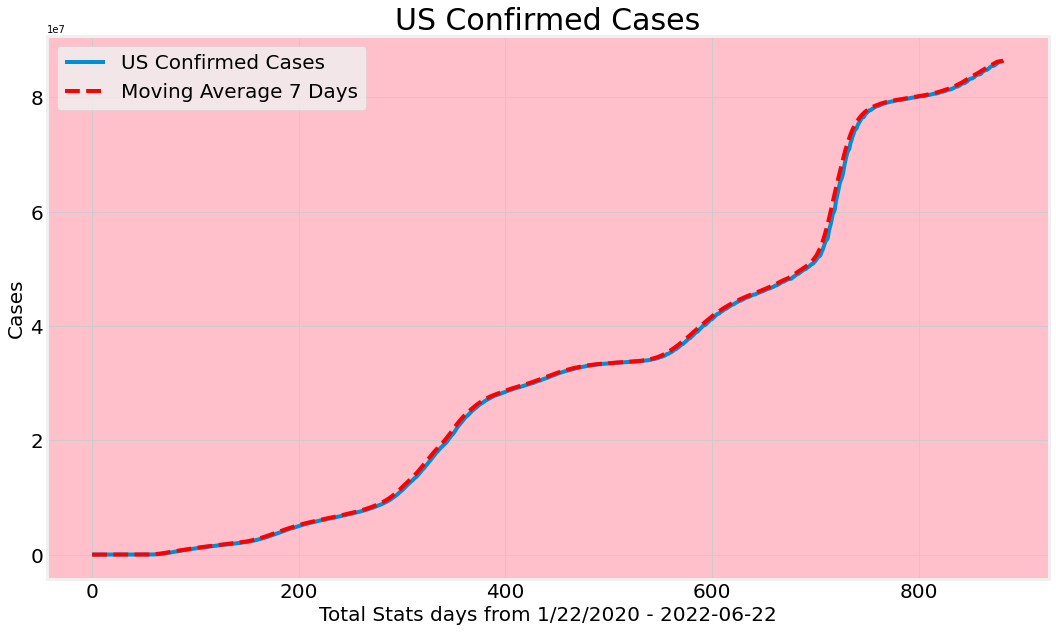

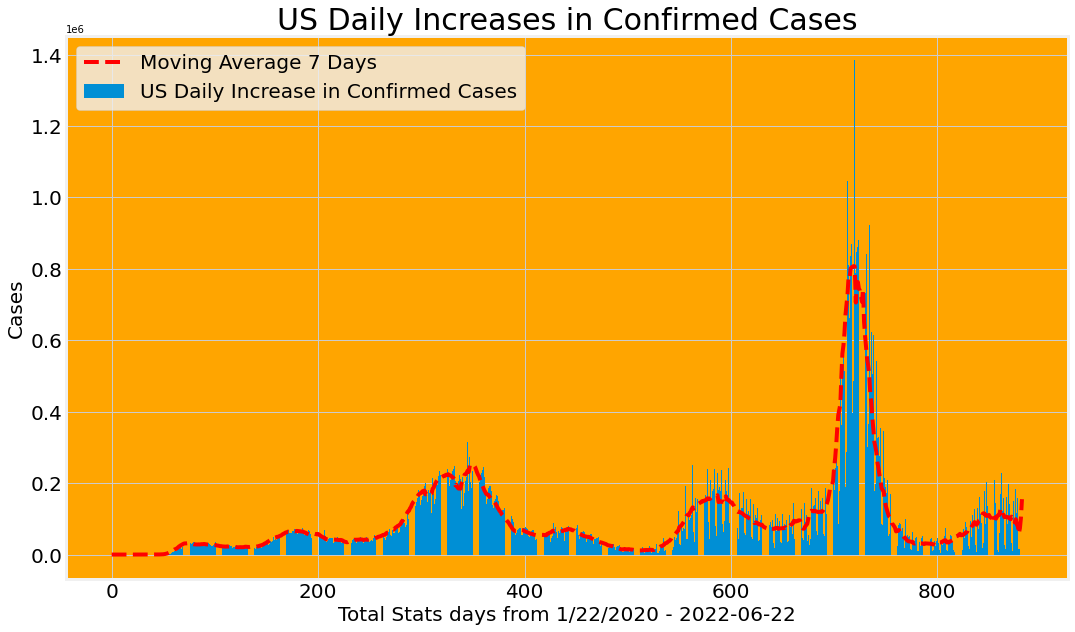

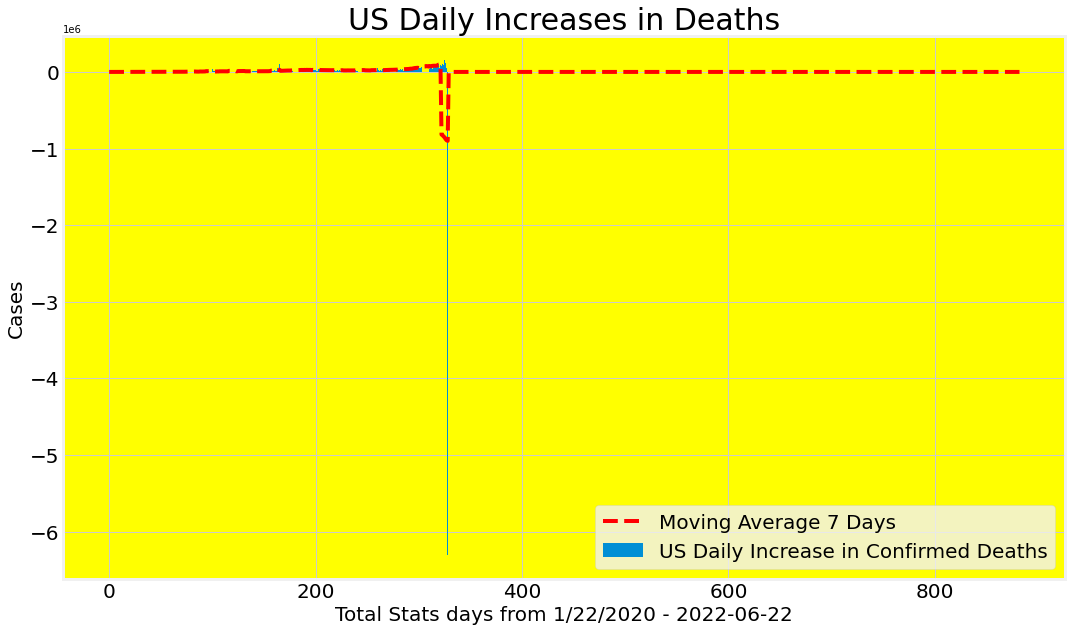

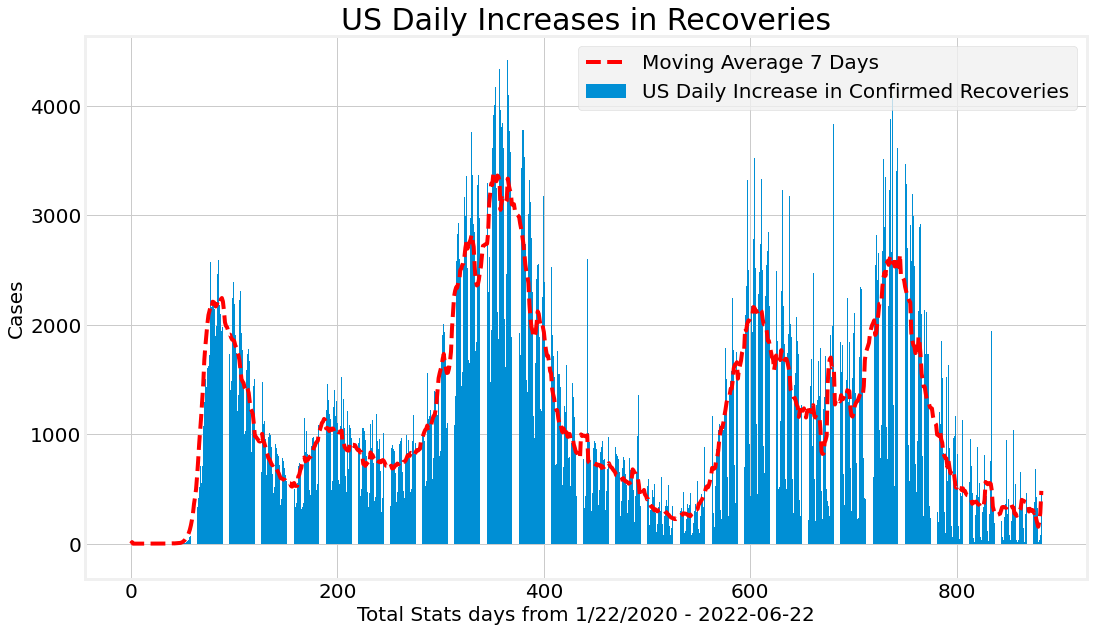

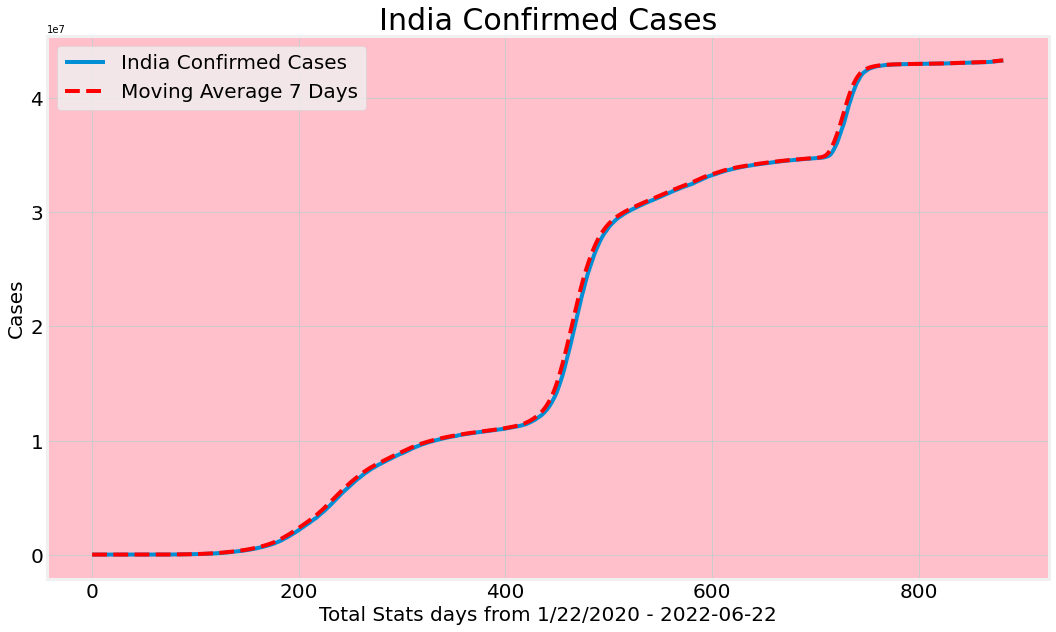

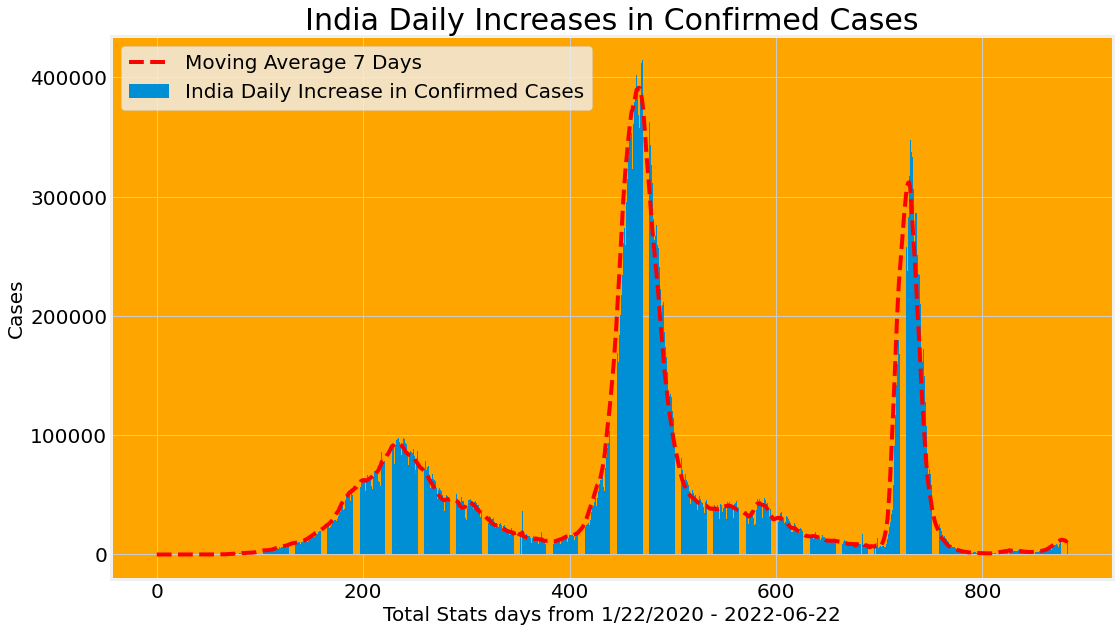

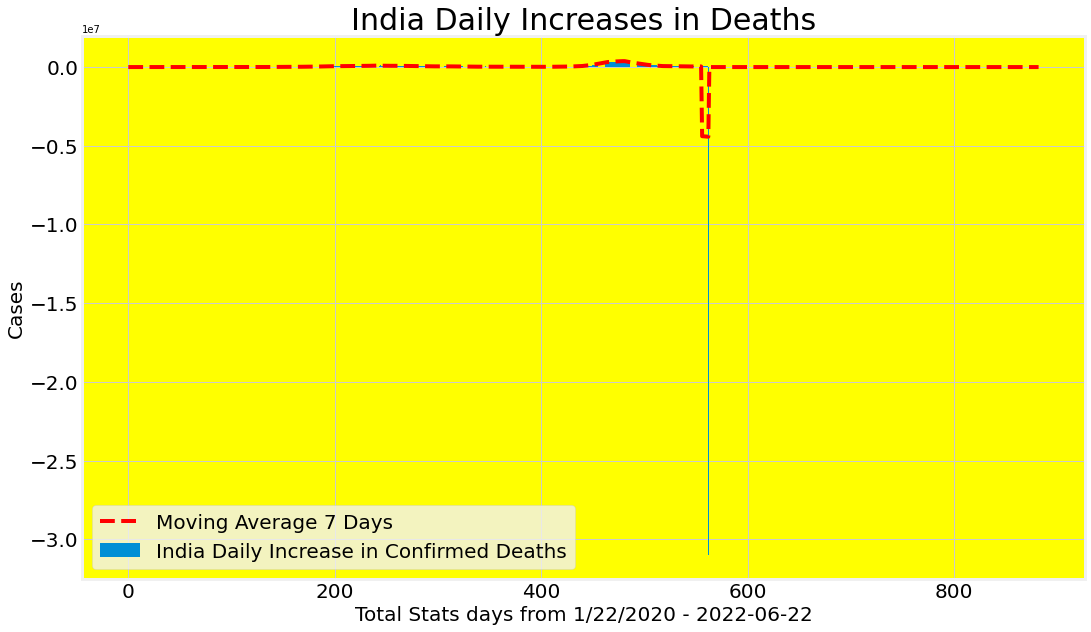

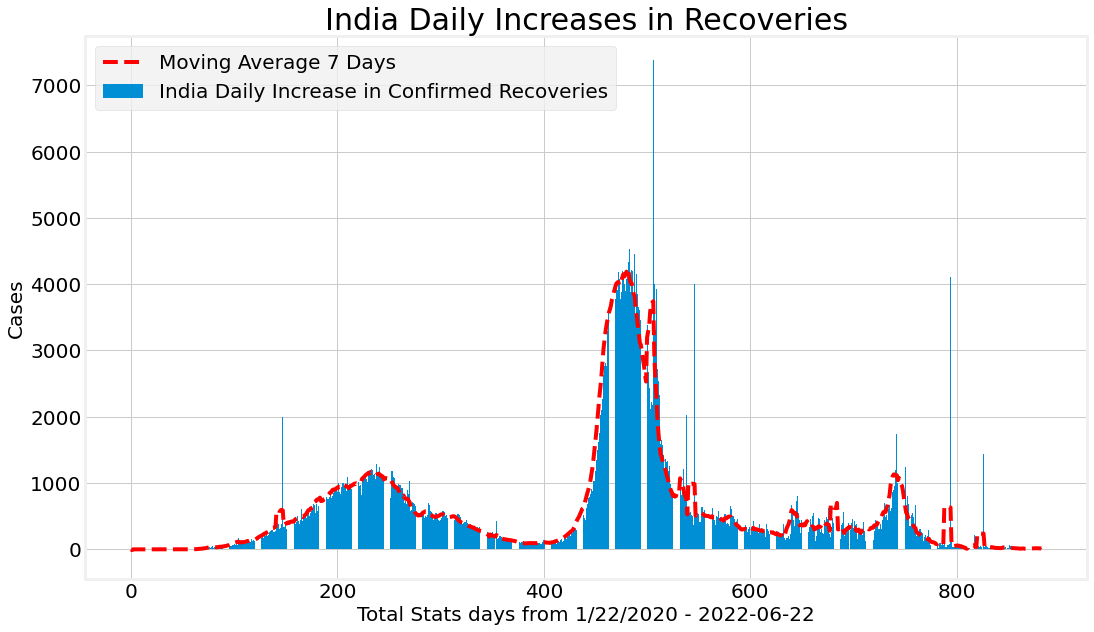

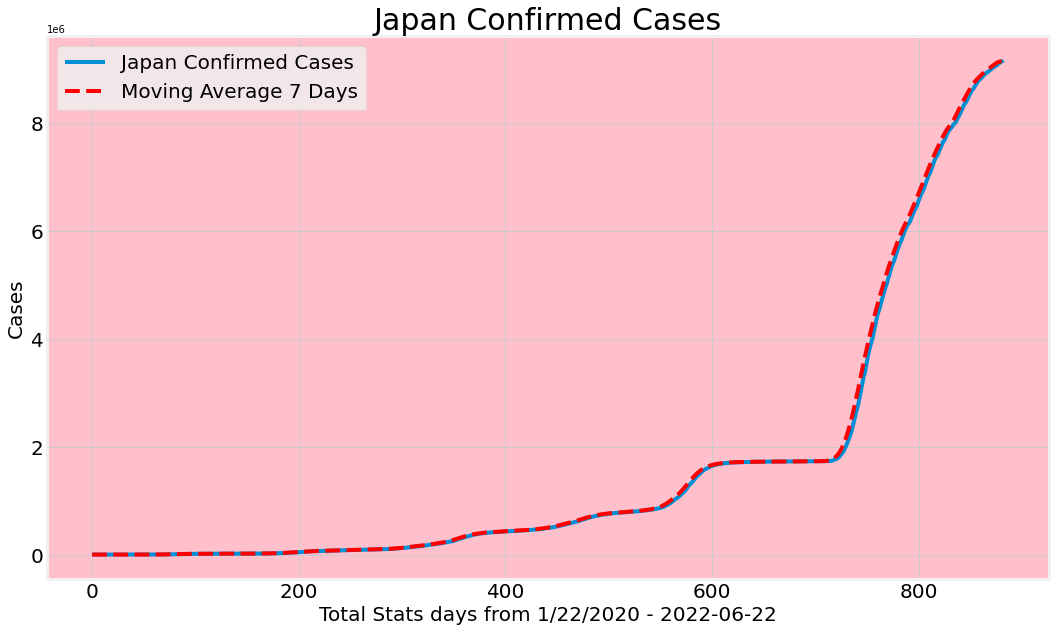

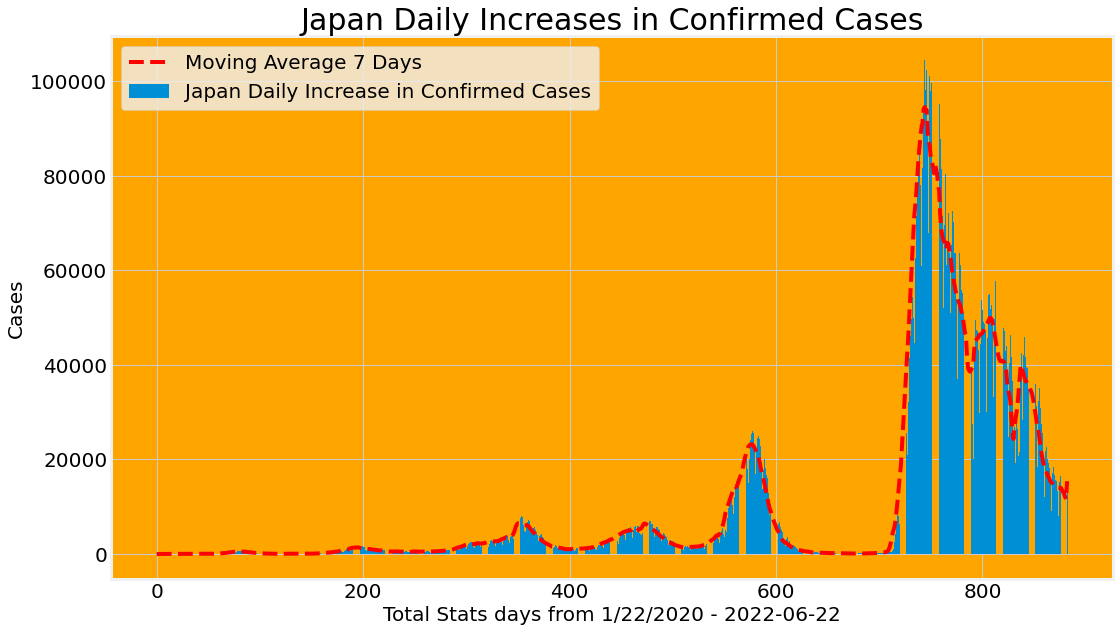

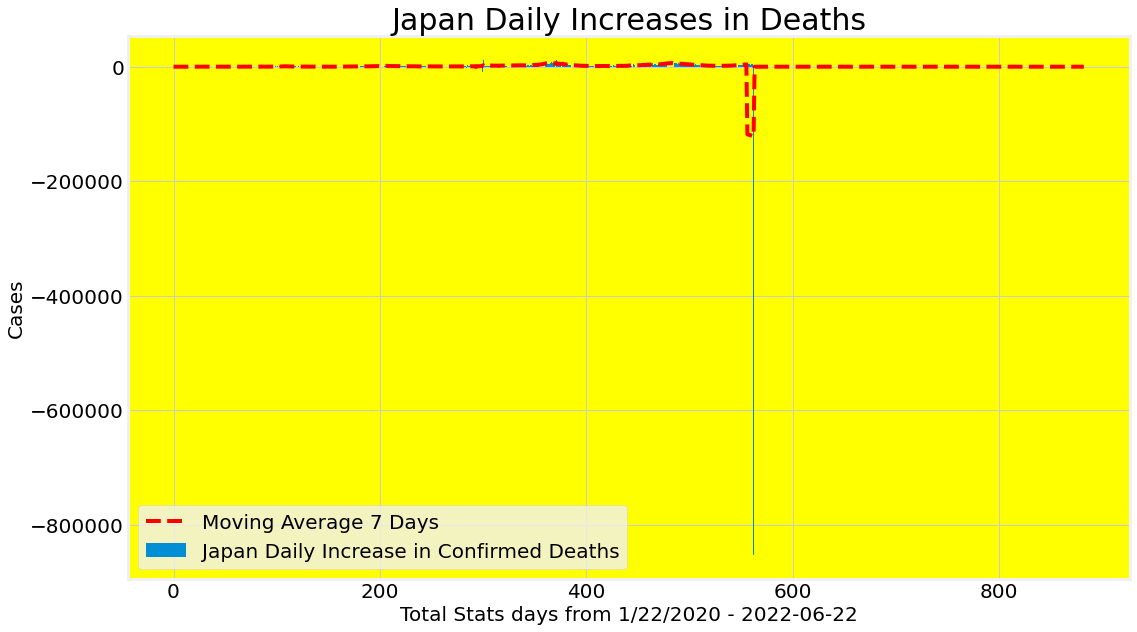

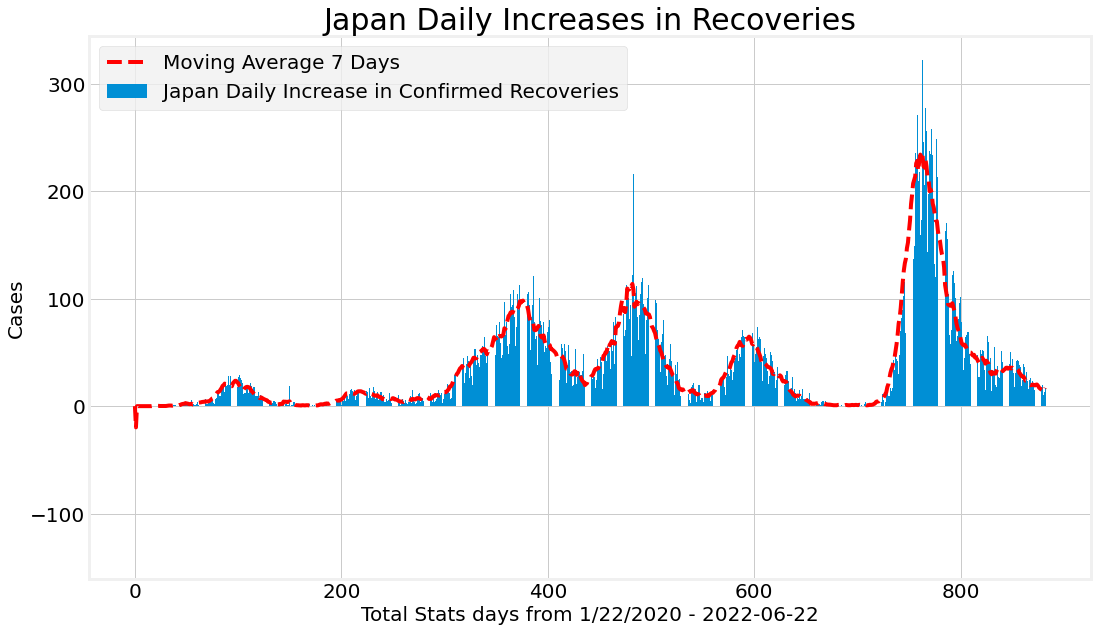

In [102]:
countries = ['Taiwan','US','India','Japan'] 

for country in countries:
    country_visualizations(country)

# 6. 交叉驗證：

將不同國家(美國，巴西，印度，俄羅斯，南非)放在一起看。程式及繪圖結果如下：

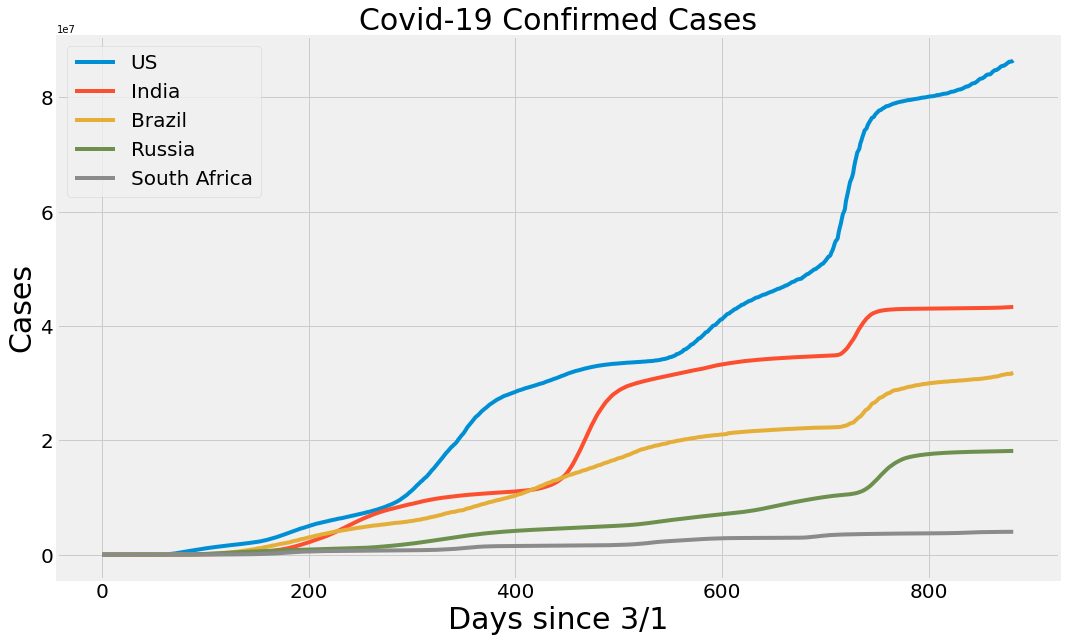

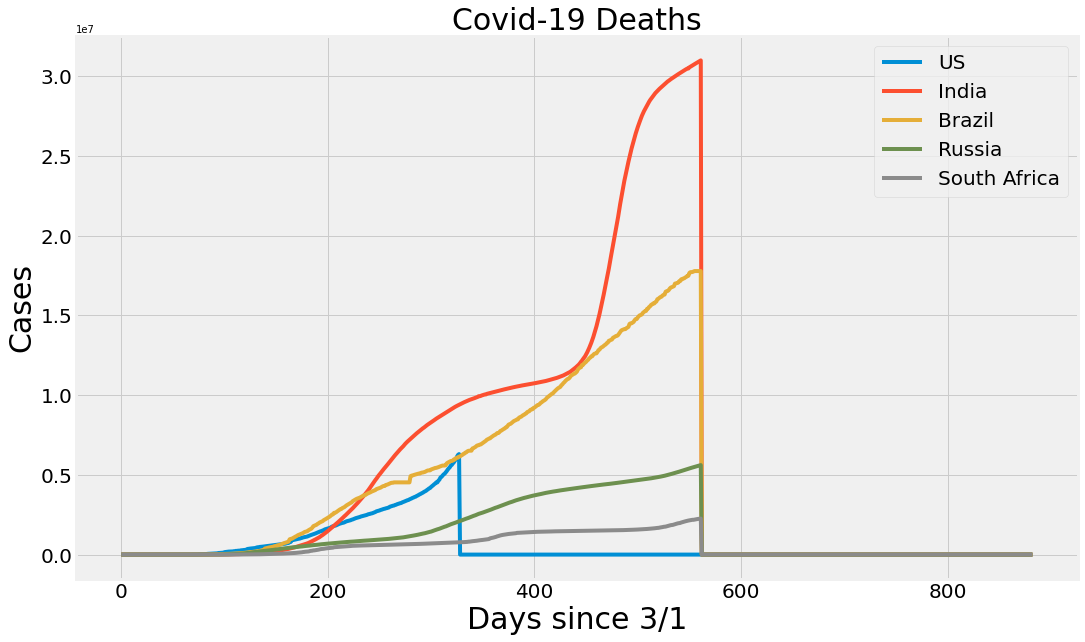

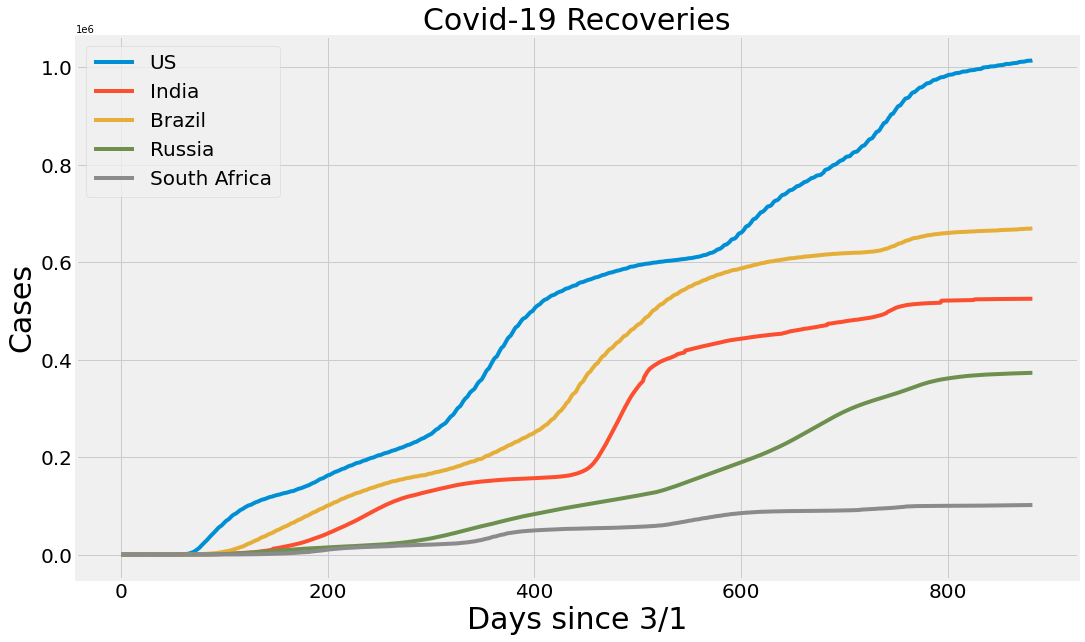

In [103]:
xlabel_name="Total Stats days from 1/13/2020 - "+str(datetime.date.today())
compare_countries = ['US','India','Brazil', 'Russia', 'South Africa'] 
graph_name = ['Covid-19 Confirmed Cases', 'Covid-19 Deaths', 'Covid-19 Recoveries']

for num in range(3):
    plt.figure(figsize=(16, 10))
    # removed redundant code
    for country in compare_countries:
        plt.plot(get_country_info(country)[num])
    plt.legend(compare_countries, prop={'size': 20})
    plt.xlabel('Days since 3/1', size=30)
    plt.ylabel('Cases', size=30)
    plt.title(graph_name[num], size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

# 7. 超前預測－參數最佳化：

用三種迴歸演算計算未來疫情，程式如下：

In [105]:
xlabel_name="Total Stats days from 1/13/2020 - "+str(datetime.date.today())

def plot_predictions(x, y, pred, algo_name, color):
    plt.figure(figsize=(16, 10))
    
    plt.plot(x, y)
    plt.plot(future_forcast, pred, linestyle='dashed', color=color)
    plt.title('Worldwide Covid-19 Cofirmed Cases', size=30)
    plt.xlabel(xlabel_name, size=30)
    plt.ylabel('Cases', size=30)
    plt.legend(['Confirmed Cases', algo_name], prop={'size': 20})
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

In [106]:
#(1) SVM(support vector machine)「支援向量機器」：

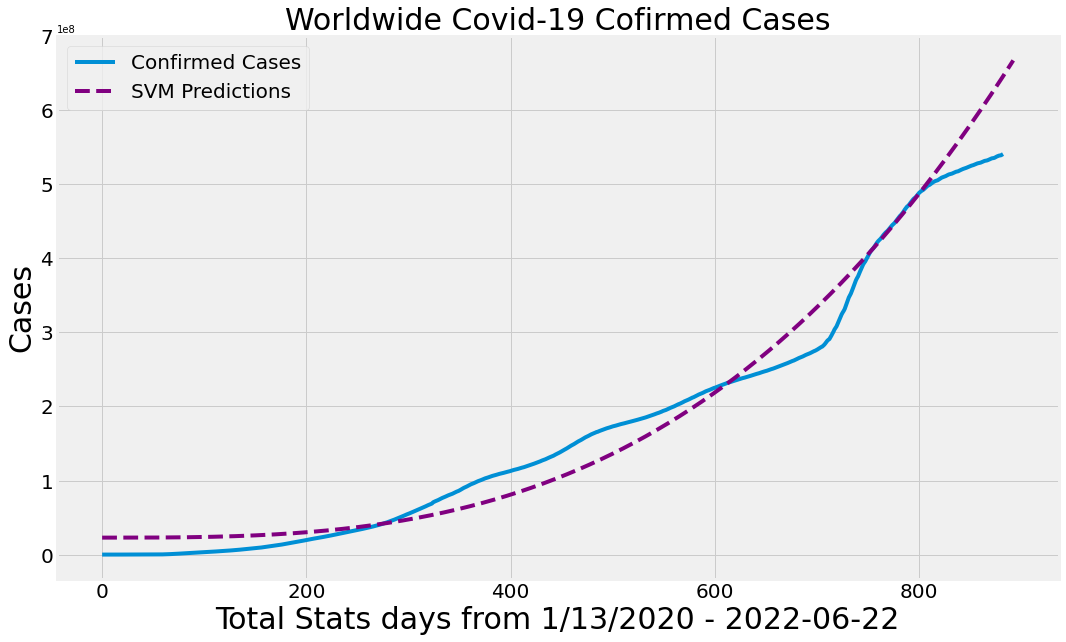

In [107]:
plot_predictions(adjusted_dates, world_cases, svm_pred, 'SVM Predictions', 'purple')

In [108]:
#(2) Polynomial Regression Predictions「多項式回歸」：預測全球Covid-19全球確診人數，程式和繪圖結果如下。

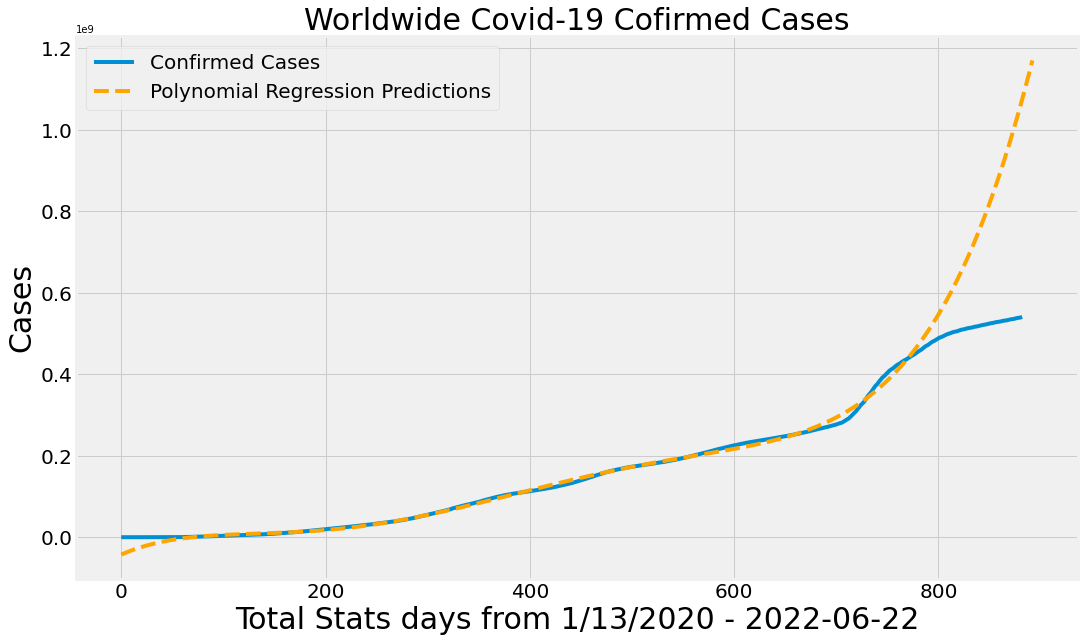

In [109]:
plot_predictions(adjusted_dates, world_cases, linear_pred, 'Polynomial Regression Predictions', 'orange')

In [110]:
#(3)Bayesian Ridge Regression「貝葉斯線性迴歸」：程式和繪圖結果如下。預測全球Covid-19全球確診人數，程式和繪圖結果如下。

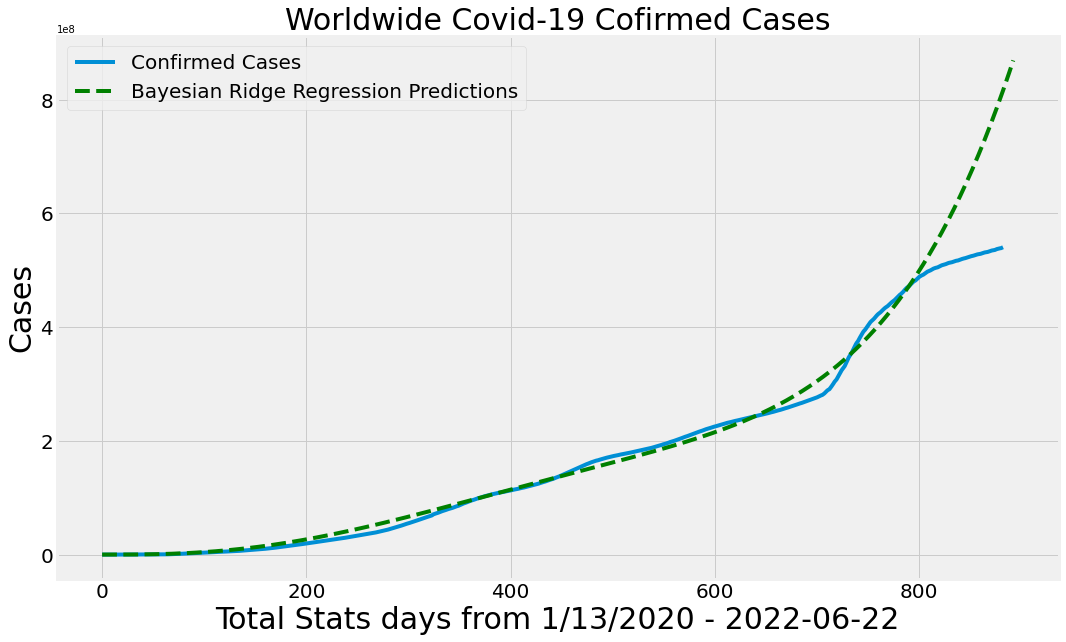

In [111]:
plot_predictions(adjusted_dates, world_cases, bayesian_pred, 'Bayesian Ridge Regression Predictions', 'green')

# 8. 超前預測-視覺化：

用三種迴歸演算計算未來疫情，用漸層色的深淺來表示人數，人數越多色越深，程式如下：

In [112]:
#(1) SVM(support vector machine)「支援向量機器」：程式和繪圖結果如下。
svm_df = pd.DataFrame({'Date': future_forcast_dates[-10:], '[SVM] Predicted the Confirmed Cases Worldwide': np.round(svm_pred[-10:])})
svm_df.style.background_gradient(cmap='Blues')

In [113]:
#(2) Polynomial Regression Predictions「多項式回歸」：程式和繪圖結果如下。

In [114]:
linear_pred = linear_pred.reshape(1,-1)[0]
linear_df = pd.DataFrame({'Date': future_forcast_dates[-10:], '[Polynomial] Predicted Confirmed Cases Worldwide': np.round(linear_pred[-10:])})
linear_df.style.background_gradient(cmap='Reds')

In [115]:
 #(3) Bayesian Ridge Regression「貝葉斯線性迴歸」：程式和繪圖結果如下。

In [116]:
bayesian_df = pd.DataFrame({'Date': future_forcast_dates[-10:], '[Bayesian Ridge] Predicted Confirmed Cases Worldwide': np.round(bayesian_pred[-10:])})
bayesian_df.style.background_gradient(cmap='Greens')

# 9. 超前預測-全球總計:用三種迴歸演算計算未來疫情
(1) 全球Covid－19確診後之死亡率：程式與繪圖結果。

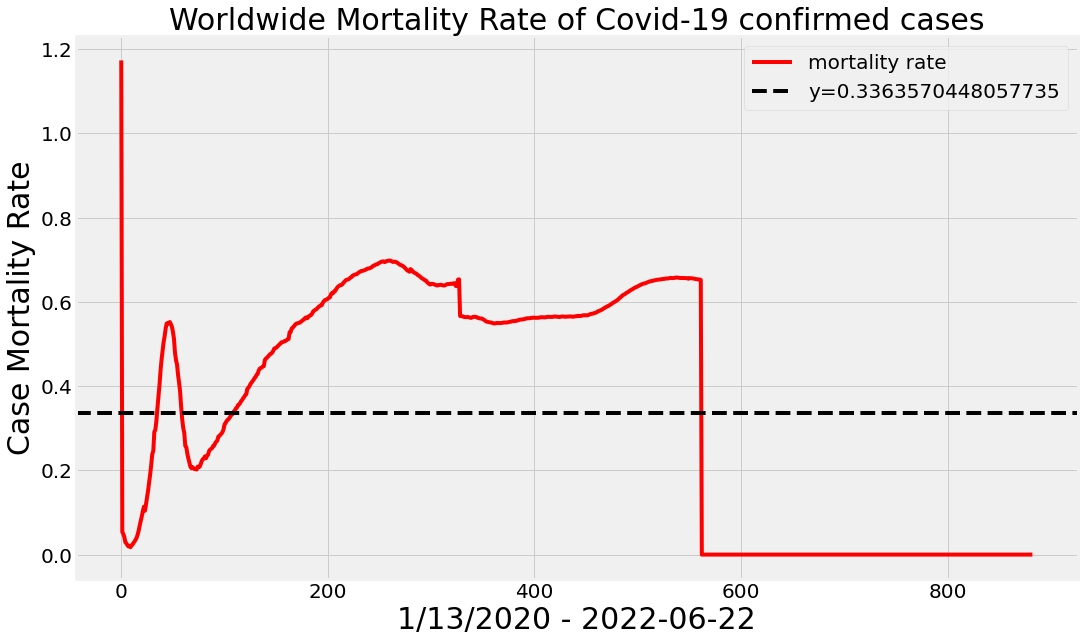

In [117]:
xlabel_name="1/13/2020 - "+str(datetime.date.today())
mean_mortality_rate = np.mean(mortality_rate)
plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, mortality_rate, color='red')
plt.axhline(y = mean_mortality_rate,linestyle='--', color='black') #在平均值畫一條水平線
plt.title('Worldwide Mortality Rate of Covid-19 confirmed cases', size=30)
plt.legend(['mortality rate', 'y='+str(mean_mortality_rate)], prop={'size': 20})
plt.xlabel(xlabel_name, size=30)
plt.ylabel('Case Mortality Rate', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [118]:
#(2) 全球Covid－19確診後之復原率：程式與繪圖結果。

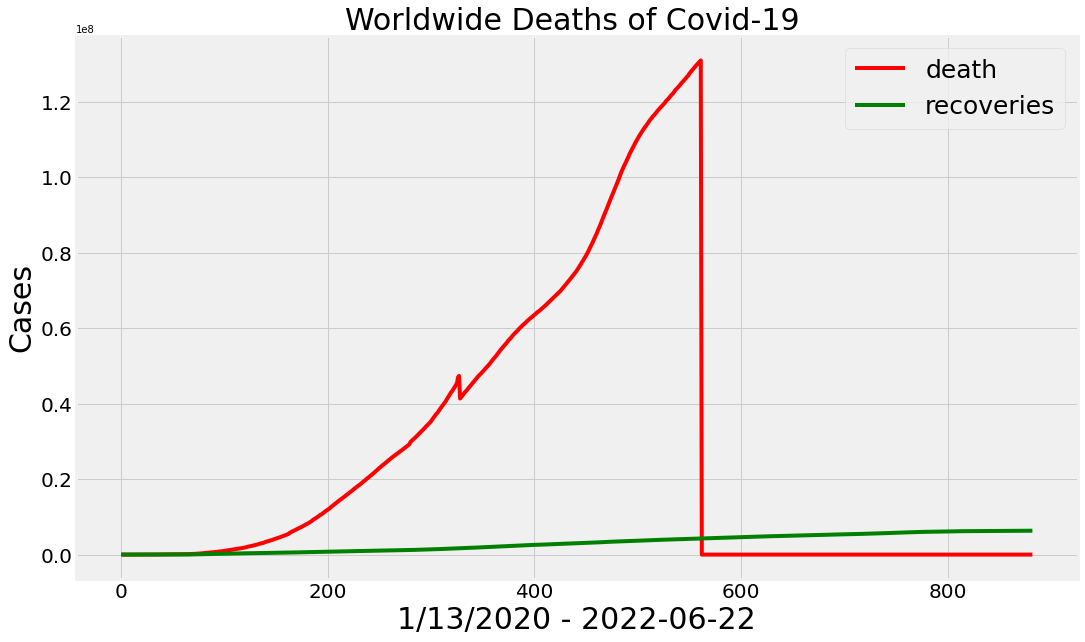

In [119]:
xlabel_name="1/13/2020 - "+str(datetime.date.today())
plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, total_deaths, color='r')
plt.plot(adjusted_dates, total_recovered, color='green')
plt.legend(['death', 'recoveries'], loc='best', fontsize=25)
plt.title('Worldwide Deaths of Covid-19 ', size=30)
plt.xlabel(xlabel_name, size=30)
plt.ylabel('Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [120]:
#(3) 全球Covid－19死亡率及復原率比較圖：程式與繪圖結果。

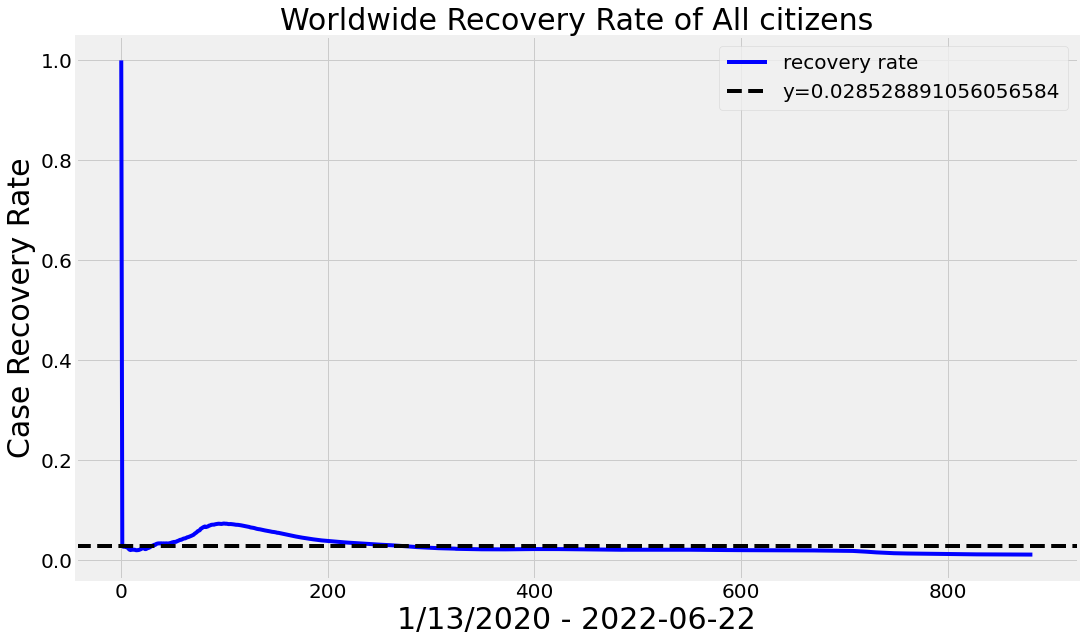

In [121]:
xlabel_name="1/13/2020 - "+str(datetime.date.today())
mean_recovery_rate = np.mean(recovery_rate)
plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, recovery_rate, color='blue')
plt.axhline(y = mean_recovery_rate,linestyle='--', color='black')
plt.title('Worldwide Recovery Rate of All citizens', size=30)
plt.legend(['recovery rate', 'y='+str(mean_recovery_rate)], prop={'size': 20})
plt.xlabel(xlabel_name, size=30)
plt.ylabel('Case Recovery Rate', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [122]:
#(4) 全球Covid－19死亡率及復原率比較圖：程式與繪圖結果。

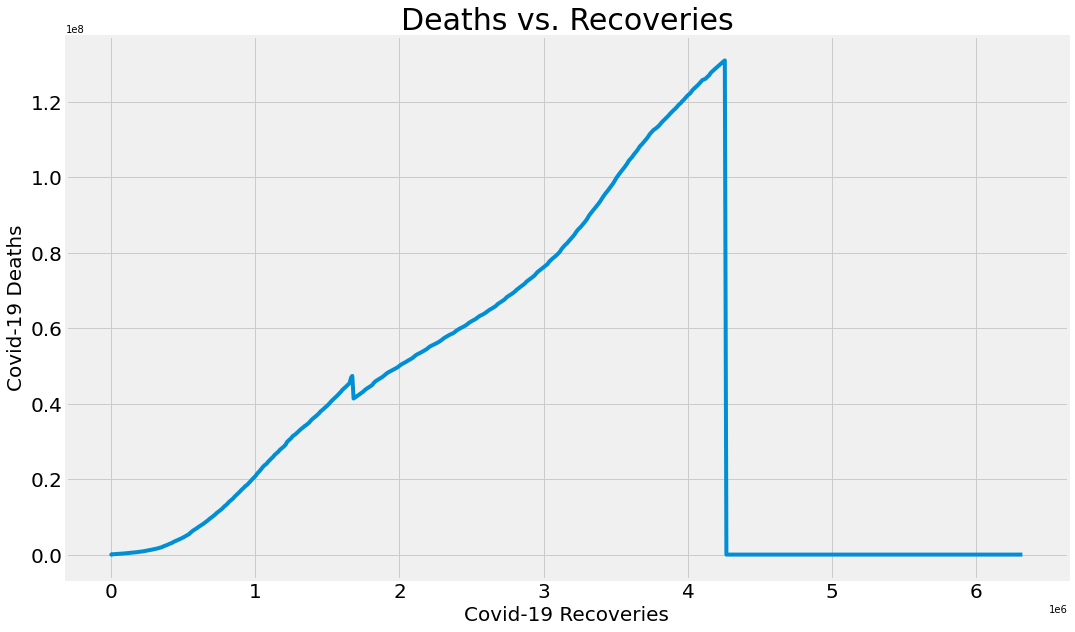

In [123]:
plt.figure(figsize=(16, 10))
plt.plot(total_recovered, total_deaths)
plt.title('Deaths vs. Recoveries', size=30)
plt.xlabel('Covid-19 Recoveries', size=20)
plt.ylabel('Covid-19 Deaths', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

# 10. 匯總全球各國疫情：各國省州鄉詳細分析
(1)匯整各國資料：

In [124]:
unique_countries =  list(latest_data['Country_Region'].unique())

(2) 資料純化：

In [126]:
country_confirmed_cases = []
country_death_cases = [] 
country_active_cases = []
country_recovery_cases = []
country_incidence_rate = [] 
country_mortality_rate = [] 

no_cases = []
for i in unique_countries:
    cases = latest_data[latest_data['Country_Region']==i]['Confirmed'].sum()
    if cases > 0:
        country_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
        
for i in no_cases:
    unique_countries.remove(i)
    
# sort countries by the number of confirmed cases
unique_countries = [k for k, v in sorted(zip(unique_countries, country_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
for i in range(len(unique_countries)):
    country_confirmed_cases[i] = latest_data[latest_data['Country_Region']==unique_countries[i]]['Confirmed'].sum()
    country_death_cases.append(latest_data[latest_data['Country_Region']==unique_countries[i]]['Deaths'].sum())
    country_recovery_cases.append(latest_data[latest_data['Country_Region']==unique_countries[i]]['Recovered'].sum())
    country_active_cases.append(latest_data[latest_data['Country_Region']==unique_countries[i]]['Active'].sum())
    # country_incidence_rate.append(latest_data[latest_data['Country_Region']==unique_countries[i]]['Incidence_Rate'].sum())
    country_mortality_rate.append(country_death_cases[i]/country_confirmed_cases[i])

In [127]:
unique_provinces =  list(latest_data['Province_State'].unique())

In [129]:
province_confirmed_cases = []
province_country = [] 
province_death_cases = [] 
province_recovery_cases = []
province_active = [] 
province_incidence_rate = []
province_mortality_rate = [] 

no_cases = [] 
for i in unique_provinces:
    cases = latest_data[latest_data['Province_State']==i]['Confirmed'].sum()
    if cases > 0:
        province_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
 
 # remove areas with no confirmed cases
for i in no_cases:
    unique_provinces.remove(i)
    
unique_provinces = [k for k, v in sorted(zip(unique_provinces, province_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
for i in range(len(unique_provinces)):
    province_confirmed_cases[i] = latest_data[latest_data['Province_State']==unique_provinces[i]]['Confirmed'].sum()
    province_country.append(latest_data[latest_data['Province_State']==unique_provinces[i]]['Country_Region'].unique()[0])
    province_death_cases.append(latest_data[latest_data['Province_State']==unique_provinces[i]]['Deaths'].sum())
    province_recovery_cases.append(latest_data[latest_data['Province_State']==unique_provinces[i]]['Recovered'].sum())
    province_active.append(latest_data[latest_data['Province_State']==unique_provinces[i]]['Active'].sum())
    # province_incidence_rate.append(latest_data[latest_data['Province_State']==unique_provinces[i]]['Incidence_Rate'].sum())
    province_mortality_rate.append(province_death_cases[i]/province_confirmed_cases[i])

In [130]:
# (3) 列表結果：

In [131]:
country_df = pd.DataFrame({'Country Name': unique_countries, 'Number of Confirmed Cases': country_confirmed_cases,
                          'Number of Deaths': country_death_cases, 'Number of Recoveries' : country_recovery_cases, 
                          'Number of Active Cases' : country_active_cases, 'Incidence Rate' : country_incidence_rate,
                          'Mortality Rate': country_mortality_rate})
# number of cases per country/region
country_df.style.background_gradient(cmap='Oranges')

ValueError: All arrays must be of the same length

In [132]:
country_df = pd.DataFrame({'Country Name': unique_countries, 'Number of Confirmed Cases': country_confirmed_cases,
                          'Number of Deaths': country_death_cases, 'Number of Recoveries' : country_recovery_cases, 
                          'Number of Active Cases' : country_active_cases,
                          'Mortality Rate': country_mortality_rate})
# number of cases per country/region
country_df.style.background_gradient(cmap='Oranges')

In [133]:
# (4) 列表結果：高階分析表

In [135]:
print(f'共 {len(country_df):.0f} 個國家,（{datetime.date.today()}）疫情統計表') #數字顯示設定
title1='★☆★☆== 共'+str(len(country_df))+'個國家，按今日('+str(datetime.date.today())+')全球Covid－19確診人數排名 ==☆★☆★'
(country_df.style
     .format('{:.2f}', subset='Number of Active Cases')          #將欄位的數值顯示限制到小數後第幾位
     # .format('{:.2f}', subset='Incidence Rate')                  #將欄位的數值顯示限制到小數後第幾位
     .format('{:.5f}', subset='Mortality Rate')                  #將欄位的數值顯示限制到小數後第幾位

     .highlight_max(subset=['Number of Confirmed Cases'],color='pink') #標示欄位最大值並用底色強化
     .set_caption(title1) #添加標題
     .hide_index()                                                  #隱藏索引欄（最左邊）
 
     .bar('Number of Deaths', vmin=0,color='gray')                  #將欄位依數值大小畫條狀圖(黑色)
     .highlight_max('Number of Deaths',color='lightblue')           #標示出欄位最大值並底色強化
     .highlight_min('Mortality Rate',color='red')                   #標示出特定欄位最大值並底色強化
     .background_gradient('Reds', subset='Number of Recoveries')    #將欄位依數值大小在背景著色
     .background_gradient('Blues', subset='Number of Active Cases') 
     .background_gradient('Blues', subset='Mortality Rate')         #將欄位依數值大小在背景著色
     .highlight_null('')                                            #將空值顯示底色為紅色
)

共 199 個國家,（2022-06-22）疫情統計表


# 11. 美國各州疫情一覽表：程式與列表結果。

(1) 資料選取：

In [136]:
us_states = list(latest_data[latest_data['Country_Region']=='US']['Province_State'].unique())

(2) 匯整資料：美國一級城市(州/省/自治區/佔領區)資料

(3) 資料匯整：

In [138]:
state_confirmed_cases = []
state_death_cases = [] 
# state_recovery_cases = []
state_active = [] 
state_incidence_rate = [] 
state_mortality_rate = [] 

no_cases = [] 
for i in us_states:
    cases = latest_data[latest_data['Province_State']==i]['Confirmed'].sum()
    if cases > 0:
        state_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
 
# remove areas with no confirmed cases
for i in no_cases:
    us_states.remove(i)
    
us_states = [k for k, v in sorted(zip(us_states, state_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
for i in range(len(us_states)):
    state_confirmed_cases[i] = latest_data[latest_data['Province_State']==us_states[i]]['Confirmed'].sum()
    state_death_cases.append(latest_data[latest_data['Province_State']==us_states[i]]['Deaths'].sum())
#     state_recovery_cases.append(latest_data[latest_data['Province_State']==us_states[i]]['Recovered'].sum())
    state_active.append(latest_data[latest_data['Province_State']==us_states[i]]['Active'].sum())
    # state_incidence_rate.append(latest_data[latest_data['Province_State']==us_states[i]]['Incidence_Rate'].sum())
    state_mortality_rate.append(state_death_cases[i]/state_confirmed_cases[i])

In [139]:
# （4) 美國各州疫情一覽表：分析結果

In [140]:
state_df = pd.DataFrame({'State Name': us_states, 'Number of Confirmed Cases': state_confirmed_cases,
                          'Number of Deaths': state_death_cases, 'Number of Active Cases' : state_active, 
                         'Incidence Rate' : state_incidence_rate, 'Mortality Rate': state_mortality_rate})
# number of cases per country/region
state_df.style.background_gradient(cmap='Oranges')

ValueError: All arrays must be of the same length

In [141]:
state_df = pd.DataFrame({'State Name': us_states, 'Number of Confirmed Cases': state_confirmed_cases,
                          'Number of Deaths': state_death_cases, 'Number of Active Cases' : state_active, 
                         'Mortality Rate': state_mortality_rate})
# number of cases per country/region
state_df.style.background_gradient(cmap='Oranges')

In [144]:
# 11. 美國各州疫情一覽表：高階分析表

title1='★☆★☆== 美國'+str(len(state_df))+'個 州／區，按今日('+str(datetime.date.today())+') Covid－19確診人數排名 ==☆★☆★'

(state_df.style
     .format('{:.2f}', subset='Number of Active Cases')          #將欄位的數值顯示限制到小數後第幾位
     # .format('{:.2f}', subset='Incidence Rate')                  #將欄位的數值顯示限制到小數後第幾位
     .format('{:.5f}', subset='Mortality Rate')                  #將欄位的數值顯示限制到小數後第幾位

     .highlight_max(subset=['Number of Confirmed Cases'],color='pink') #標示欄位最大值並用底色強化
     .set_caption(title1) #添加標題
     .hide_index()                                                  #隱藏索引欄（最左邊）
 
     .bar('Number of Deaths', vmin=0,color='gray')                  #將欄位依數值大小畫條狀圖(黑色)
     .highlight_max('Number of Deaths',color='lightblue')           #標示出欄位最大值並底色強化
     .highlight_min('Mortality Rate',color='red')                   #標示出特定欄位最大值並底色強化
  
     .background_gradient('Reds', subset='Number of Active Cases') #將欄位依數值大小在背景著色
     # .background_gradient('Purples', subset='Incidence Rate')         #將欄位依數值大小在背景著色
     .background_gradient('Blues', subset='Mortality Rate')         #將欄位依數值大小在背景著色
     .highlight_null('')                                            #將空值顯示底色為紅色
)

# 12. 美國與其他各國比較

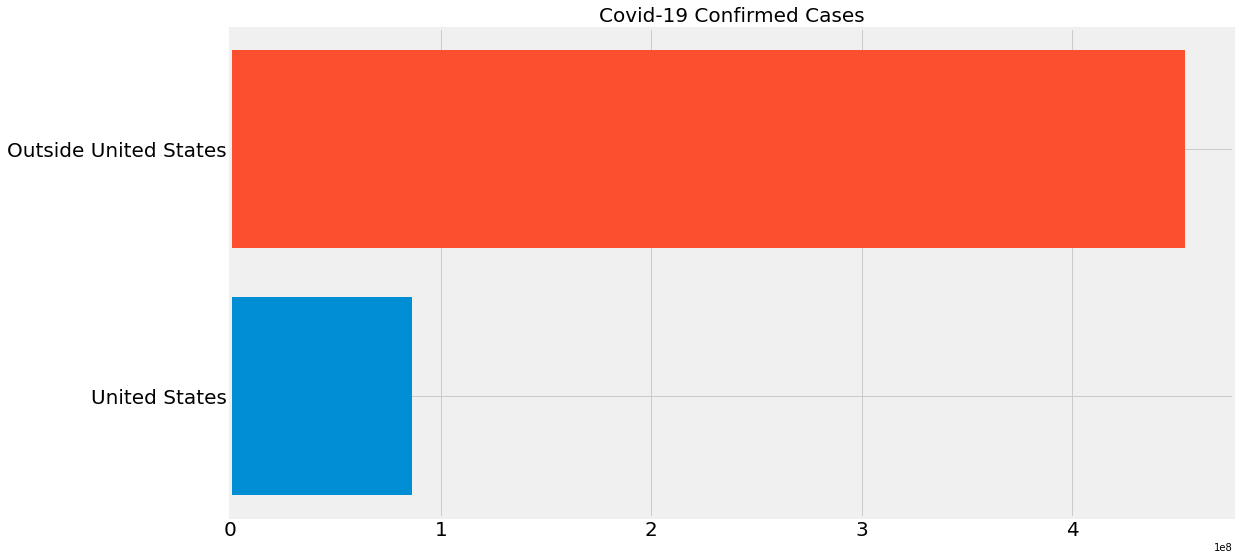

In [145]:
us_confirmed = latest_data[latest_data['Country_Region']=='US']['Confirmed'].sum()
outside_us_confirmed = np.sum(country_confirmed_cases) - us_confirmed
plt.figure(figsize=(16, 9))
plt.barh('United States', us_confirmed)
plt.barh('Outside United States', outside_us_confirmed)
plt.title('Covid-19 Confirmed Cases', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [146]:
print('Outside United States {} cases:'.format(outside_us_confirmed))
print('United States {} cases:'.format(us_confirmed))
print('Total: {} cases:'.format(us_confirmed+outside_us_confirmed))

Outside United States 453416283 cases:
United States 86297081 cases:
Total: 539713364 cases:


# 13. 前15大確診國家:

及其他地區加總比較

In [147]:
visual_unique_countries = [] 
visual_confirmed_cases = []
others = np.sum(country_confirmed_cases[10:])

for i in range(len(country_confirmed_cases[:10])):
    visual_unique_countries.append(unique_countries[i])
    visual_confirmed_cases.append(country_confirmed_cases[i])
    
visual_unique_countries.append('Others')
visual_confirmed_cases.append(others)

In [148]:
#Visual Representations (bar charts and pie charts)

In [149]:
def plot_bar_graphs(x, y, title):
    plt.figure(figsize=(16, 12))
    plt.barh(x, y)
    plt.title(title, size=20)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()
    
# good for a lot x values 
def plot_bar_graphs_tall(x, y, title):
    plt.figure(figsize=(19, 18))
    plt.barh(x, y)
    plt.title(title, size=25)
    plt.xticks(size=25)
    plt.yticks(size=25)
    plt.show()

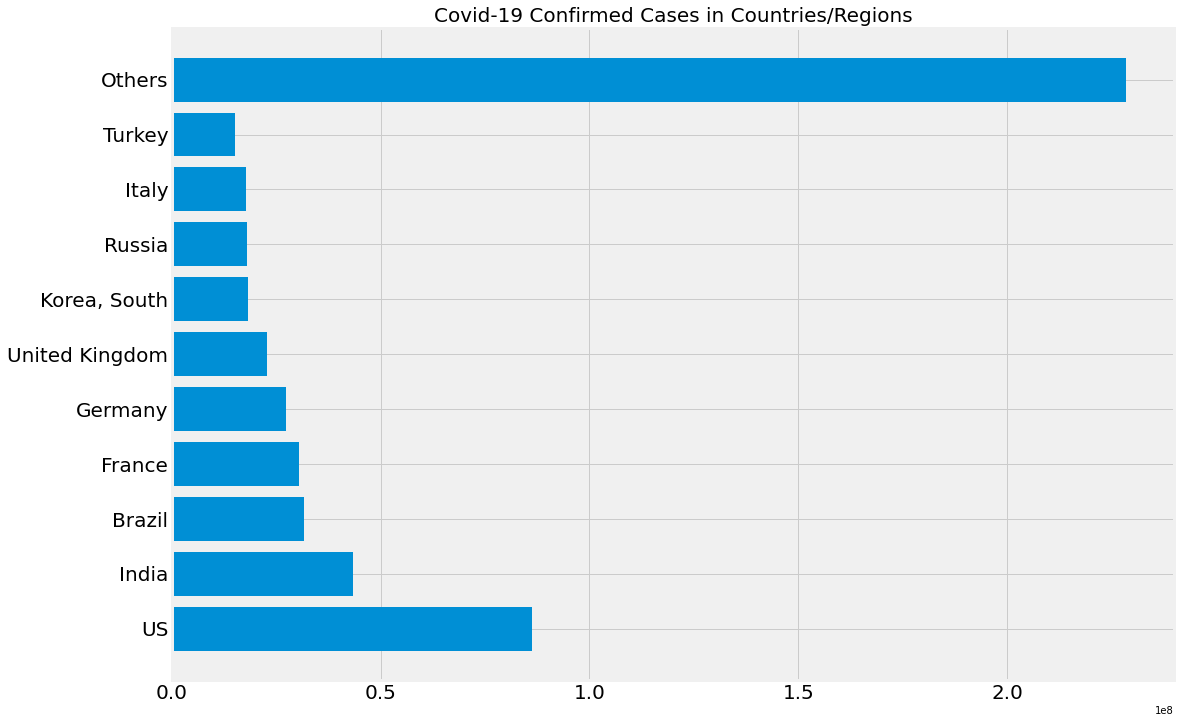

In [150]:
plot_bar_graphs(visual_unique_countries, visual_confirmed_cases, 'Covid-19 Confirmed Cases in Countries/Regions')

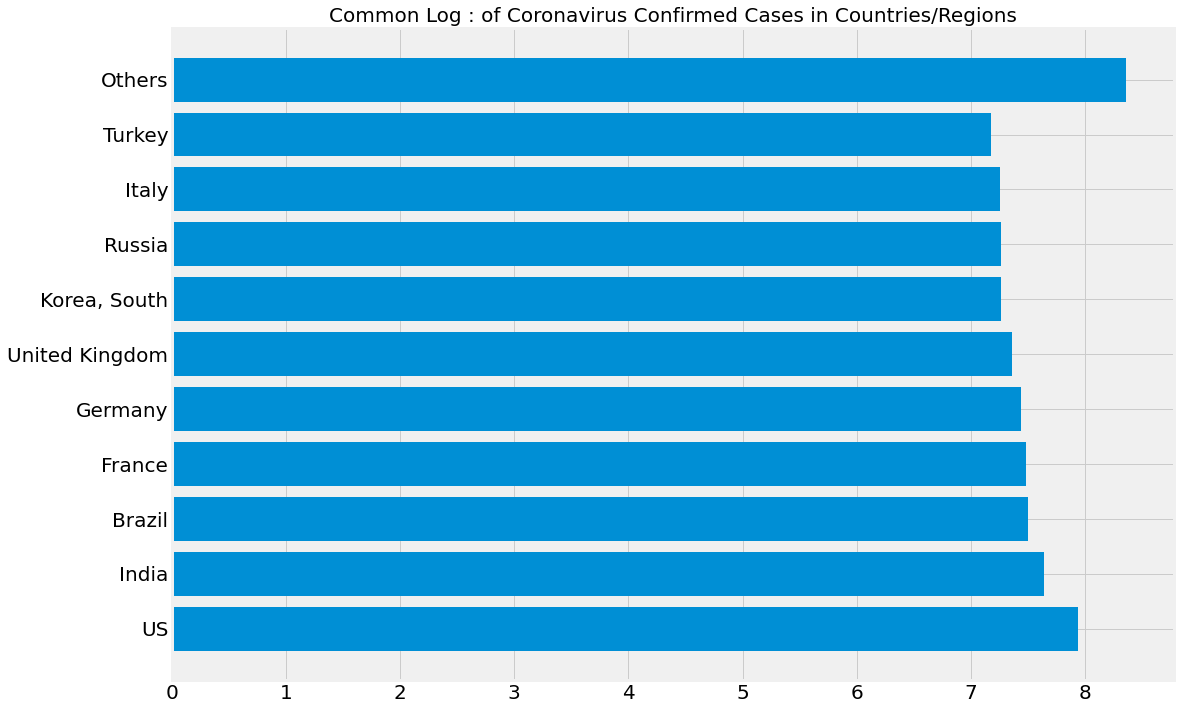

In [151]:
#對數(LOG)運算後，確診圖程式如下：
log_country_confirmed_cases = [math.log10(i) for i in visual_confirmed_cases]
plot_bar_graphs(visual_unique_countries, log_country_confirmed_cases, 'Common Log : of Coronavirus Confirmed Cases in Countries/Regions')

In [152]:
# 各國區域內各州或各省（前十大），疫情統計數據整理，程式部分：

visual_unique_provinces = [] 
visual_confirmed_cases2 = []
others = np.sum(province_confirmed_cases[10:])
for i in range(len(province_confirmed_cases[:10])):
    visual_unique_provinces.append(unique_provinces[i])
    visual_confirmed_cases2.append(province_confirmed_cases[i])

visual_unique_provinces.append('Others')
visual_confirmed_cases2.append(others)

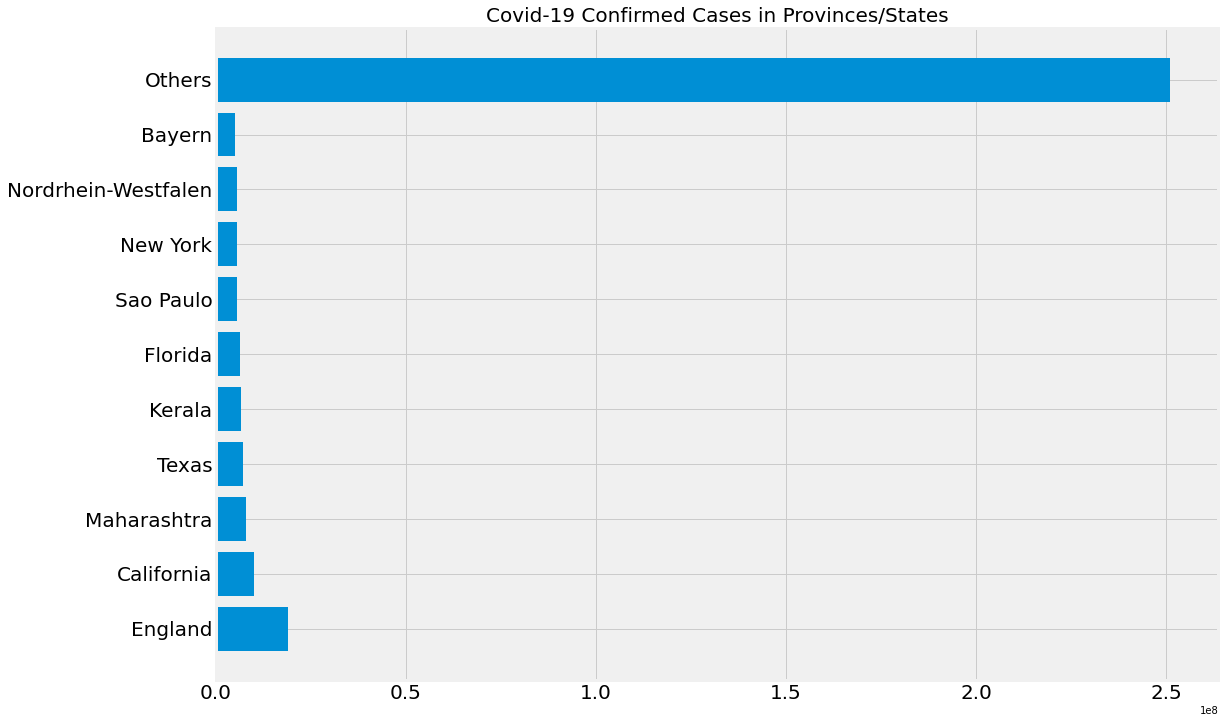

In [153]:
plot_bar_graphs(visual_unique_provinces, visual_confirmed_cases2, 'Covid-19 Confirmed Cases in Provinces/States')

In [154]:
#(7) 對資料進行對數(LOG)運算：

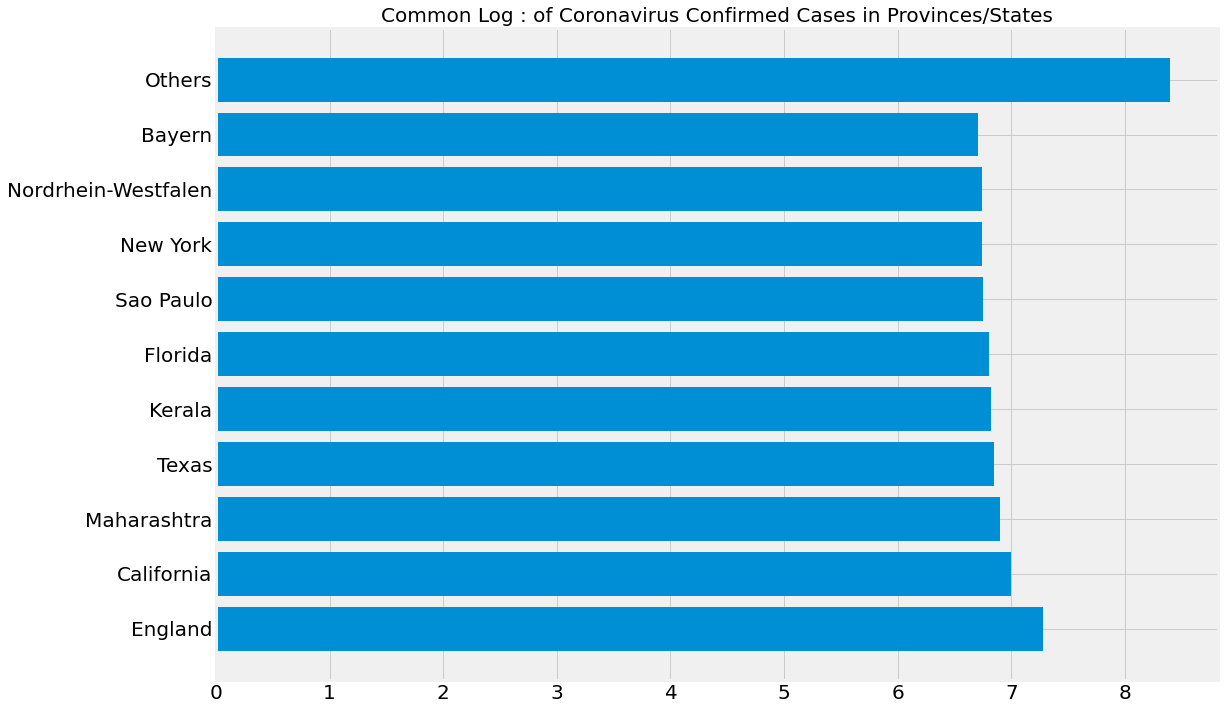

In [155]:
log_province_confirmed_cases = [math.log10(i) for i in visual_confirmed_cases2]
plot_bar_graphs(visual_unique_provinces, log_province_confirmed_cases, 'Common Log : of Coronavirus Confirmed Cases in Provinces/States')


In [156]:
#(8) 用另一種視覺呈現，全球Covid-19疫情:Pie Chart。

In [157]:
def plot_pie_charts(x, y, title):
    # more muted color 
    c = ['lightcoral', 'rosybrown', 'sandybrown', 'navajowhite', 'gold',
        'khaki', 'lightskyblue', 'turquoise', 'lightslategrey', 'thistle', 'pink']
    plt.figure(figsize=(20,15))
    plt.title(title, size=20)
    plt.pie(y, colors=c,shadow=True, labels=y)
    plt.legend(x, loc='best', fontsize=12)
    plt.show()

In [158]:
#(9) 繪圖程式(全球國家比較)：

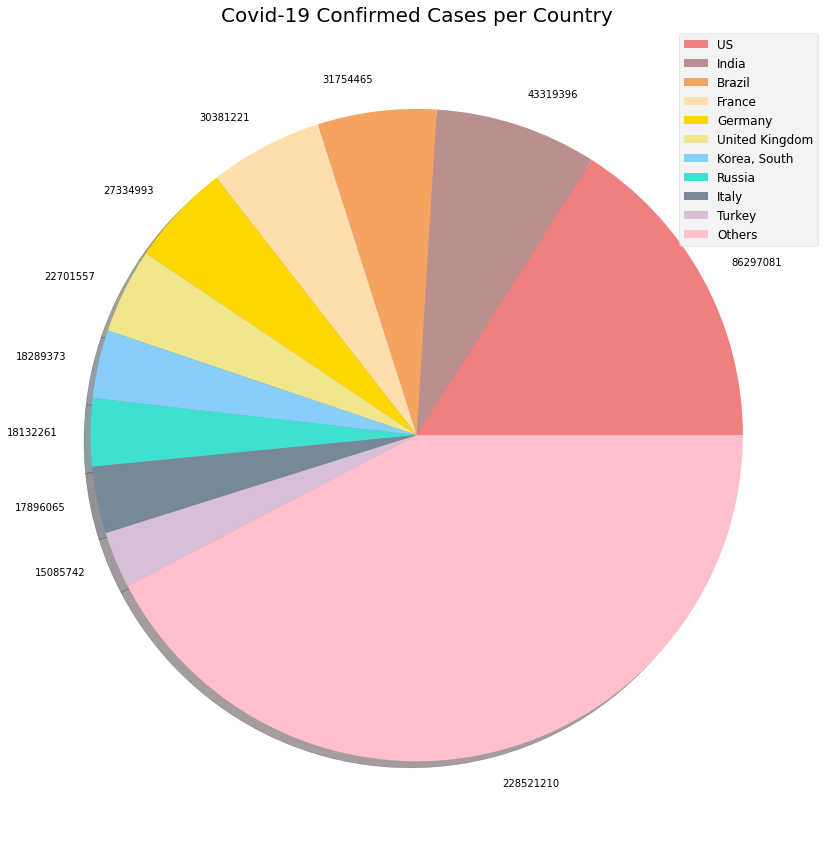

In [159]:
plot_pie_charts(visual_unique_countries, visual_confirmed_cases, 'Covid-19 Confirmed Cases per Country')

In [160]:
#(10) 繪圖程式(全球區域性比較)－區域是以大國中的州/省/自治區/佔領區等做為比較單位：

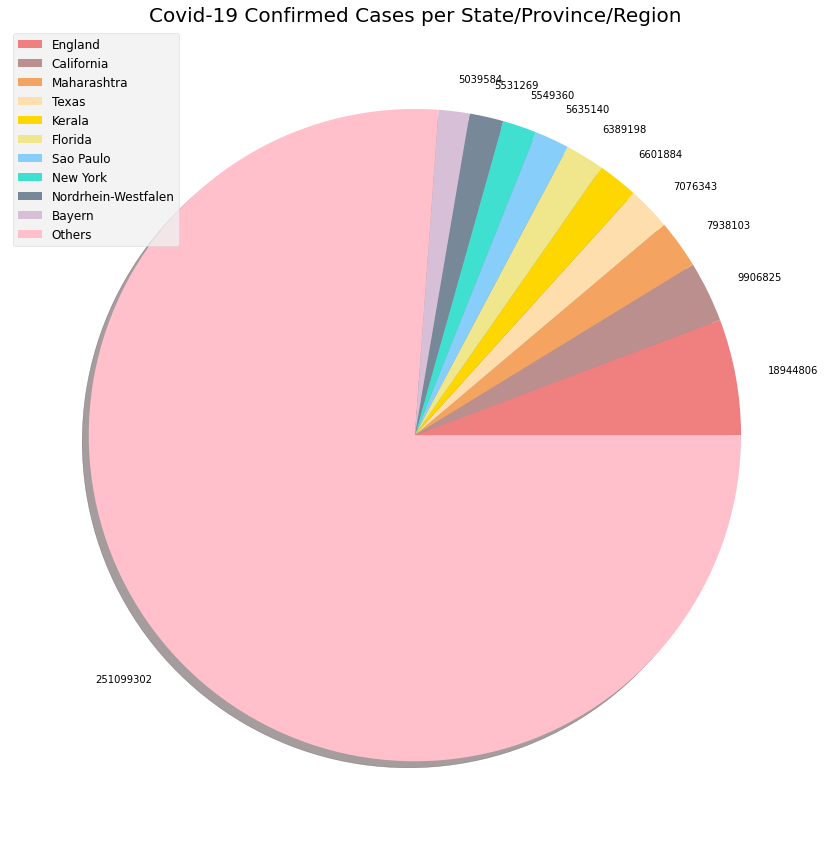

In [161]:
plot_pie_charts(visual_unique_provinces, visual_confirmed_cases2, 
                'Covid-19 Confirmed Cases per State/Province/Region')

In [162]:
#(11) 全球Covid-19疫情按大國家的區域性分析（僅列最嚴重的感染地區）:

#1) 僅列該國最嚴重的五感染地區，其他放入Others項目中。
#2) 只列確診數大於零的資料。

In [163]:
def plot_pie_country_with_regions(country_name, title):
    regions = list(latest_data[latest_data['Country_Region']==country_name]['Province_State'].unique())
    confirmed_cases = []
    no_cases = [] 
    for i in regions:
        cases = latest_data[latest_data['Province_State']==i]['Confirmed'].sum()
        if cases > 0:
            confirmed_cases.append(cases)
        else:
            no_cases.append(i)

    # remove areas with no confirmed cases
    for i in no_cases:
        regions.remove(i)

    # only show the top 5 states
    regions = [k for k, v in sorted(zip(regions, confirmed_cases), key=operator.itemgetter(1), reverse=True)]

    for i in range(len(regions)):
        confirmed_cases[i] = latest_data[latest_data['Province_State']==regions[i]]['Confirmed'].sum()  
    
    # additional province/state will be considered "others"
    
    if(len(regions)>5):
        regions_5 = regions[:5]
        regions_5.append('Others')
        confirmed_cases_5 = confirmed_cases[:5]
        confirmed_cases_5.append(np.sum(confirmed_cases[5:]))
        plot_pie_charts(regions_5,confirmed_cases_5, title)
    else:
        plot_pie_charts(regions,confirmed_cases, title)

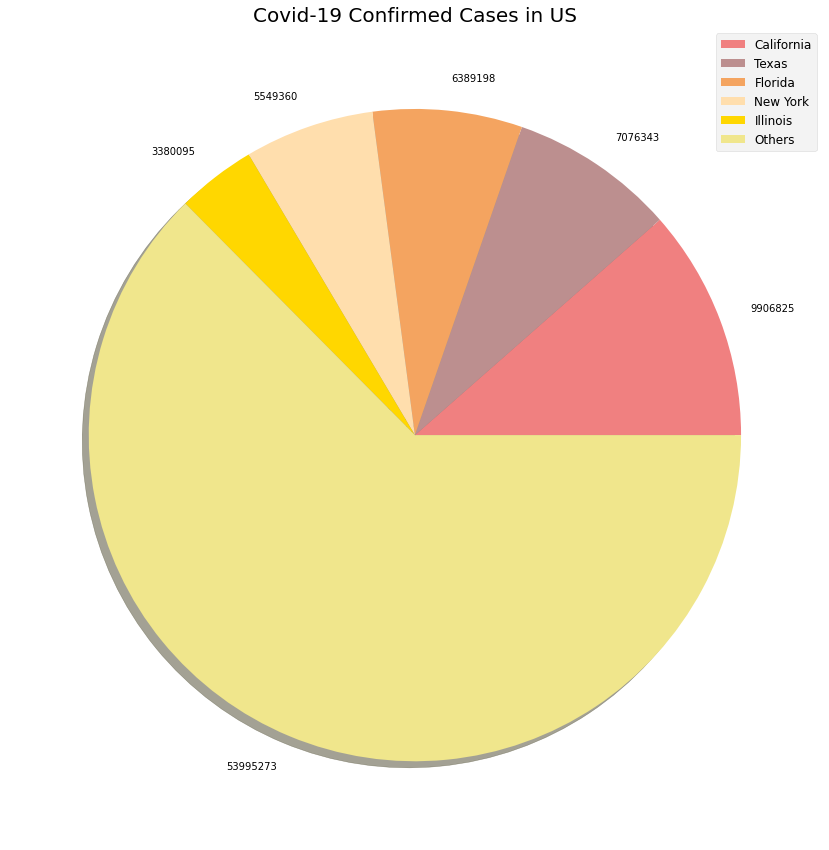

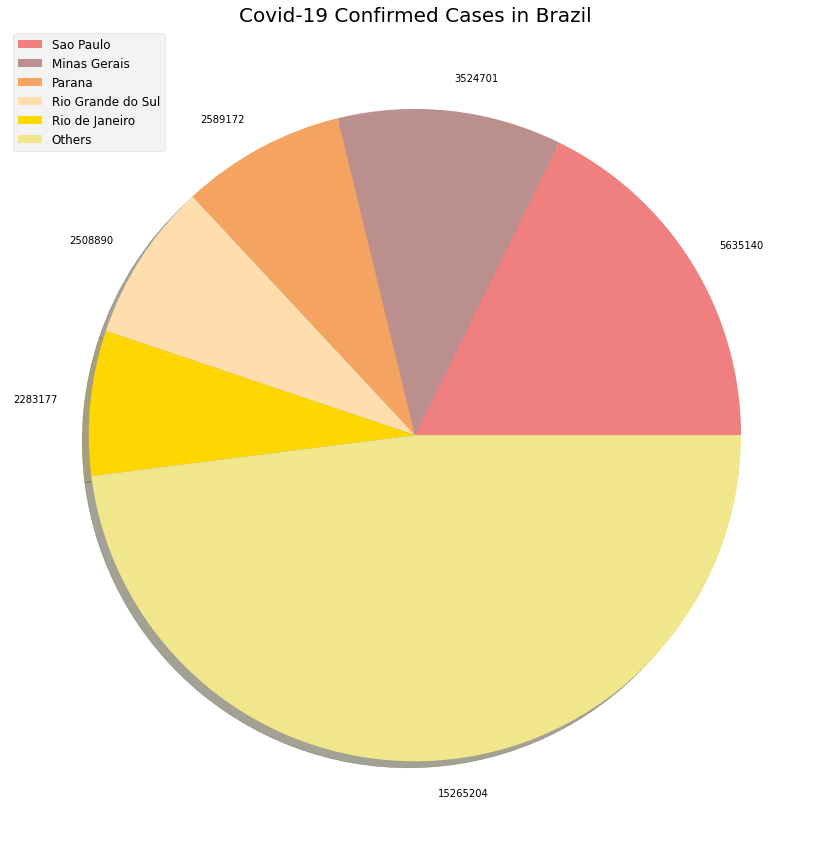

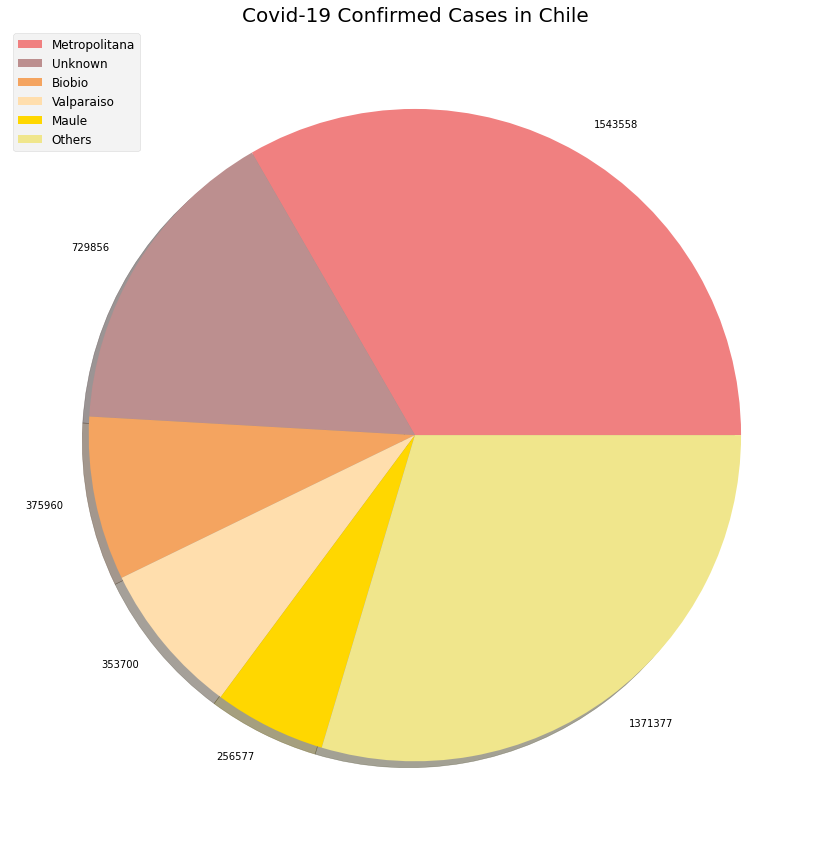

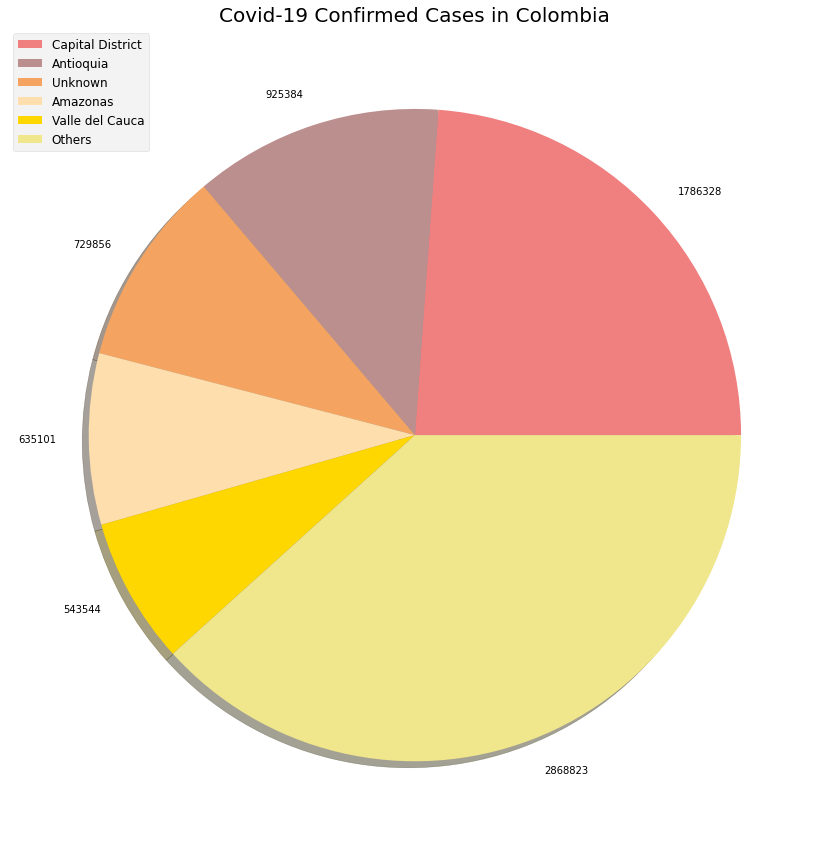

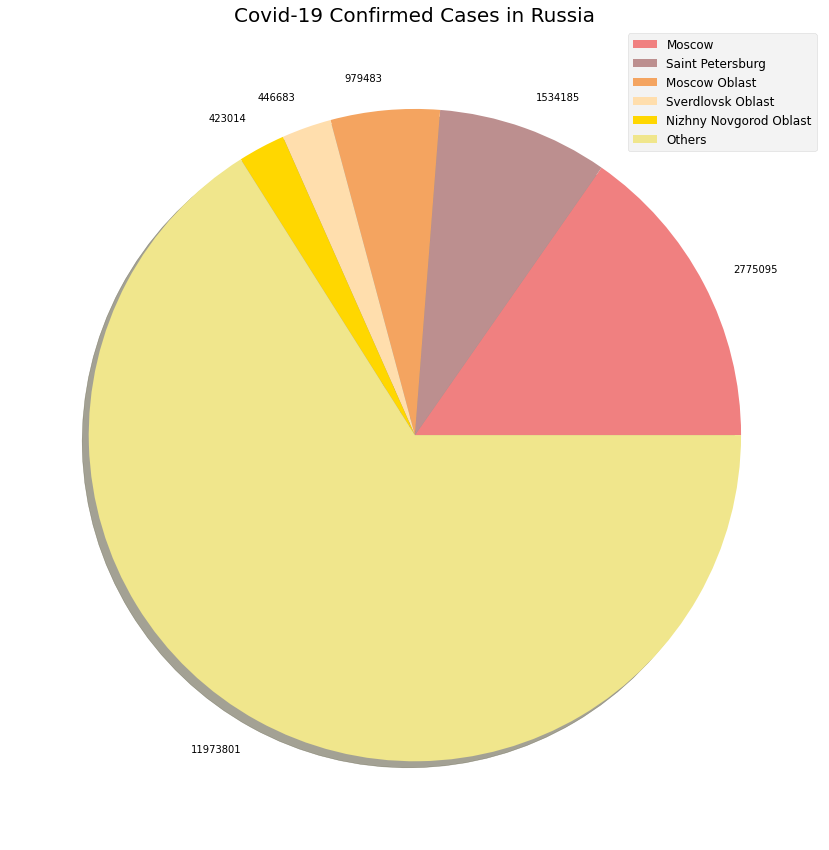

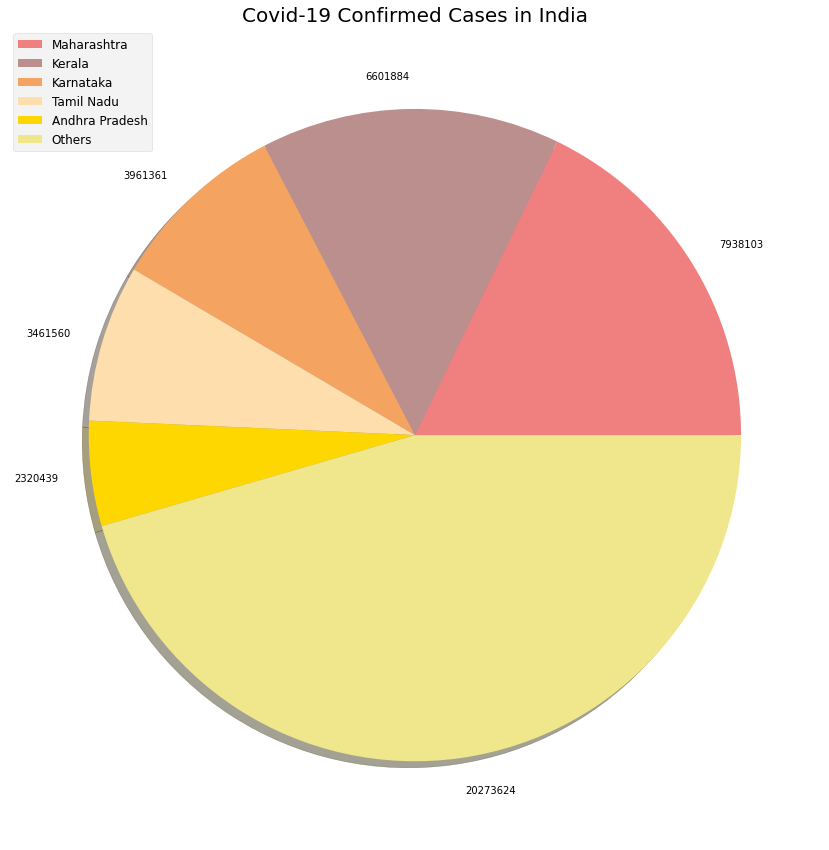

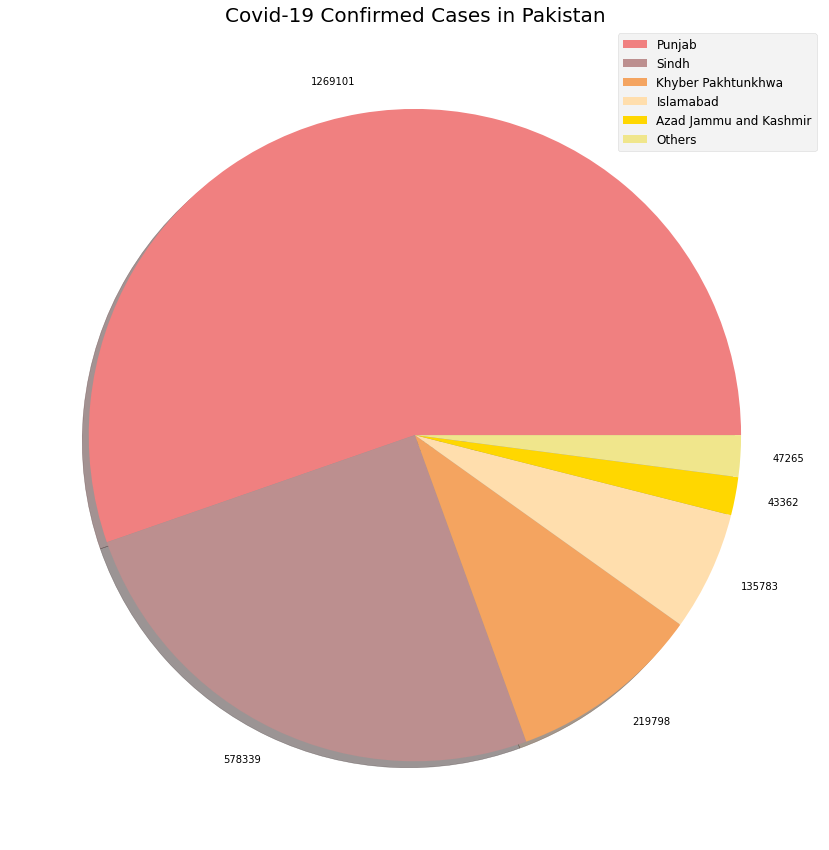

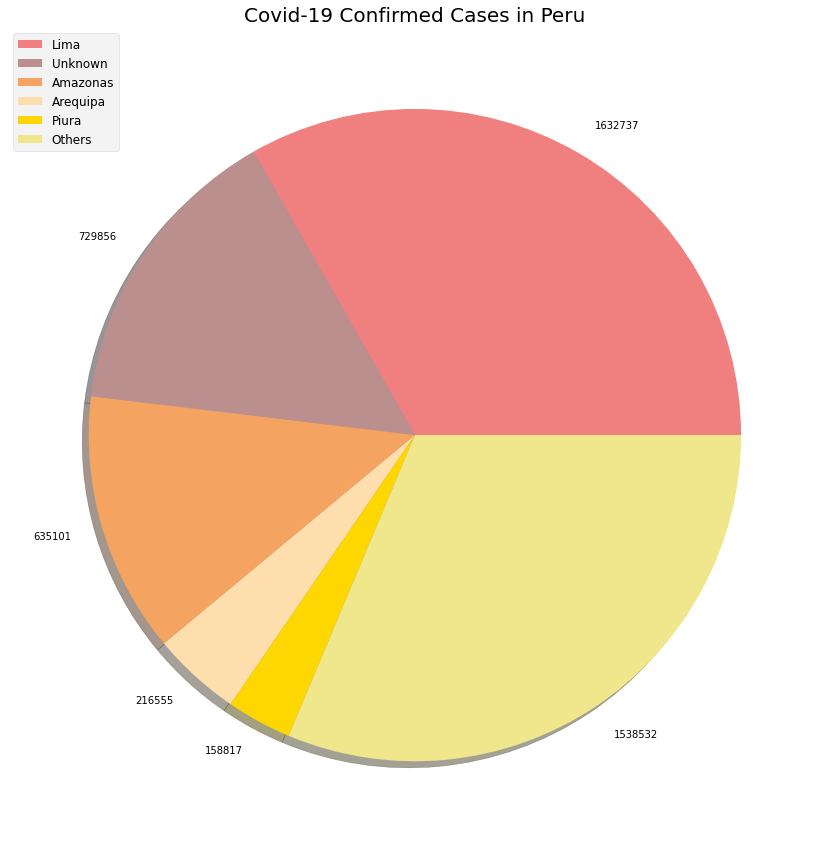

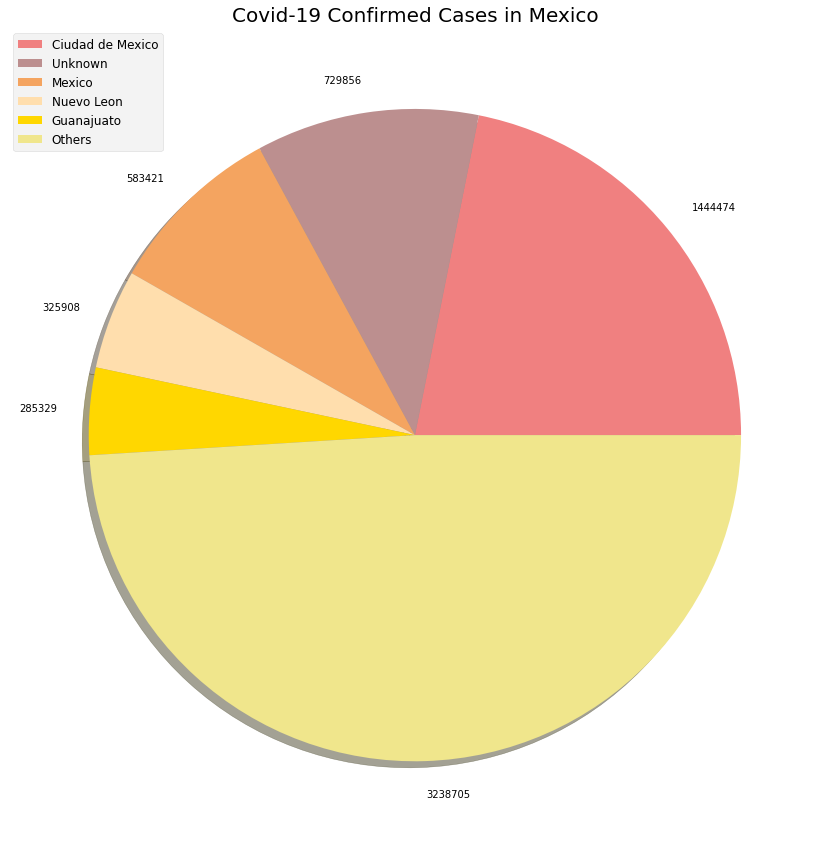

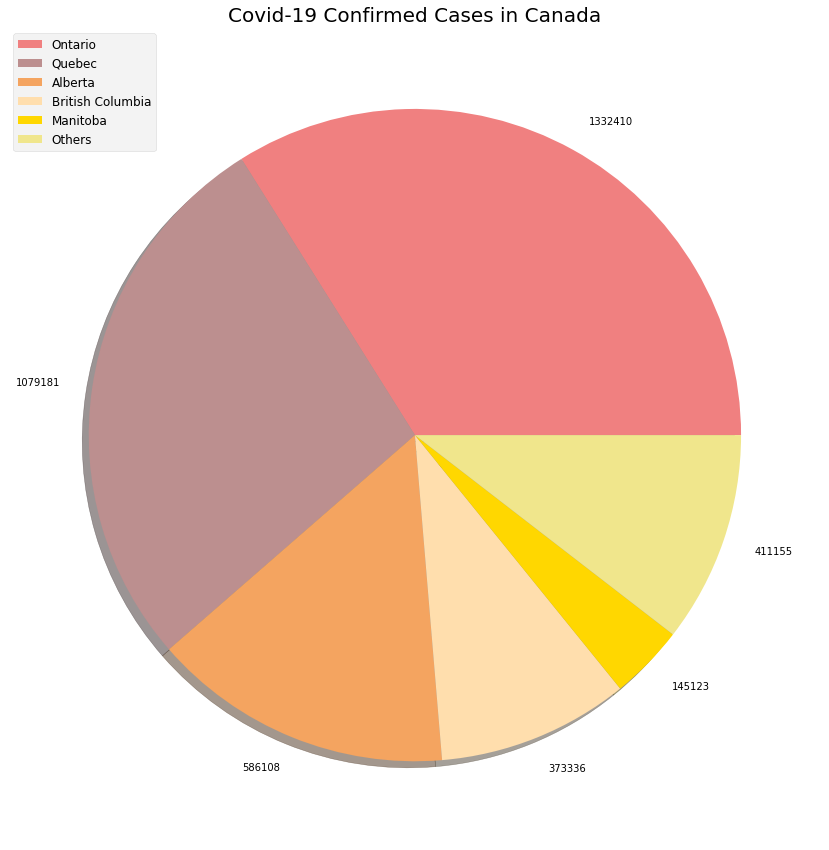

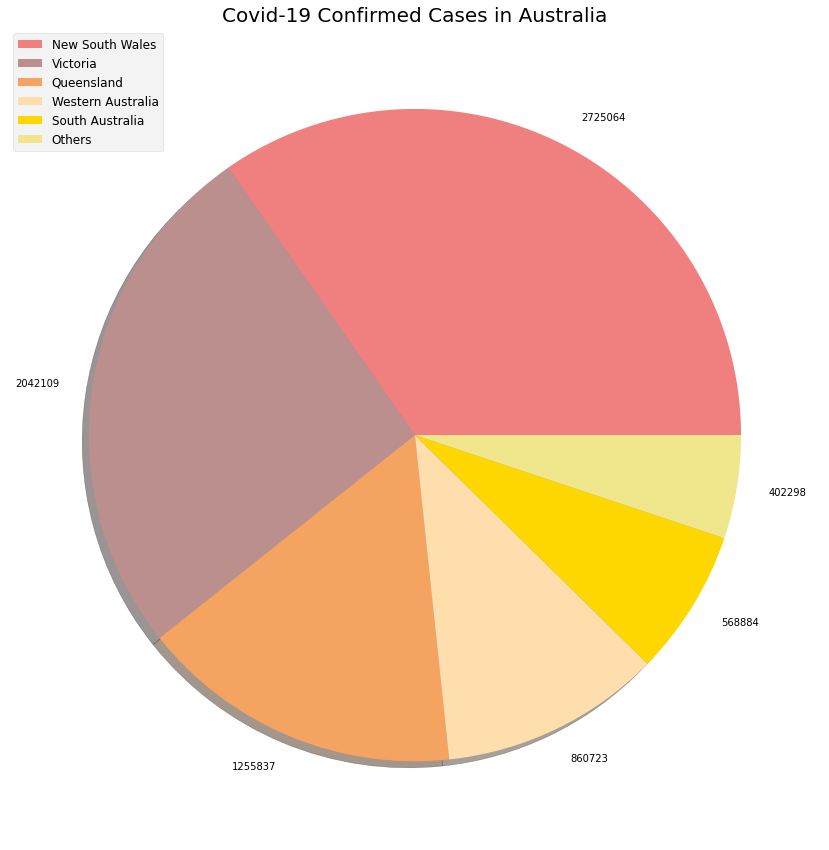

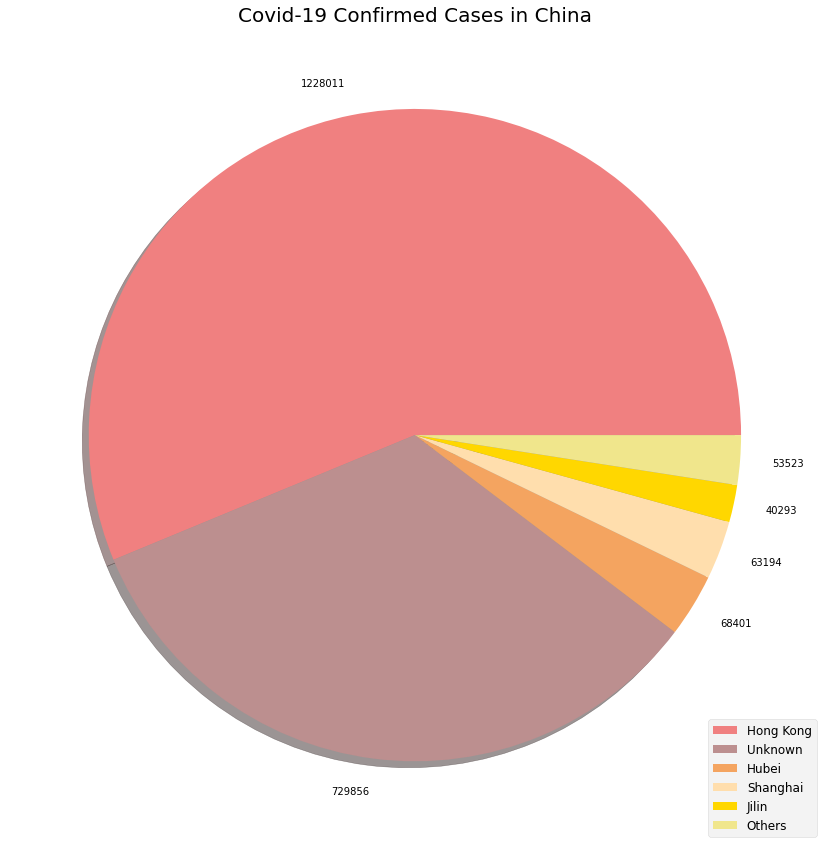

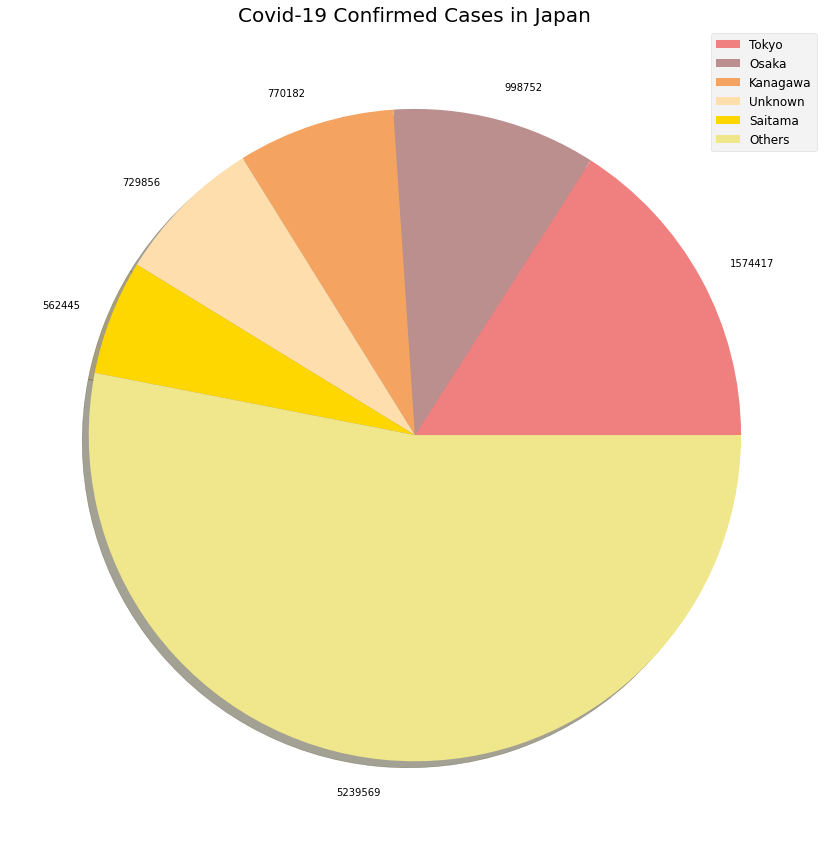

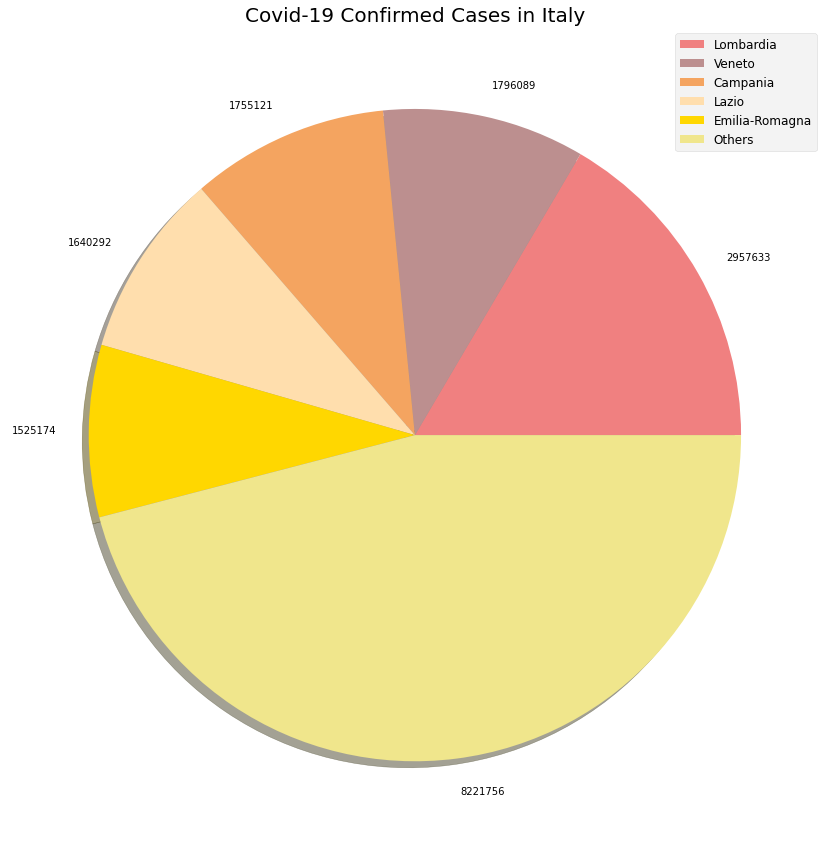

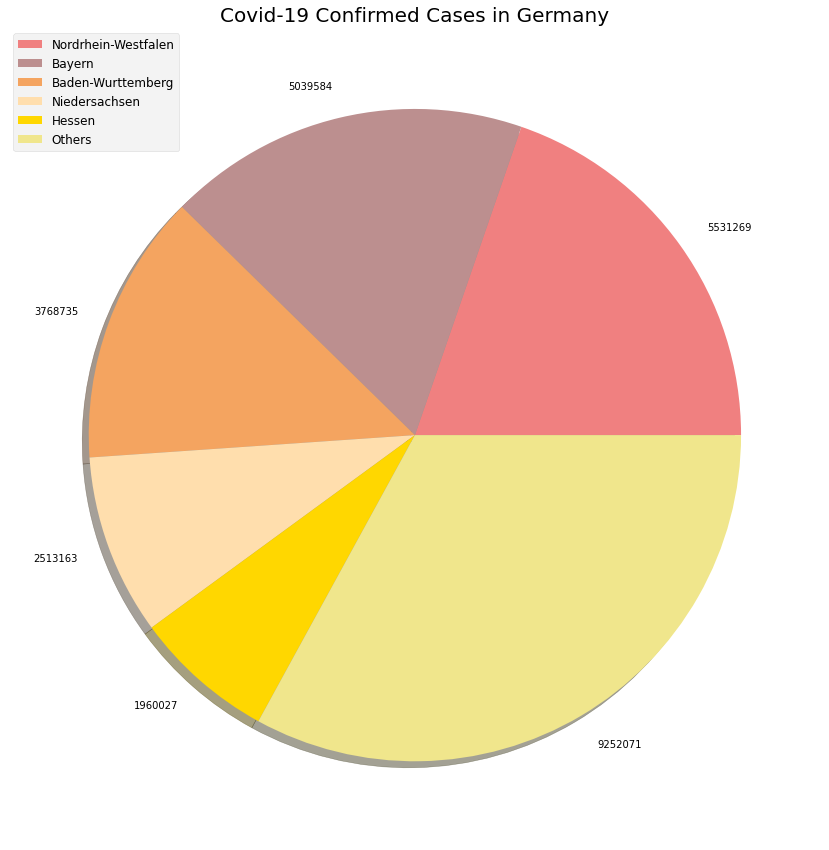

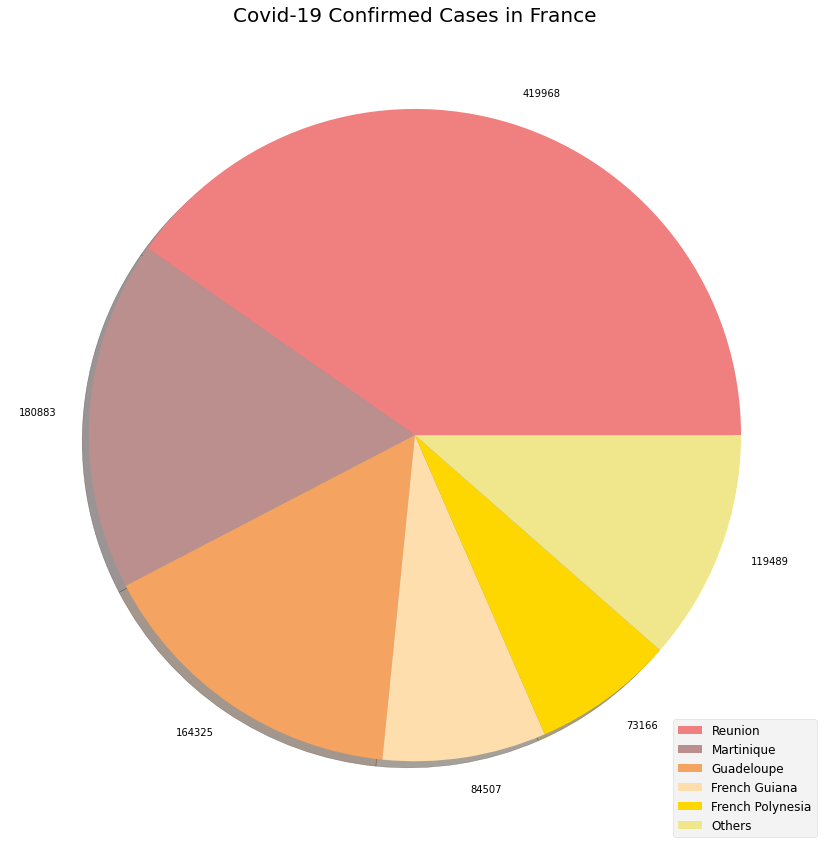

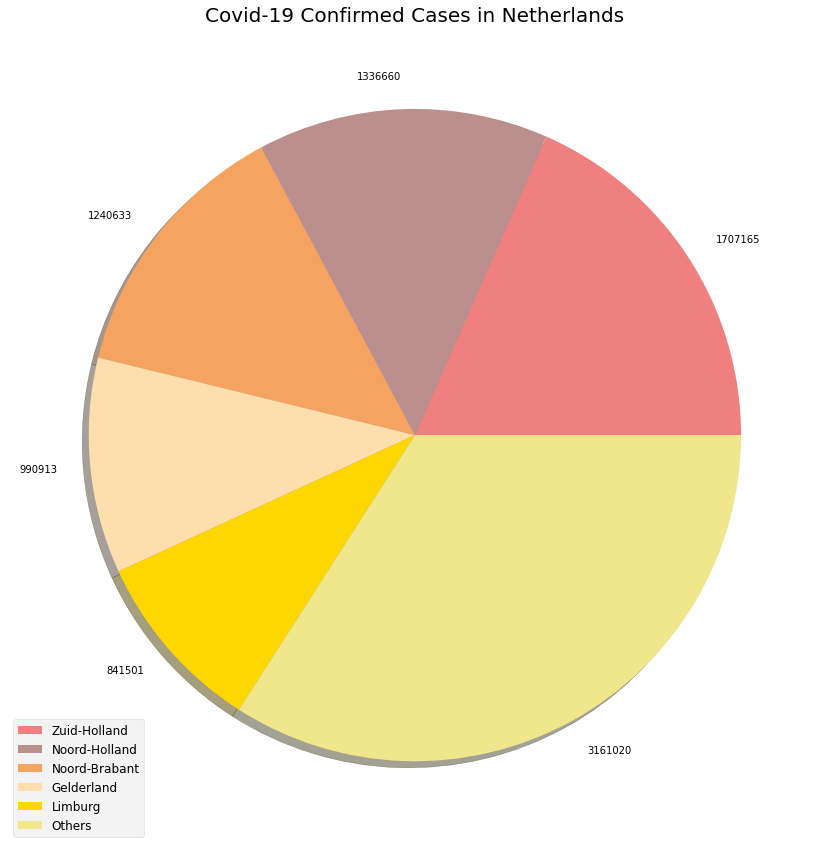

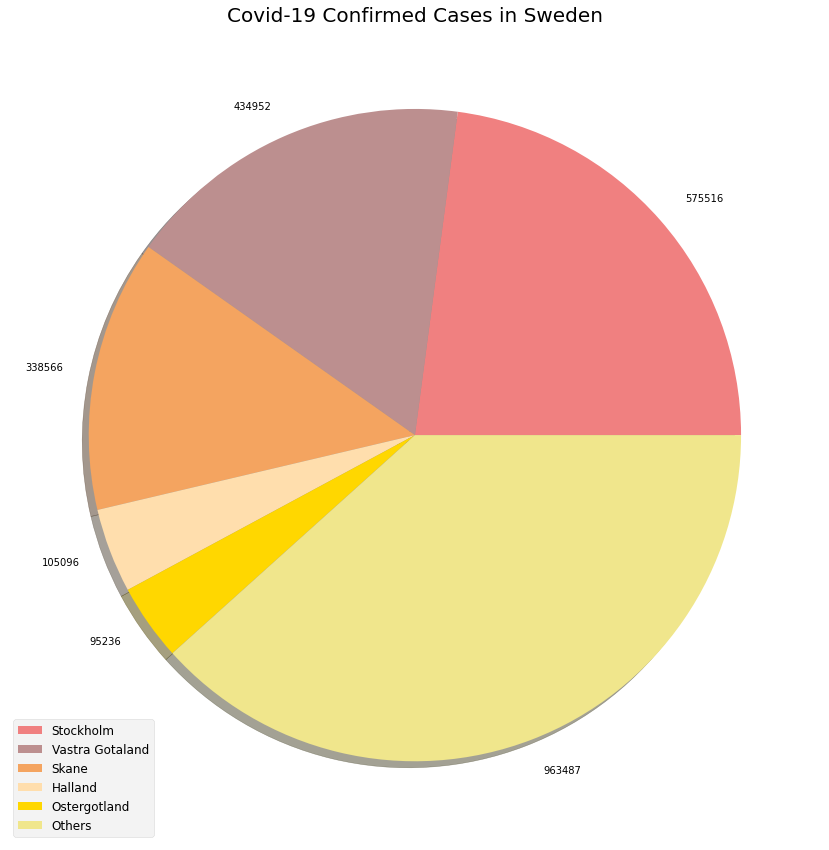

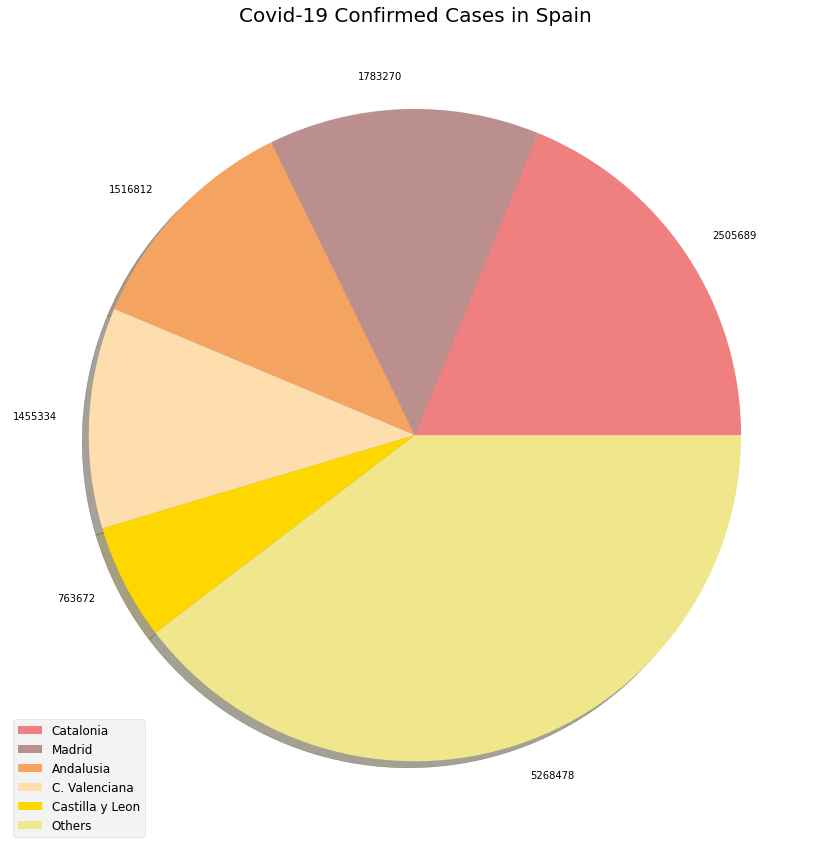

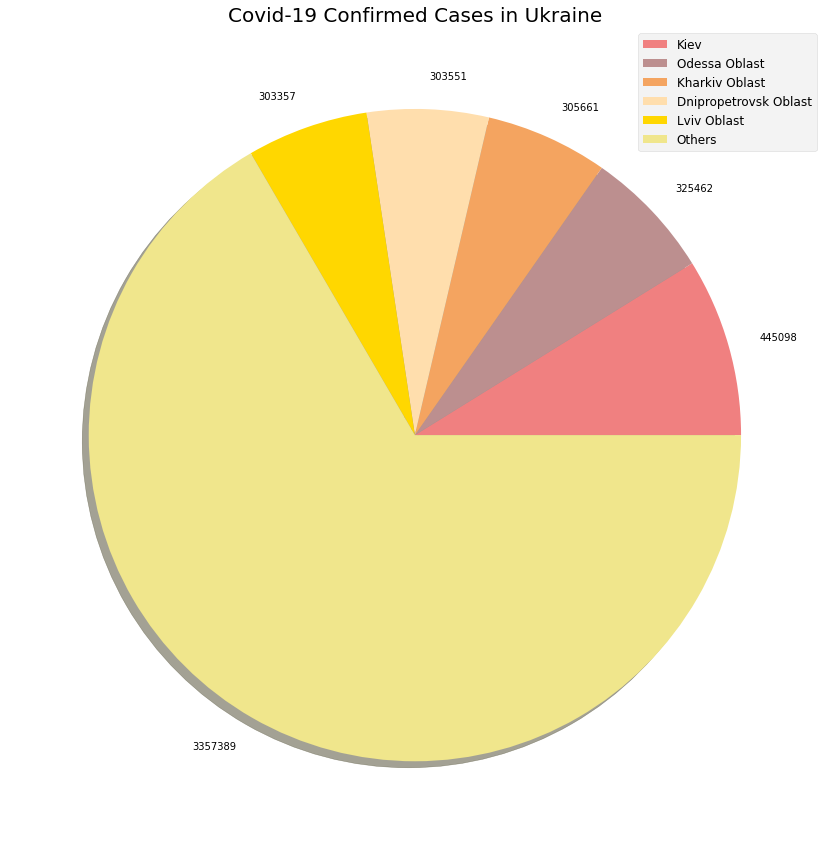

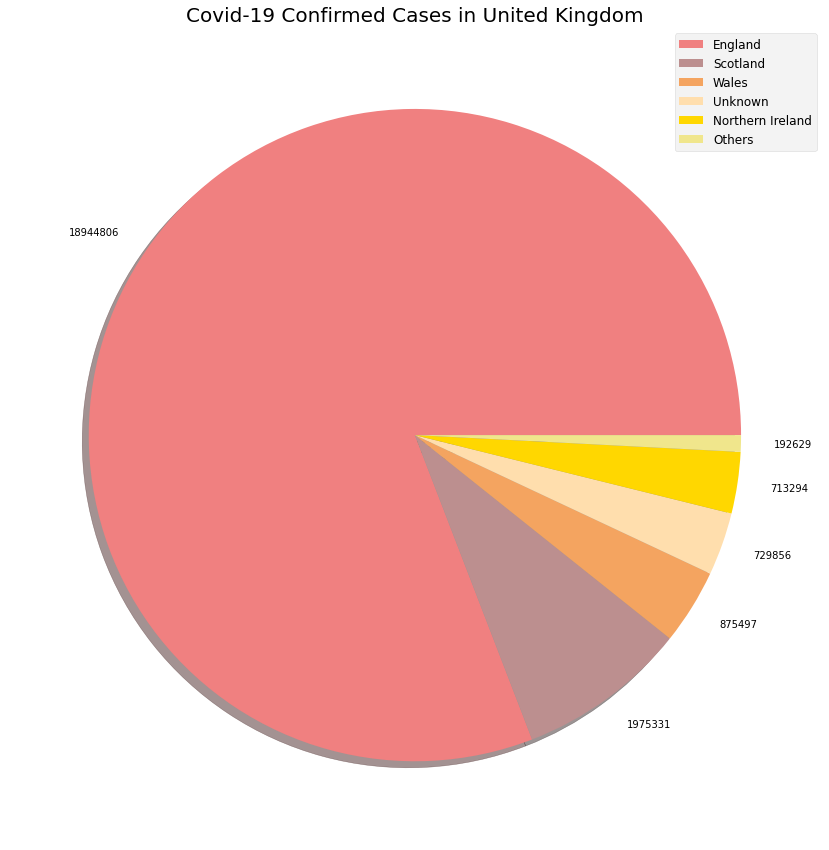

In [164]:
pie_chart_countries = ['US', 'Brazil','Chile', 'Colombia','Russia', 'India','Pakistan' ,
                       'Peru', 'Mexico', 'Canada', 
                       'Australia', 'China','Japan', 
                       'Italy', 'Germany', 'France','Netherlands','Sweden',
                       'Spain','Ukraine','United Kingdom'
                       ]

for i in pie_chart_countries:
    plot_pie_country_with_regions(i, 'Covid-19 Confirmed Cases in {}'.format(i))

In [165]:
#(12) 美國資料資源即時現況分析：

In [166]:
# 資料補闕
us_medical_data.fillna(value=0, inplace=True)
# 資料整理
def plot_us_medical_data():
    states = us_medical_data['Province_State'].unique()
    testing_number = []
    testing_rate = []
    
    for i in states:
        testing_number.append(us_medical_data[us_medical_data['Province_State']==i]['People_Tested'].sum())
        testing_rate.append(us_medical_data[us_medical_data['Province_State']==i]['Testing_Rate'].max())
    
    # 只顯示現況最緊急的15個州
    testing_states = [k for k, v in sorted(zip(states, testing_number), key=operator.itemgetter(1), reverse=True)]
    testing_rate_states = [k for k, v in sorted(zip(states, testing_rate), key=operator.itemgetter(1), reverse=True)]
  
    for i in range(len(states)):
        testing_number[i] = us_medical_data[us_medical_data['Province_State']==testing_states[i]]['People_Tested'].sum()
        testing_rate[i] = us_medical_data[us_medical_data['Province_State']==testing_rate_states[i]]['Testing_Rate'].sum()
    
    top_limit = 30 
    
    plot_bar_graphs_tall(testing_states[:top_limit], testing_number[:top_limit], 'Total Testing per State (Top 30)')
    plot_bar_graphs_tall(testing_rate_states[:top_limit], testing_rate[:top_limit], 'Testing Rate per 100,000 People (Top 30)')
 
    #  plot_us_medical_data()

In [167]:
plot_us_medical_data()

KeyError: 'People_Tested'

# 14. 各國人口移動即時資訊(Apple Mobility):

用Apple公司提供的大數據資料庫來分析下列二個重要趨勢：

In [168]:
def get_mobility_by_state(transport_type, state, day):
    return apple_mobility[apple_mobility['sub-region']==state][apple_mobility['transportation_type']==transport_type].sum()[day]

In [169]:
apple_mobility.head(3)

Unnamed: 0.5  Unnamed: 0.4  Unnamed: 0.3  Unnamed: 0.2  Unnamed: 0.1  ...  \
0             0             0             0             0             0  ...   
1             1             1             1             1             1  ...   
2             2             2             2             2             2  ...   

   2020-10-03 2020-10-04 2020-10-05 2020-10-06 2020-10-07  
0      148.03     136.67     123.11     117.50     119.25  
1      166.40     130.23     168.27     140.04     154.46  
2       71.69      38.69      55.99      59.95      62.76  

[3 rows x 281 columns]

In [170]:
# sample testing 
get_mobility_by_state('walking', 'Connecticut', '2020-10-07')

926.07

In [171]:
#(4) 進行日期型態不同的檔案間的轉換：以符合Apple Mobility(因為日後會天天從Apple Maps下載資料，為了省麻煩，將資料格式先統一）。

In [172]:
revised_dates = []
for i in range(1,len(dates)):
    revised_dates.append(datetime.datetime.strptime(dates[i], '%m/%d/%y').strftime('%Y-%m-%d'))

In [173]:
revised_dates

['2020-01-22',
 '2020-01-23',
 '2020-01-24',
 '2020-01-25',
 '2020-01-26',
 '2020-01-27',
 '2020-01-28',
 '2020-01-29',
 '2020-01-30',
 '2020-01-31',
 '2020-02-01',
 '2020-02-02',
 '2020-02-03',
 '2020-02-04',
 '2020-02-05',
 '2020-02-06',
 '2020-02-07',
 '2020-02-08',
 '2020-02-09',
 '2020-02-10',
 '2020-02-11',
 '2020-02-12',
 '2020-02-13',
 '2020-02-14',
 '2020-02-15',
 '2020-02-16',
 '2020-02-17',
 '2020-02-18',
 '2020-02-19',
 '2020-02-20',
 '2020-02-21',
 '2020-02-22',
 '2020-02-23',
 '2020-02-24',
 '2020-02-25',
 '2020-02-26',
 '2020-02-27',
 '2020-02-28',
 '2020-02-29',
 '2020-03-01',
 '2020-03-02',
 '2020-03-03',
 '2020-03-04',
 '2020-03-05',
 '2020-03-06',
 '2020-03-07',
 '2020-03-08',
 '2020-03-09',
 '2020-03-10',
 '2020-03-11',
 '2020-03-12',
 '2020-03-13',
 '2020-03-14',
 '2020-03-15',
 '2020-03-16',
 '2020-03-17',
 '2020-03-18',
 '2020-03-19',
 '2020-03-20',
 '2020-03-21',
 '2020-03-22',
 '2020-03-23',
 '2020-03-24',
 '2020-03-25',
 '2020-03-26',
 '2020-03-27',
 '2020-03-

In [174]:
#(5) 將週末(Weekend)和週間(Weekday)的資料分別統計

In [175]:
# returns true if it is a weekend, and false if it is a weekday 
def weekday_or_weekend(date):
    date_obj = datetime.datetime.strptime(date, '%Y-%m-%d')
    day_of_the_week =  date_obj.weekday()
    if (day_of_the_week+1) % 6 == 0 or (day_of_the_week+1) % 7 == 0:
        return True 
    else:
        return False 

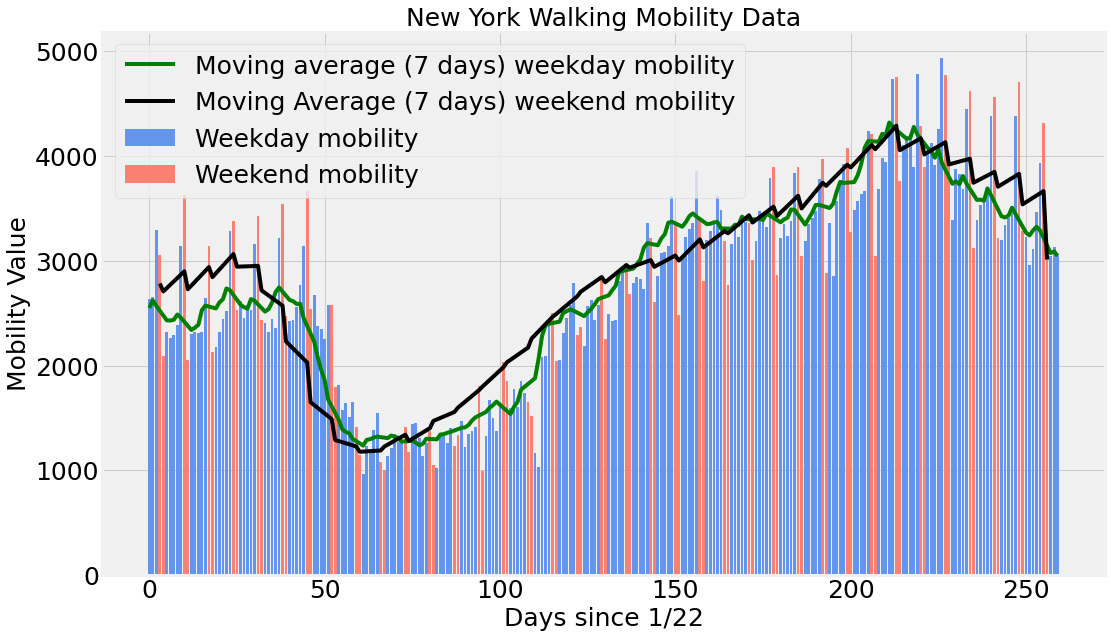

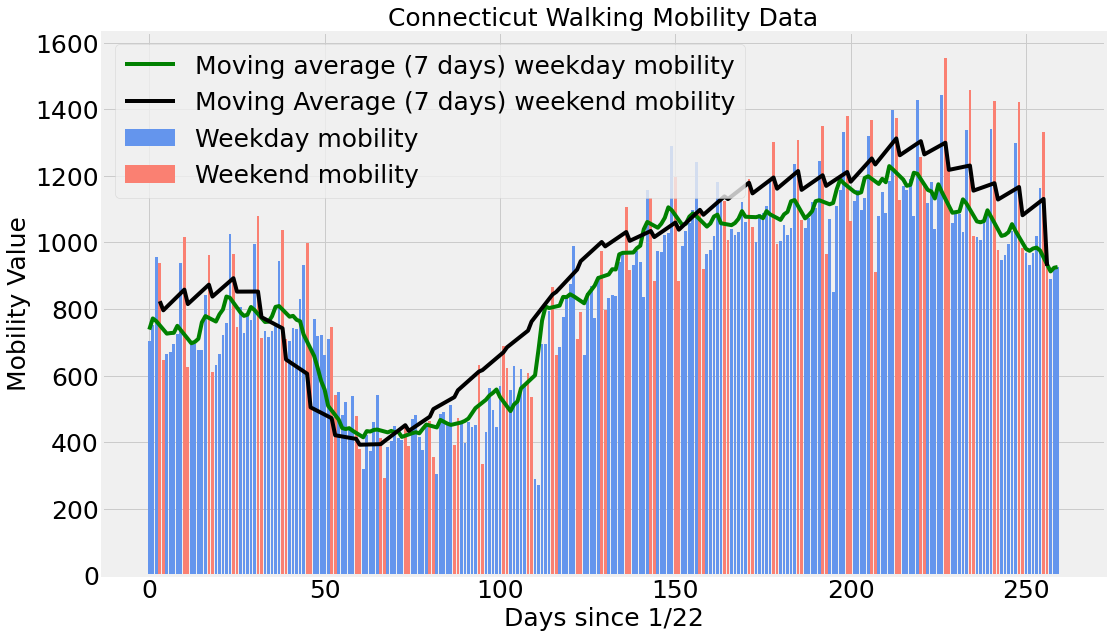

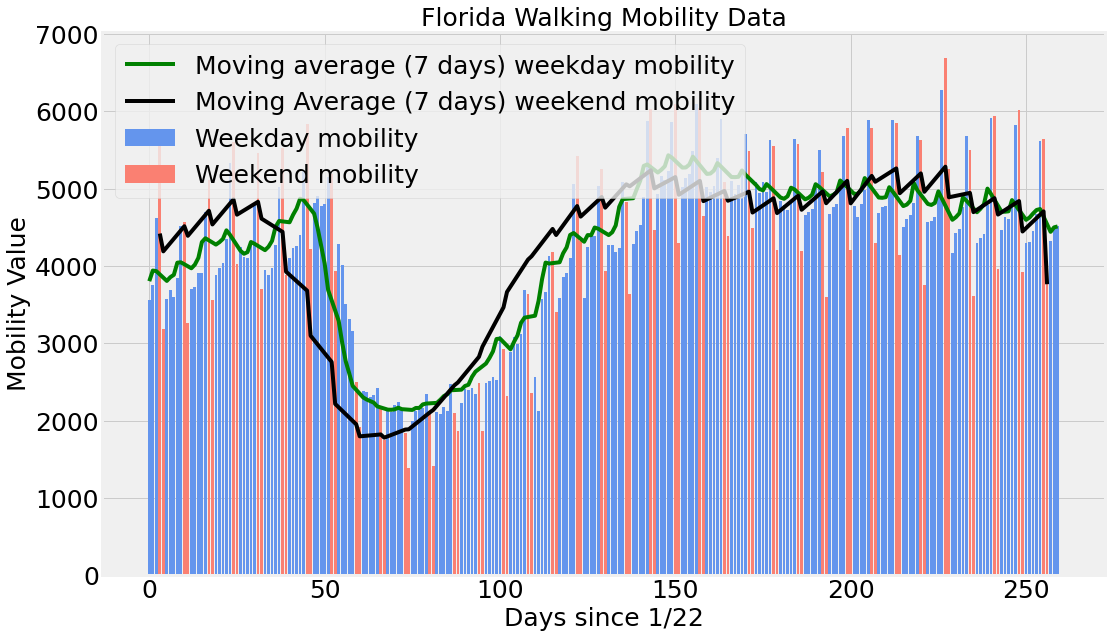

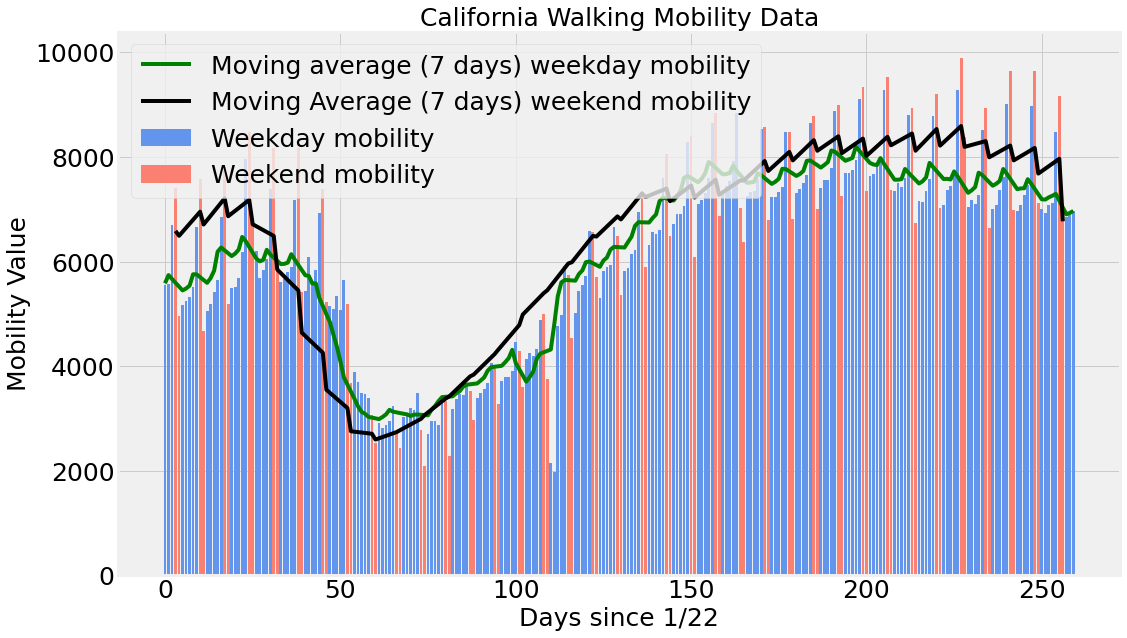

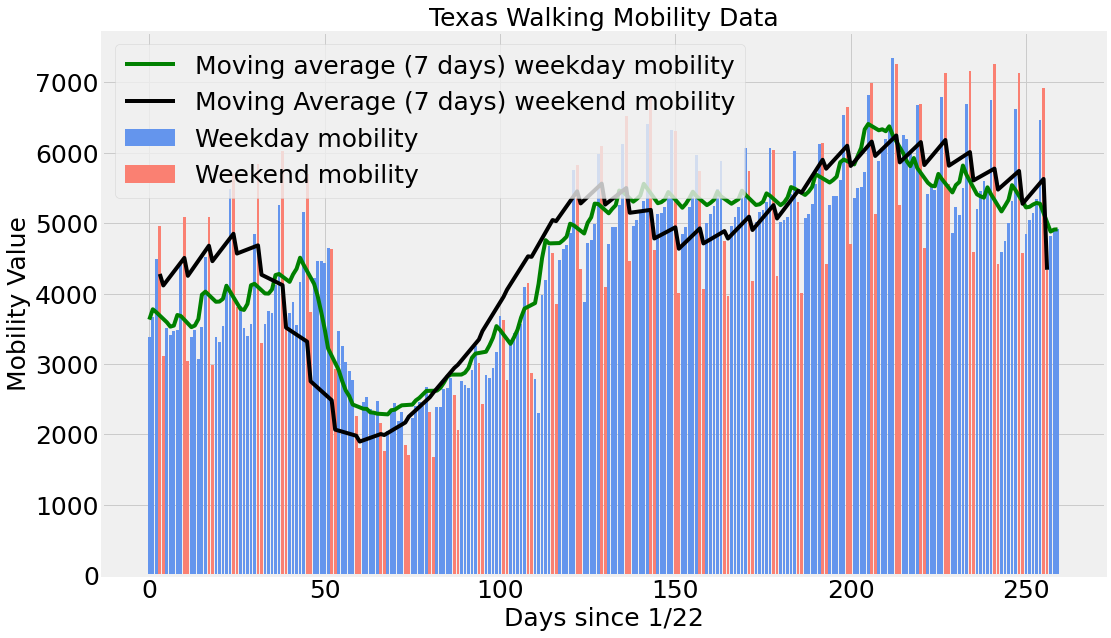

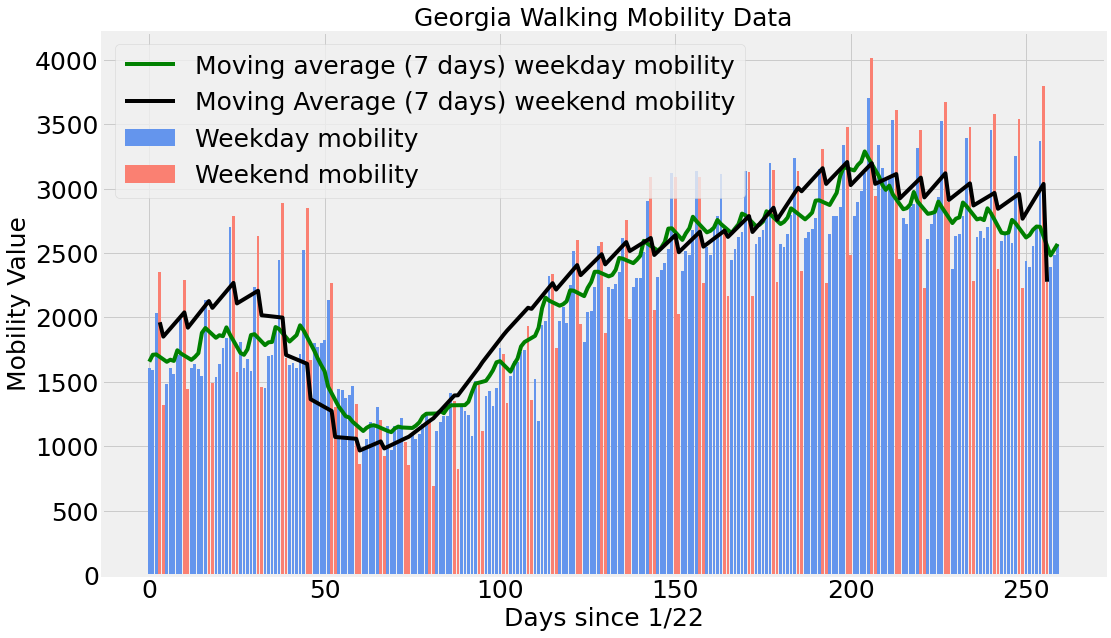

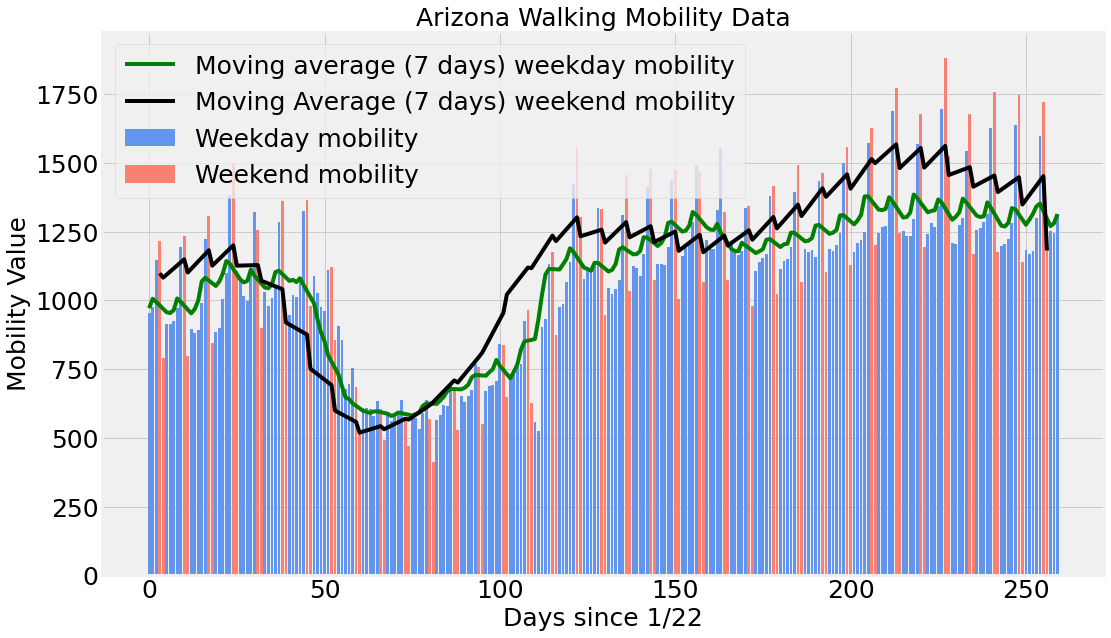

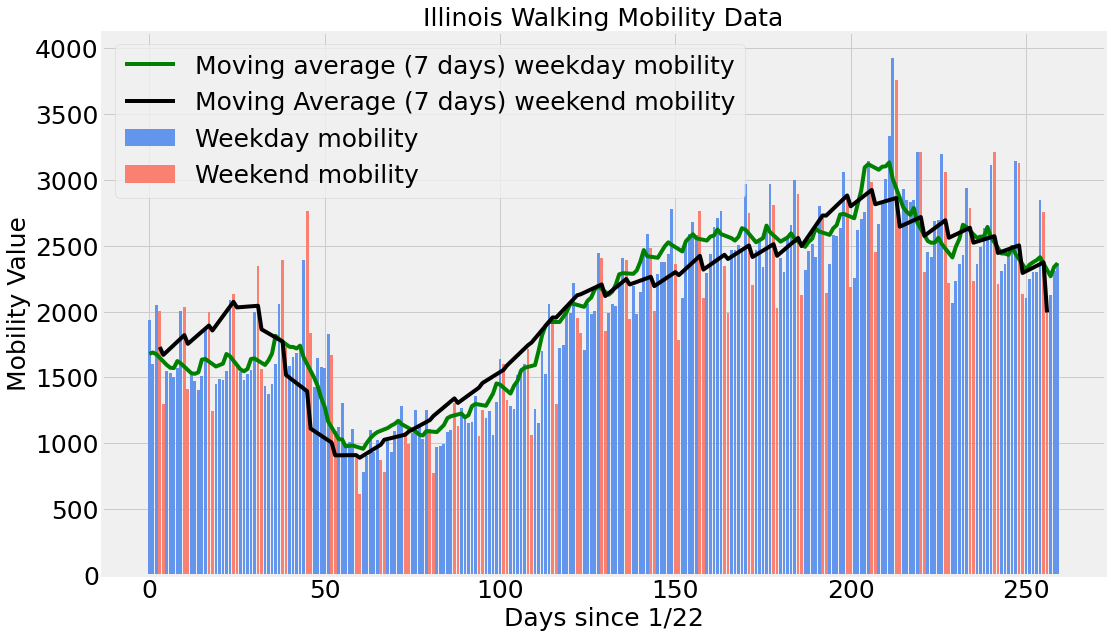

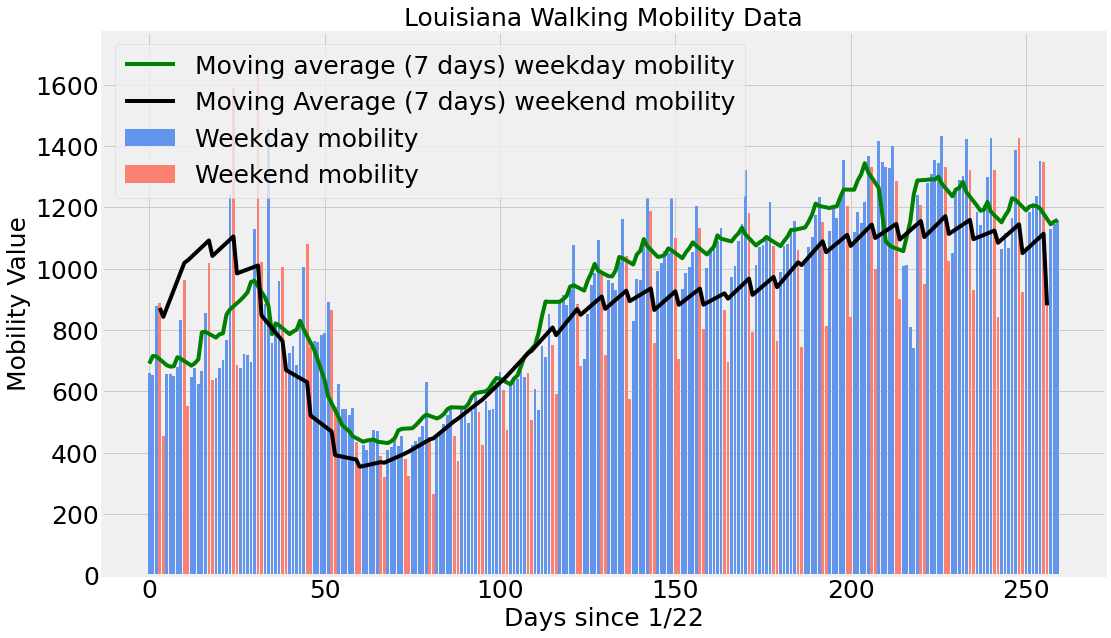

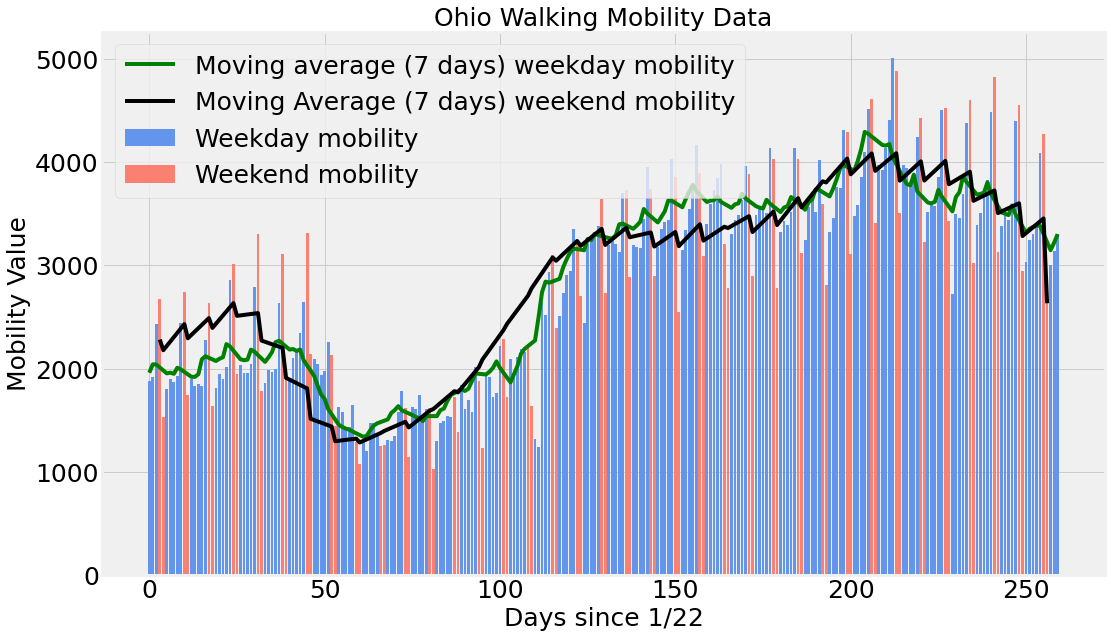

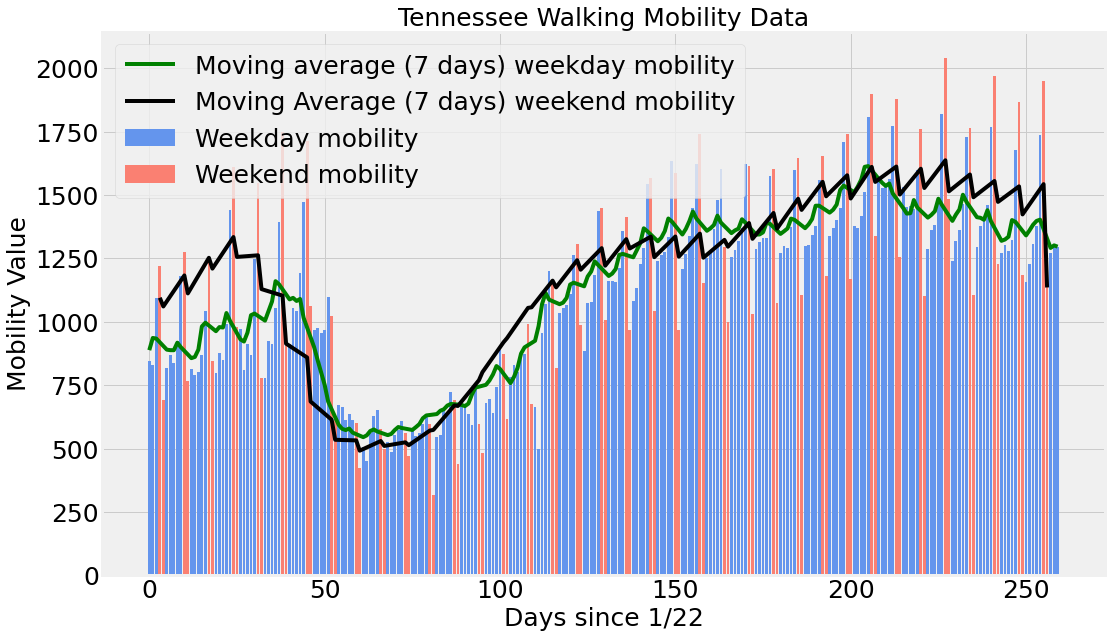

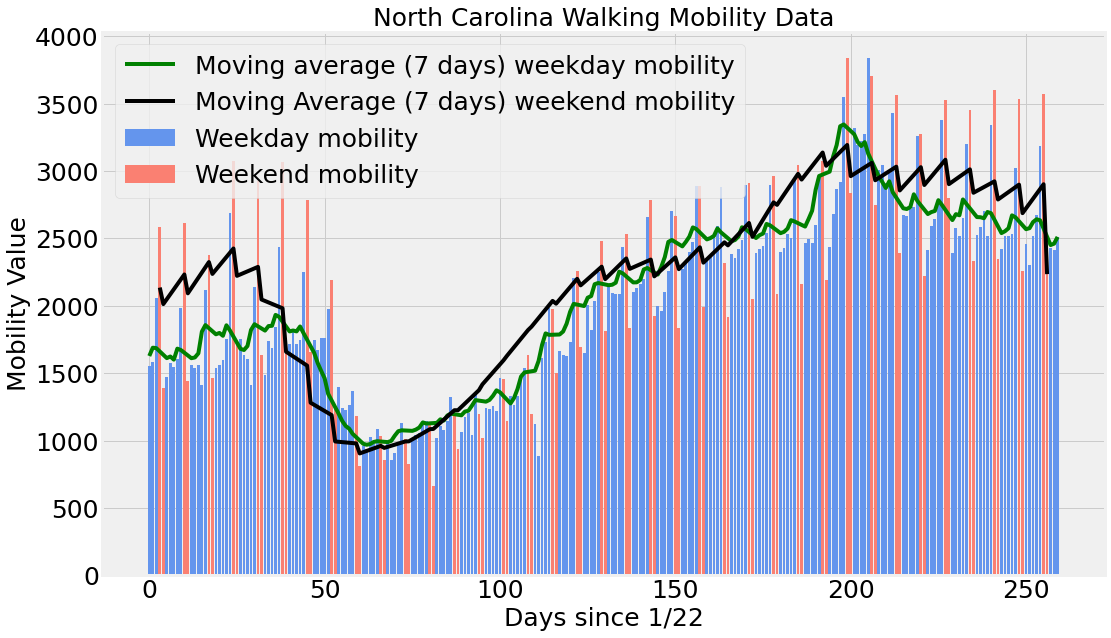

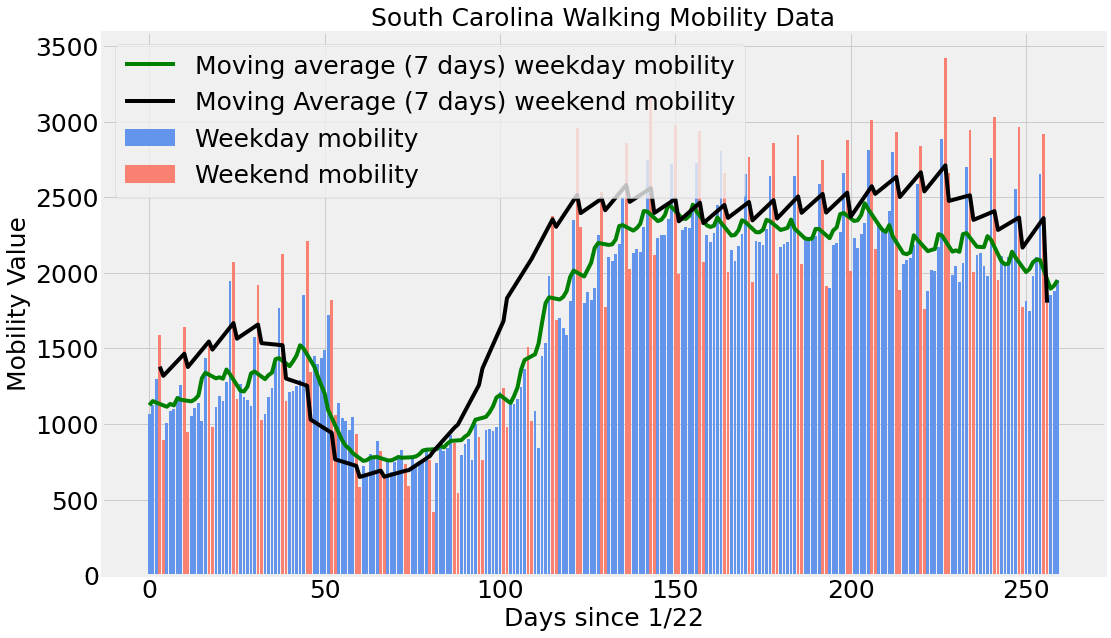

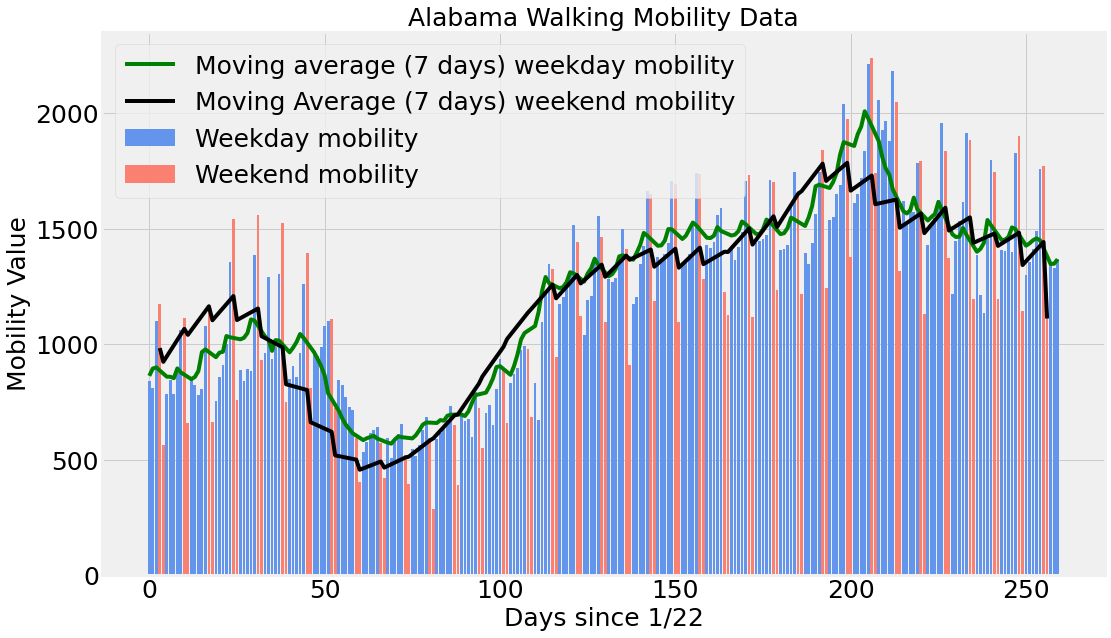

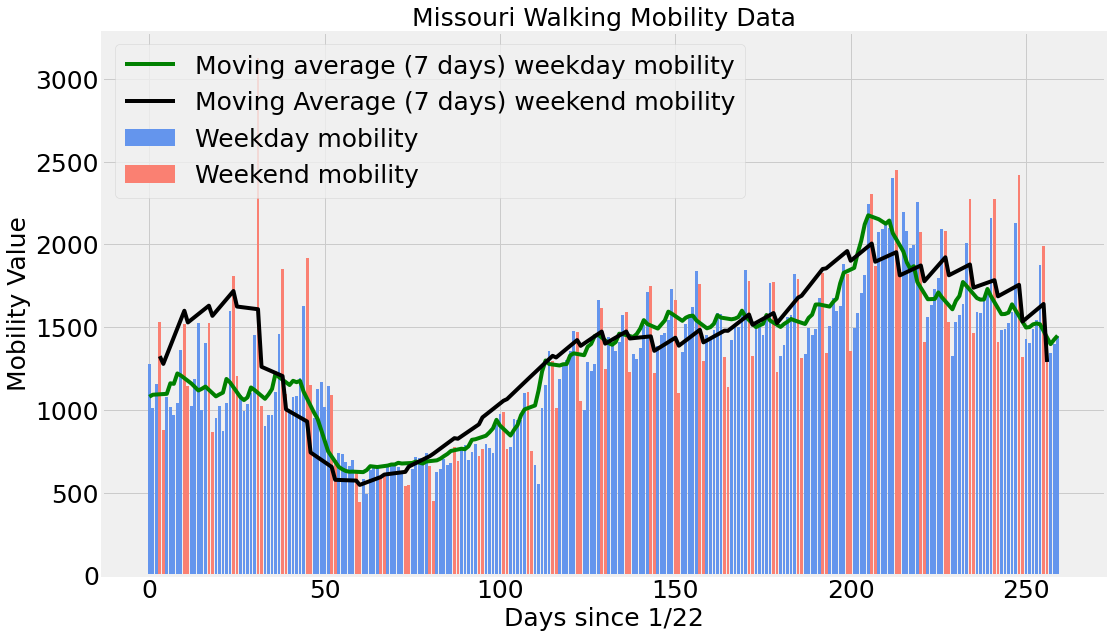

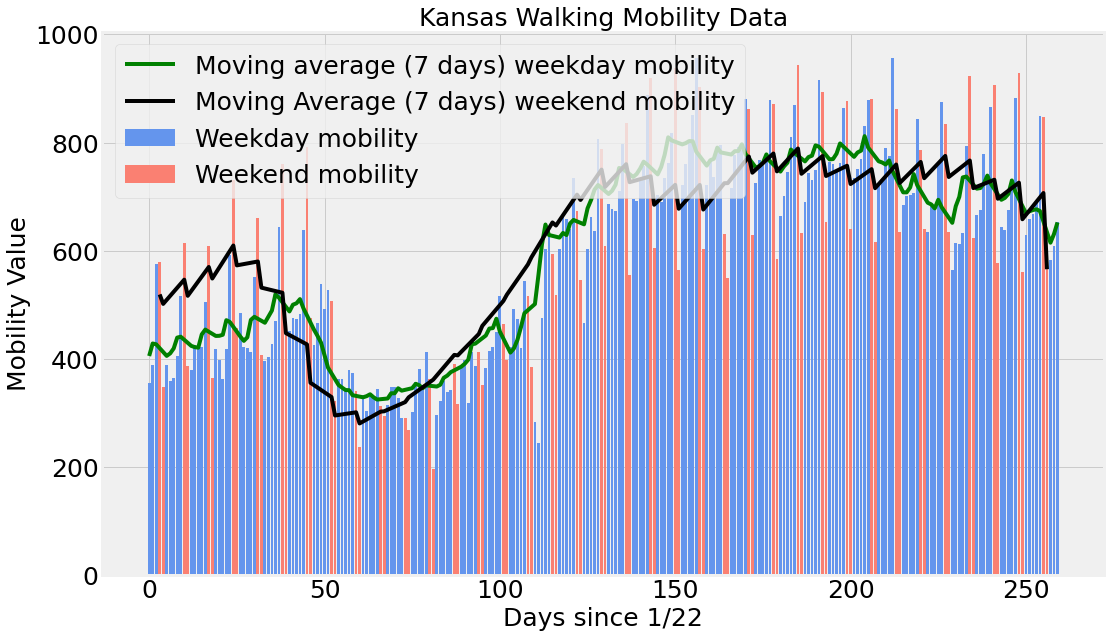

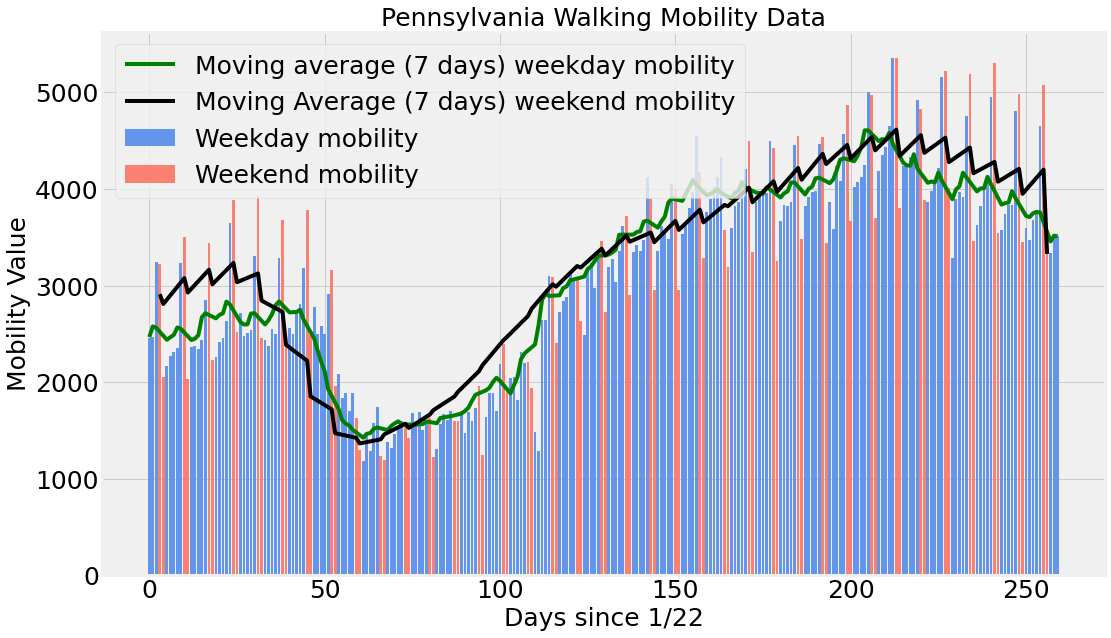

In [176]:
import matplotlib.dates as mdates
states = ['New York', 'Connecticut', 'Florida', 'California', 'Texas', 'Georgia', 'Arizona', 
          'Illinois', 'Louisiana', 'Ohio','Tennessee', 'North Carolina', 'South Carolina', 
          'Alabama', 'Missouri', 'Kansas', 'Pennsylvania']

# 日期格式整合
mobility_latest_date = apple_mobility.columns[-1]
mobility_latest_index = revised_dates.index(mobility_latest_date)

for state in states:
    # 將週末(Weekend)和週間(Weekday)的資料分別統計
    weekday_mobility = []
    weekday_mobility_dates = [] 
    weekend_mobility = [] 
    weekend_mobility_dates = [] 
    
    for i in range(len(revised_dates)):
        if i <= mobility_latest_index:
            if weekday_or_weekend(revised_dates[i]):
                weekend_mobility.append(get_mobility_by_state('walking', state, revised_dates[i]))
                weekend_mobility_dates.append(i)
            else:
                weekday_mobility.append(get_mobility_by_state('walking', state, revised_dates[i]))
                weekday_mobility_dates.append(i)
        else:
            pass
        
    # 移除為零的資料
    for i in range(len(weekend_mobility)):       
        if weekend_mobility[i] == 0 and i != 0:
            weekend_mobility[i] = weekend_mobility[i-1]
        elif weekend_mobility[i] == 0 and i == 0:
            weekend_mobility[i] = weekend_mobility[i+1]
        else:
            pass
        
    for i in range(len(weekday_mobility)):       
        if weekday_mobility[i] == 0 and i != 0:
            weekday_mobility[i] = weekday_mobility[i-1]
        elif weekday_mobility[i] == 0 and i == 0:
            weekday_mobility[i] = weekday_mobility[i+1]
        else:
            pass
    
    
    weekday_mobility_average = moving_average(weekday_mobility, 7)
    weekend_mobility_average = moving_average(weekend_mobility, 7)
    
    plt.figure(figsize=(16, 10))
    plt.bar(weekday_mobility_dates, weekday_mobility, color='cornflowerblue')
    plt.plot(weekday_mobility_dates, weekday_mobility_average, color='green')
    
    plt.bar(weekend_mobility_dates, weekend_mobility, color='salmon')
    plt.plot(weekend_mobility_dates, weekend_mobility_average, color='black')
    
    plt.legend(['Moving average (7 days) weekday mobility', 'Moving Average (7 days) weekend mobility', 'Weekday mobility', 'Weekend mobility'], prop={'size': 25})
    plt.title('{} Walking Mobility Data'.format(state), size=25)
    plt.xlabel('Days since 1/22', size=25)
    plt.ylabel('Mobility Value', size=25)
    plt.xticks(size=25)
    plt.yticks(size=25)
    plt.show()